In [1]:
import numpy as np

import pandas as pd

# used to grab the stock prices, with yahoo

import pandas_datareader as web

from datetime import datetime
from dateutil.relativedelta import relativedelta

# to visualize the results

import matplotlib.pyplot as plt

import seaborn

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import os
import re
from time import sleep

In [2]:
# STEP 1: Load stock screener data from nasdaq.
# The stock screener is a csv file downloaded from the nasdaq website and contains information (Symbol, market cap,
# sectors, industries and more) about different stocks.



chromeOptions = webdriver.ChromeOptions()
cur_dir = os.getcwd()
prefs = {"download.default_directory" : cur_dir}
chromeOptions.add_experimental_option("prefs",prefs)

driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), chrome_options=chromeOptions)
driver.get("https://www.nasdaq.com/market-activity/stocks/screener")

driver.implicitly_wait(5)
link = driver.find_element_by_class_name("nasdaq-screener__download")
link.click()


file_location = os.path.join(cur_dir, 'nasdaq_screener.csv')

if os.path.isfile(file_location):
    os.remove(file_location) # delete if previous file exists

# delete suffix from the csv file's name
file_regex = re.compile('nasdaq_screener_\d+\.csv')

sleep(15)

while not os.path.isfile(file_location):
    for root, dirs, files in os.walk(cur_dir):
        for f in files:
            if file_regex.match(f):
                os.rename(f, 'nasdaq_screener.csv')
                break


driver.close()



====== WebDriver manager ======
Current google-chrome version is 98.0.4758
Get LATEST chromedriver version for 98.0.4758 google-chrome
Driver [/Users/nadavsmacbookpro/.wdm/drivers/chromedriver/mac64/98.0.4758.80/chromedriver] found in cache
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  app.launch_new_instance()


In [31]:
# Get tickers from csv to pandas

stocks_screener = pd.read_csv('nasdaq_screener.csv')
stocks_screener = stocks_screener.sort_values(by='Market Cap', ascending=False)
# stocks_screener.loc[stocks_screener["Sector"].isnull()]["Sector"].repla = "undefined"
stocks_screener["Sector"].fillna('undefined', inplace=True)
stocks_screener["Industry"].fillna('undefined', inplace=True)
stocks_screener


Symbol                                               Name Last Sale  \
20      AAPL                            Apple Inc. Common Stock   $172.12   
5072    MSFT                 Microsoft Corporation Common Stock   $302.38   
3405   GOOGL                 Alphabet Inc. Class A Common Stock  $2772.40   
3404    GOOG                Alphabet Inc. Class C Capital Stock  $2772.05   
474     AMZN                       Amazon.com Inc. Common Stock  $3180.07   
...      ...                                                ...       ...   
8195   WRB^G  W.R. Berkley Corporation 4.25% Subordinated De...    $22.04   
8196   WRB^H  W.R. Berkley Corporation 4.125% Subordinated D...    $22.02   
8209   WSO/B                                        Watsco Inc.   $273.44   
8262  XFLT^A  XAI Octagon Floating Rate & Alternative Income...  $25.9054   
8307  YCBD^A  cbdMD Inc. 8.0% Series A Cumulative Convertibl...   $5.6399   

      Net Change % Change    Market Cap        Country  IPO Year    Volume  \
20       -4.1600   -2.36%  2.984103e+12  United States    1980.0  90705082   
5072     -8.8300  -2.837%  2.266902e+12  United States    1986.0  45310304   
3405    -59.4400  -2.099%  1.832477e+12  United States       NaN   1963016   
3404    -57.0100  -2.015%  1.832246e+12  United States    2004.0   1648388   
474     -43.7200  -1.356%  1.618161e+12  United States    1997.0   3403621   
...          ...      ...           ...            ...       ...       ...   
8195     -0.8100  -3.545%           NaN  United States       NaN     16496   
8196     -0.5800  -2.566%           NaN  United States       NaN     30873   
8209     -7.3500  -2.618%           NaN  United States       NaN       385   
8262     -0.1746  -0.669%           NaN  United States       NaN       985   
8307      0.0899    1.62%           NaN  United States       NaN     25921   

                 Sector                                 Industry  
20           Technology                   Computer Manufacturing  
5072         Technology  Computer Software: Prepackaged Software  
3405         Technology        Internet and Information Services  
3404         Technology        Internet and Information Services  
474   Consumer Services           Catalog/Specialty Distribution  
...                 ...                                      ...  
8195          undefined                                undefined  
8196          undefined                                undefined  
8209          undefined                                undefined  
8262          undefined                                undefined  
8307          undefined                                undefined  

[8392 rows x 11 columns]

In [73]:
# Load N_STOCKS from each sector
N_STOCKS = 50

sectors_set = set(stocks_screener["Sector"])
sectors_dict = {sector: list(stocks_screener.loc[stocks_screener["Sector"] == sector]["Symbol"][:N_STOCKS])
                for sector in sectors_set}

In [33]:
seaborn.set(rc={"figure.dpi":300, 'savefig.dpi':300})

# select start date for correlation window as well as list of tickers

# start = datetime.today() + relativedelta(months=-12)

# symbols_list = list(stocks_screener['Symbol'][:50])
# symbols= dict()

In [74]:
# pull price using iex for each symbol in list defined above
start = datetime.today() + relativedelta(months=-12)
sectors_df = {sector: list() for sector in sectors_set}
for key, value in sectors_dict.items():
    print(f"######### {key} #########\n")
    if len(value) == 0:
        continue
    dates = set()
    for ticker in value:
        r = web.DataReader(ticker, 'yahoo', start)

        if len(dates) == 0:
            dates = set(r.index)
        else:
            dates = dates.intersection(set(r.index))

        # add a symbol column
        r['Symbol'] = ticker
        r['Industry'] = list(stocks_screener.loc[stocks_screener["Symbol"] == ticker]['Industry'])[0]

        sectors_df[key].append(r)
    sectors_df[key] = pd.concat(sectors_df[key])
    sectors_df[key] = sectors_df[key].loc[list(dates)]


# sectors_df

######### undefined #########

######### Technology #########

######### Consumer Services #########

######### Finance #########

######### Capital Goods #########

######### Miscellaneous #########

######### Consumer Non-Durables #########

######### Energy #########

######### Public Utilities #########

######### Health Care #########

######### Basic Industries #########

######### Consumer Durables #########

######### Transportation #########



In [75]:
sectors_df['Basic Industries']

High         Low        Open       Close      Volume  \
Date                                                                     
2021-12-09   57.250000   56.700001   56.970001   57.060001   2504000.0   
2021-12-09  334.000000  330.500000  331.049988  332.119995   1086500.0   
2021-12-09   64.040001   63.290001   63.439999   63.980000   4370100.0   
2021-12-09   13.670000   13.420000   13.460000   13.500000  16838500.0   
2021-12-09  347.309998  343.119995  343.890015  343.869995    668300.0   
...                ...         ...         ...         ...         ...   
2021-12-22   19.990000   19.549999   19.559999   19.990000    173400.0   
2021-12-22   56.049999   54.889999   55.000000   55.840000   1091300.0   
2021-12-22   20.360001   19.850000   20.190001   20.240000   2243100.0   
2021-12-22   32.570000   31.809999   32.000000   32.400002   1685400.0   
2021-12-22  157.529999  152.619995  152.949997  157.529999    255900.0   

             Adj Close Symbol                Industry  
Date                                                   
2021-12-09   57.060001    BHP         Precious Metals  
2021-12-09  332.119995    LIN         Major Chemicals  
2021-12-09   63.980000    RIO          Steel/Iron Ore  
2021-12-09   13.500000   VALE          Steel/Iron Ore  
2021-12-09  343.869995    SHW         Paints/Coatings  
...                ...    ...                     ...  
2021-12-22   19.990000    BAK         Major Chemicals  
2021-12-22   55.840000    OLN  Industrial Specialties  
2021-12-22   20.240000     AU         Precious Metals  
2021-12-22   32.400002    HUN         Major Chemicals  
2021-12-22  157.529999    SMG  Agricultural Chemicals  

[12650 rows x 8 columns]

In [76]:
from collections import OrderedDict
dataframes = {sector: None for sector in sectors_set}
# concatenate into df
counter = 0
x = None
for sector in sectors_set:
    if len(sectors_df[sector]) == 0:
        continue

    df = sectors_df[sector].sort_values(by='Industry')
    order = list(OrderedDict.fromkeys(df['Symbol'].tolist()))

    df = df.reset_index()

    df = df[['Date', 'Close', 'Symbol']]

    df_pivot = df.pivot(index='Date', columns='Symbol', values='Close')

    # df_pivot.head()

    dataframes[sector] = df_pivot

# dataframes[sector]
dataframes['Basic Industries']


Symbol             AA        ACH         ALB   AMCR         APD         AU  \
Date                                                                         
2021-02-11  21.389999   8.730000  159.850006  11.30  257.690002  23.940001   
2021-02-12  21.660000   8.800000  164.639999  11.50  260.549988  23.990000   
2021-02-16  22.430000   9.690000  162.199997  11.25  260.730011  22.860001   
2021-02-17  21.930000  10.290000  157.470001  11.30  260.010010  21.510000   
2021-02-18  21.120001  10.580000  141.460007  11.42  262.649994  20.790001   
...               ...        ...         ...    ...         ...        ...   
2022-02-04  64.220001  13.550000  216.020004  11.56  263.079987  18.879999   
2022-02-07  63.750000  14.080000  219.779999  11.49  254.380005  19.400000   
2022-02-08  69.970001  15.270000  226.690002  11.62  252.809998  20.059999   
2022-02-09  71.910004  16.389999  236.429993  11.78  259.359985  19.990000   
2022-02-10  71.169998  16.170000  236.039993  11.62  252.380005  19.370001   

Symbol           AVTR        BAK          BG        BHP  ...        SEE  \
Date                                                     ...              
2021-02-11  30.240000  11.030000   76.209999  69.720001  ...  43.500000   
2021-02-12  30.670000  11.320000   78.000000  70.379997  ...  44.090000   
2021-02-16  29.799999  11.500000   79.309998  75.480003  ...  42.720001   
2021-02-17  29.629999  11.360000   78.000000  75.570000  ...  43.410000   
2021-02-18  28.750000  11.150000   74.739998  75.800003  ...  42.849998   
...               ...        ...         ...        ...  ...        ...   
2022-02-04  37.139999  20.360001   98.099998  66.160004  ...  64.360001   
2022-02-07  36.410000  20.820000   98.919998  68.449997  ...  63.549999   
2022-02-08  36.869999  20.719999  100.959999  69.160004  ...  64.959999   
2022-02-09  37.700001  20.629999   99.599998  68.900002  ...  65.230003   
2022-02-10  37.459999  20.780001   99.059998  69.940002  ...  64.379997   

Symbol             SHW         SMG        SQM       STLD    SUZ         TS  \
Date                                                                         
2021-02-11  239.763336  240.880005  54.279999  38.779999  13.18  16.959999   
2021-02-12  240.350006  245.410004  56.669998  39.330002  13.18  17.389999   
2021-02-16  235.806671  244.160004  57.459999  41.189999  13.54  18.309999   
2021-02-17  240.466660  238.850006  55.630001  40.709999  13.44  17.889999   
2021-02-18  242.253326  231.679993  53.009998  39.700001  13.69  17.250000   
...                ...         ...        ...        ...    ...        ...   
2022-02-04  281.730011  132.869995  53.270000  58.939999  11.35  26.240000   
2022-02-07  279.220001  131.309998  55.599998  58.330002  11.50  26.209999   
2022-02-08  279.670013  134.080002  56.630001  60.599998  11.48  26.080000   
2022-02-09  286.619995  136.050003  58.820000  62.549999  11.53  26.170000   
2022-02-10  279.929993  142.509995  62.639999  61.340000  11.14  26.280001   

Symbol             TX       VALE         WLK  
Date                                          
2021-02-11  27.799999  17.370001   86.480003  
2021-02-12  29.280001  17.500000   87.080002  
2021-02-16  29.260000  18.030001   88.050003  
2021-02-17  29.020000  17.870001   86.940002  
2021-02-18  29.100000  17.980000   84.379997  
...               ...        ...         ...  
2022-02-04  41.680000  16.549999  101.550003  
2022-02-07  41.669998  17.170000   99.709999  
2022-02-08  43.259998  17.430000  102.400002  
2022-02-09  43.709999  17.510000  103.580002  
2022-02-10  44.459999  17.850000  103.209999  

[253 rows x 50 columns]

In [15]:
corr_df = df_pivot.corr(method='pearson')

# reset symbol as index (rather than 0-X)

corr_df.head().reset_index()

#del corr_df.index.name

corr_df.head(10)
# corr_df = corr_df.reindex(corr_df.mean().sort_values().index, axis = 0)

Symbol      AMZN     CMCSA      COST       DIS        HD       LOW       MCD  \
Symbol                                                                         
AMZN    1.000000  0.256670  0.319003 -0.009009  0.357584  0.281588  0.290887   
CMCSA   0.256670  1.000000 -0.320598  0.604068 -0.292489 -0.367702 -0.185069   
COST    0.319003 -0.320598  1.000000 -0.797290  0.936654  0.931314  0.911128   
DIS    -0.009009  0.604068 -0.797290  1.000000 -0.760835 -0.773383 -0.720780   
HD      0.357584 -0.292489  0.936654 -0.760835  1.000000  0.983710  0.939911   
LOW     0.281588 -0.367702  0.931314 -0.773383  0.983710  1.000000  0.934324   
MCD     0.290887 -0.185069  0.911128 -0.720780  0.939911  0.934324  1.000000   
NFLX    0.552914 -0.117848  0.494747 -0.099372  0.461158  0.455708  0.322095   
T      -0.237009  0.460176 -0.878580  0.750873 -0.762812 -0.775816 -0.702218   
WMT     0.346144  0.018879  0.435066 -0.205569  0.308077  0.284243  0.272713   

Symbol      NFLX         T       WMT  
Symbol                                
AMZN    0.552914 -0.237009  0.346144  
CMCSA  -0.117848  0.460176  0.018879  
COST    0.494747 -0.878580  0.435066  
DIS    -0.099372  0.750873 -0.205569  
HD      0.461158 -0.762812  0.308077  
LOW     0.455708 -0.775816  0.284243  
MCD     0.322095 -0.702218  0.272713  
NFLX    1.000000 -0.546438  0.348519  
T      -0.546438  1.000000 -0.284295  
WMT     0.348519 -0.284295  1.000000

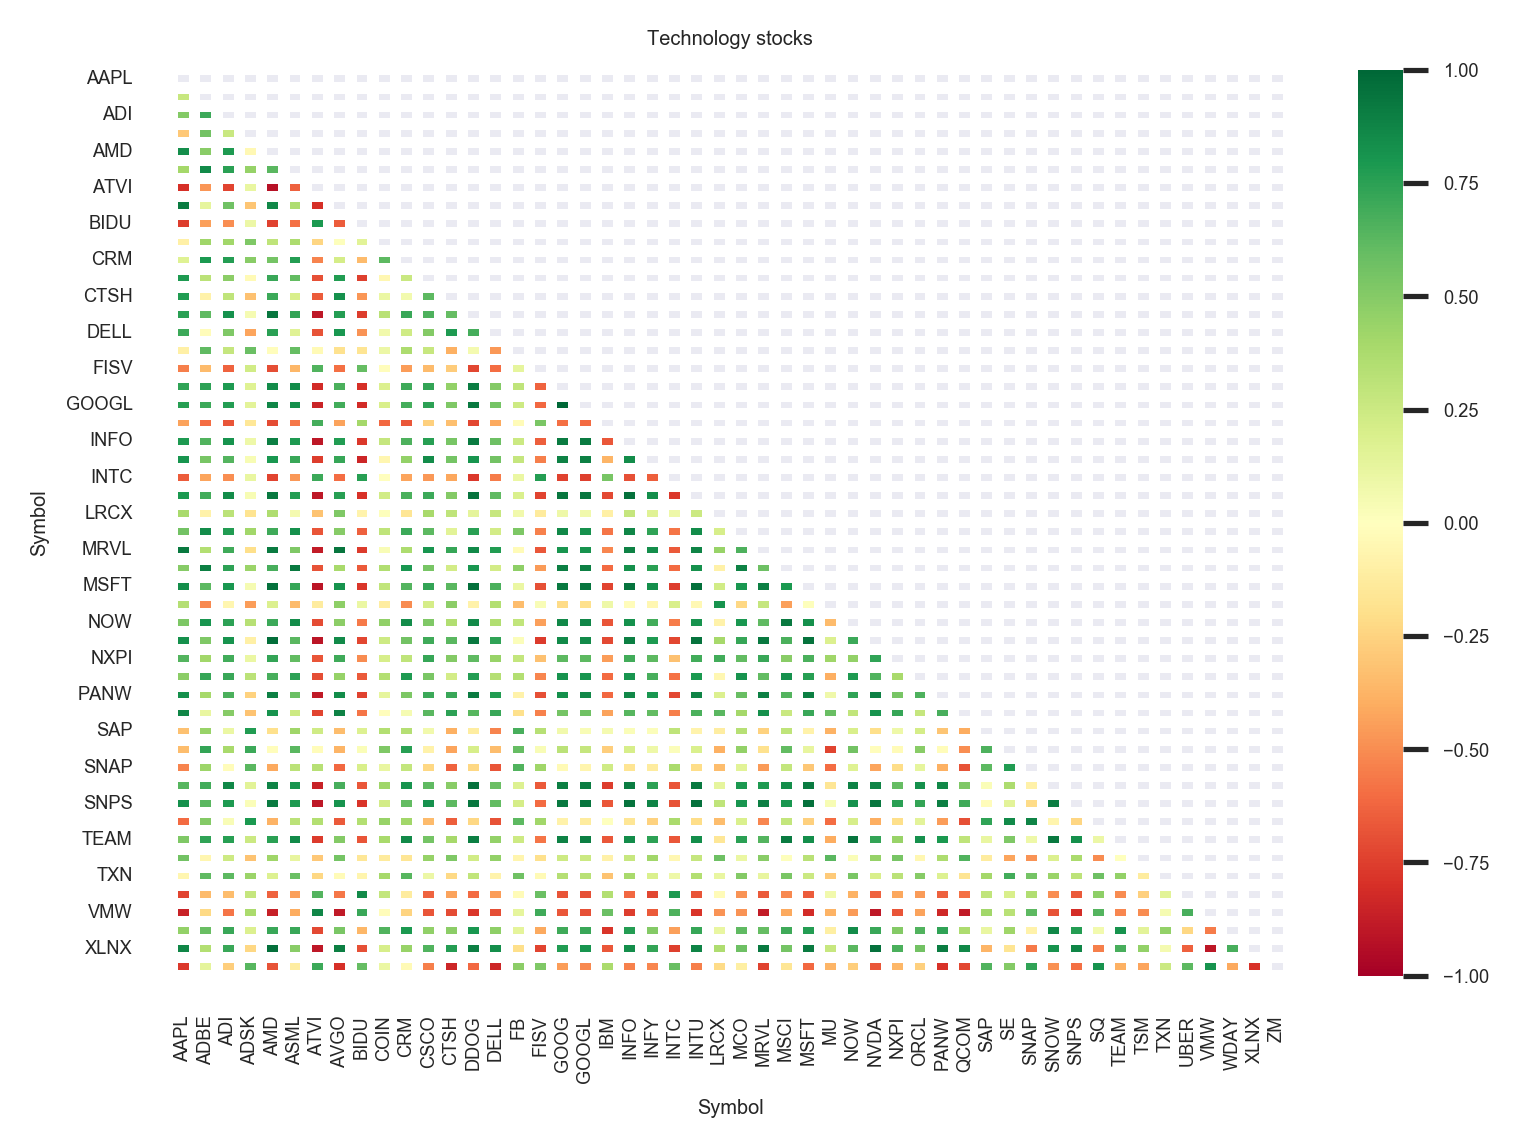

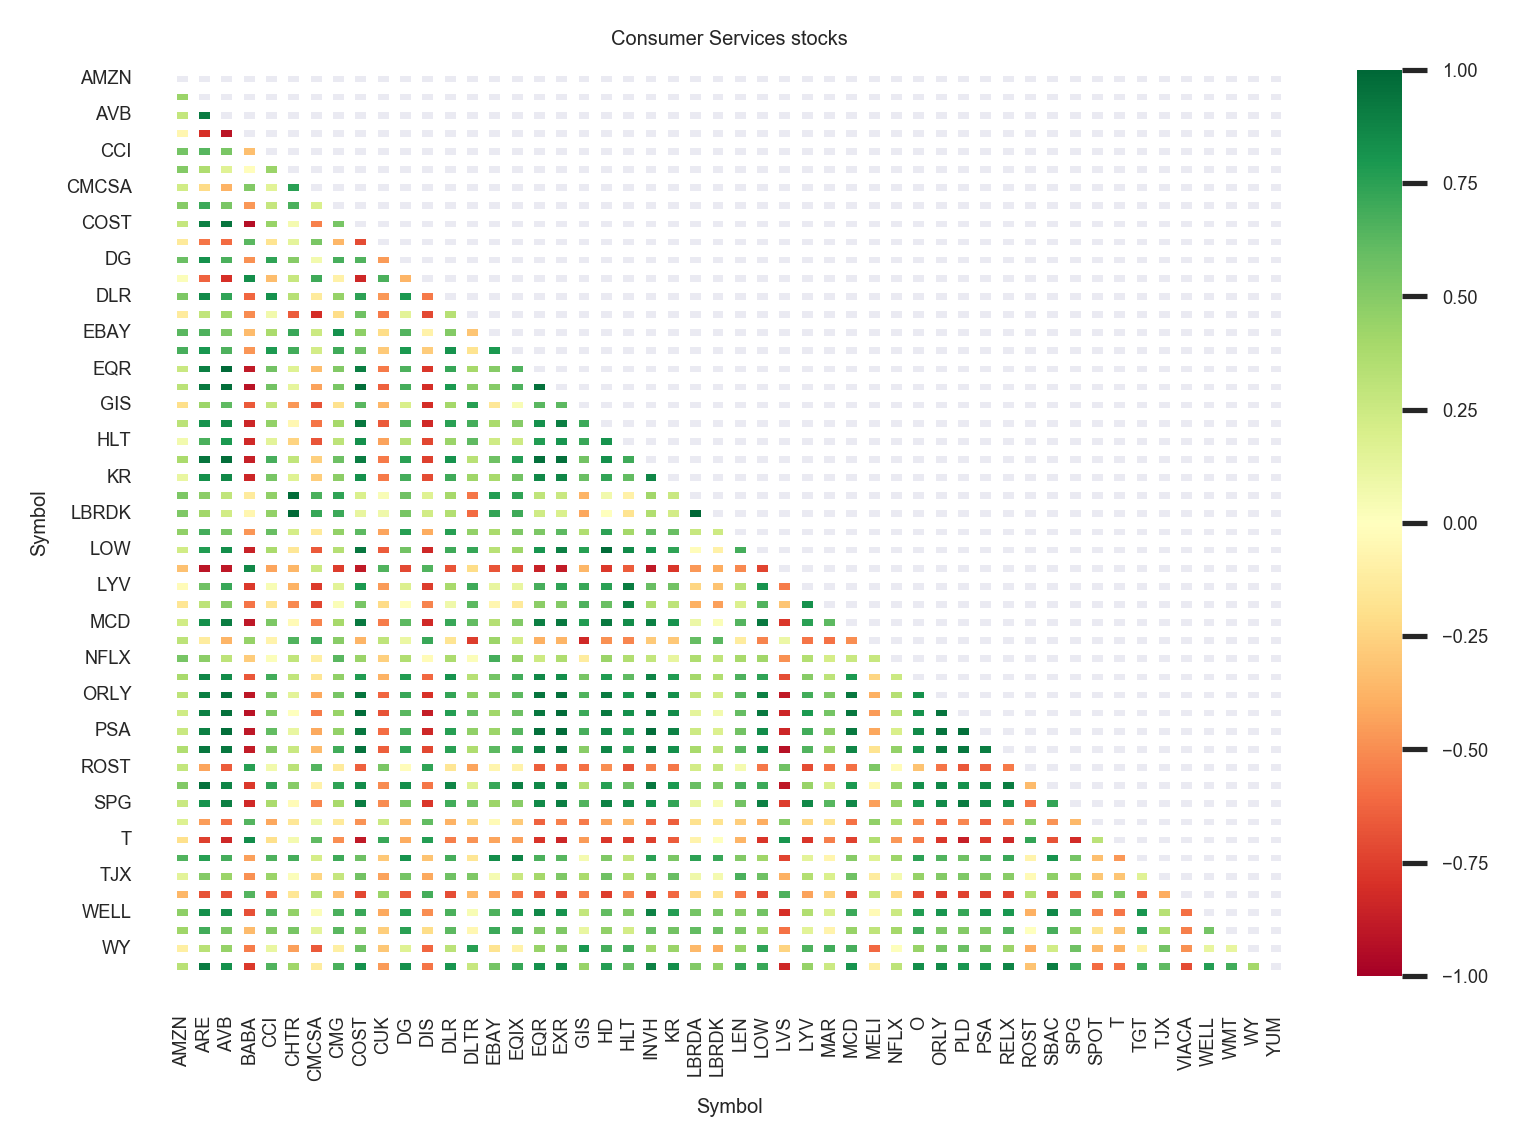

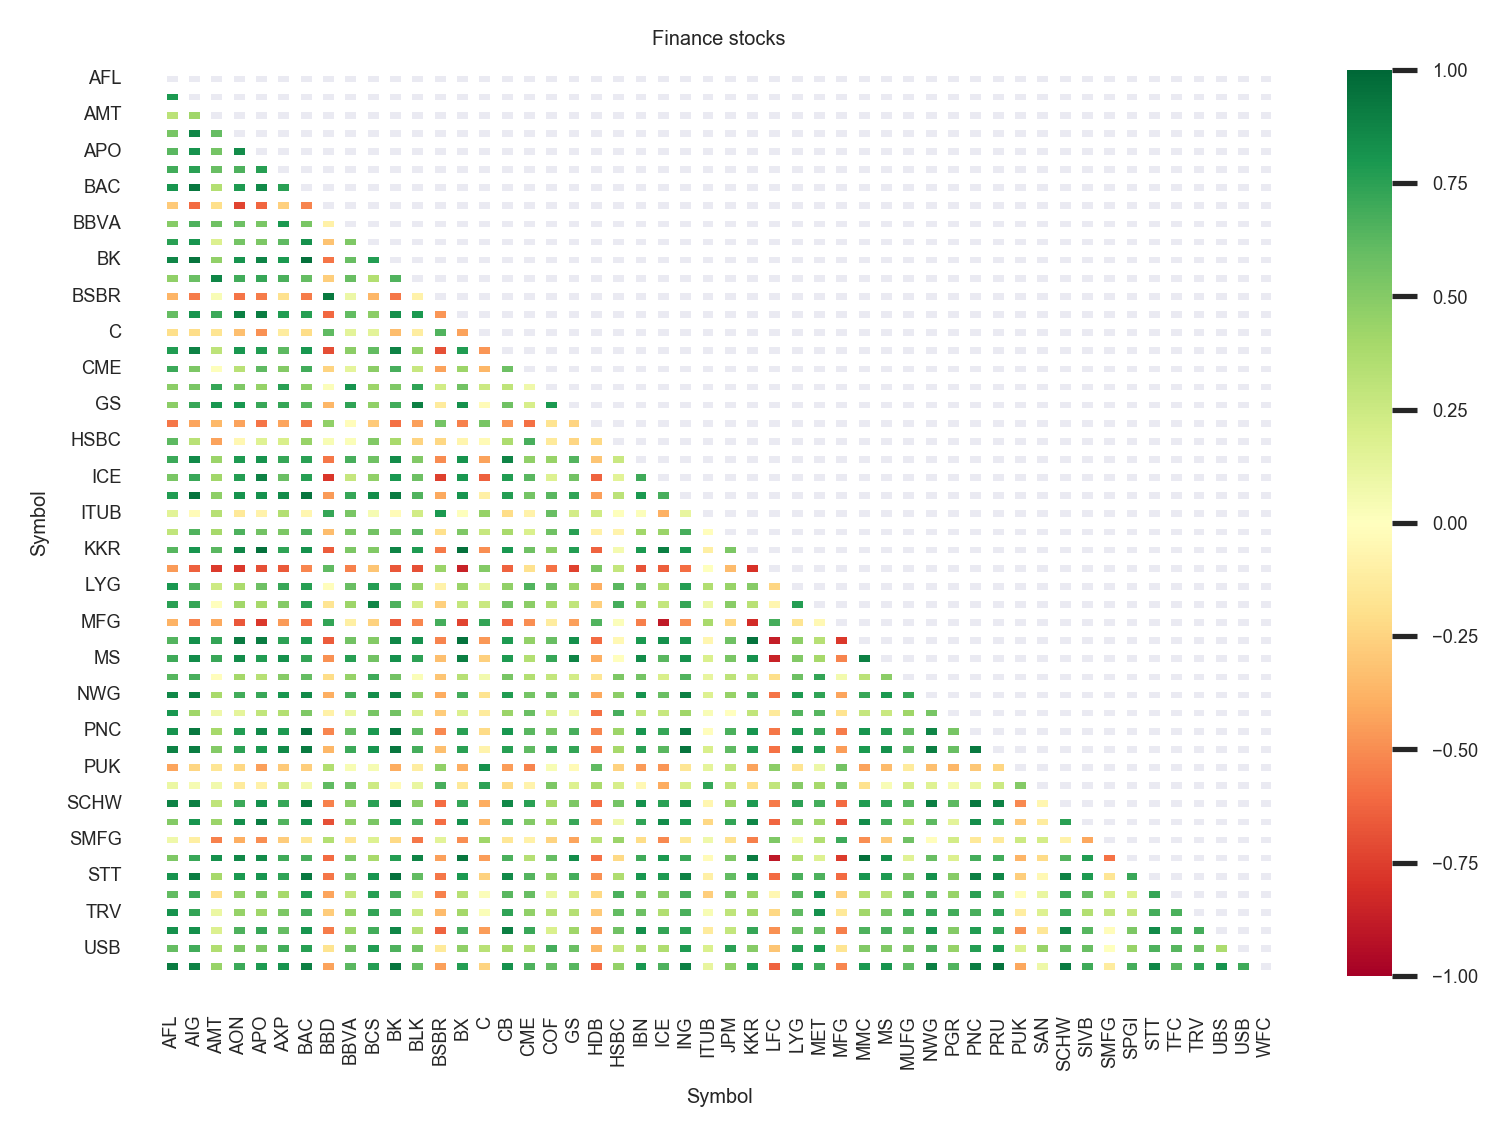

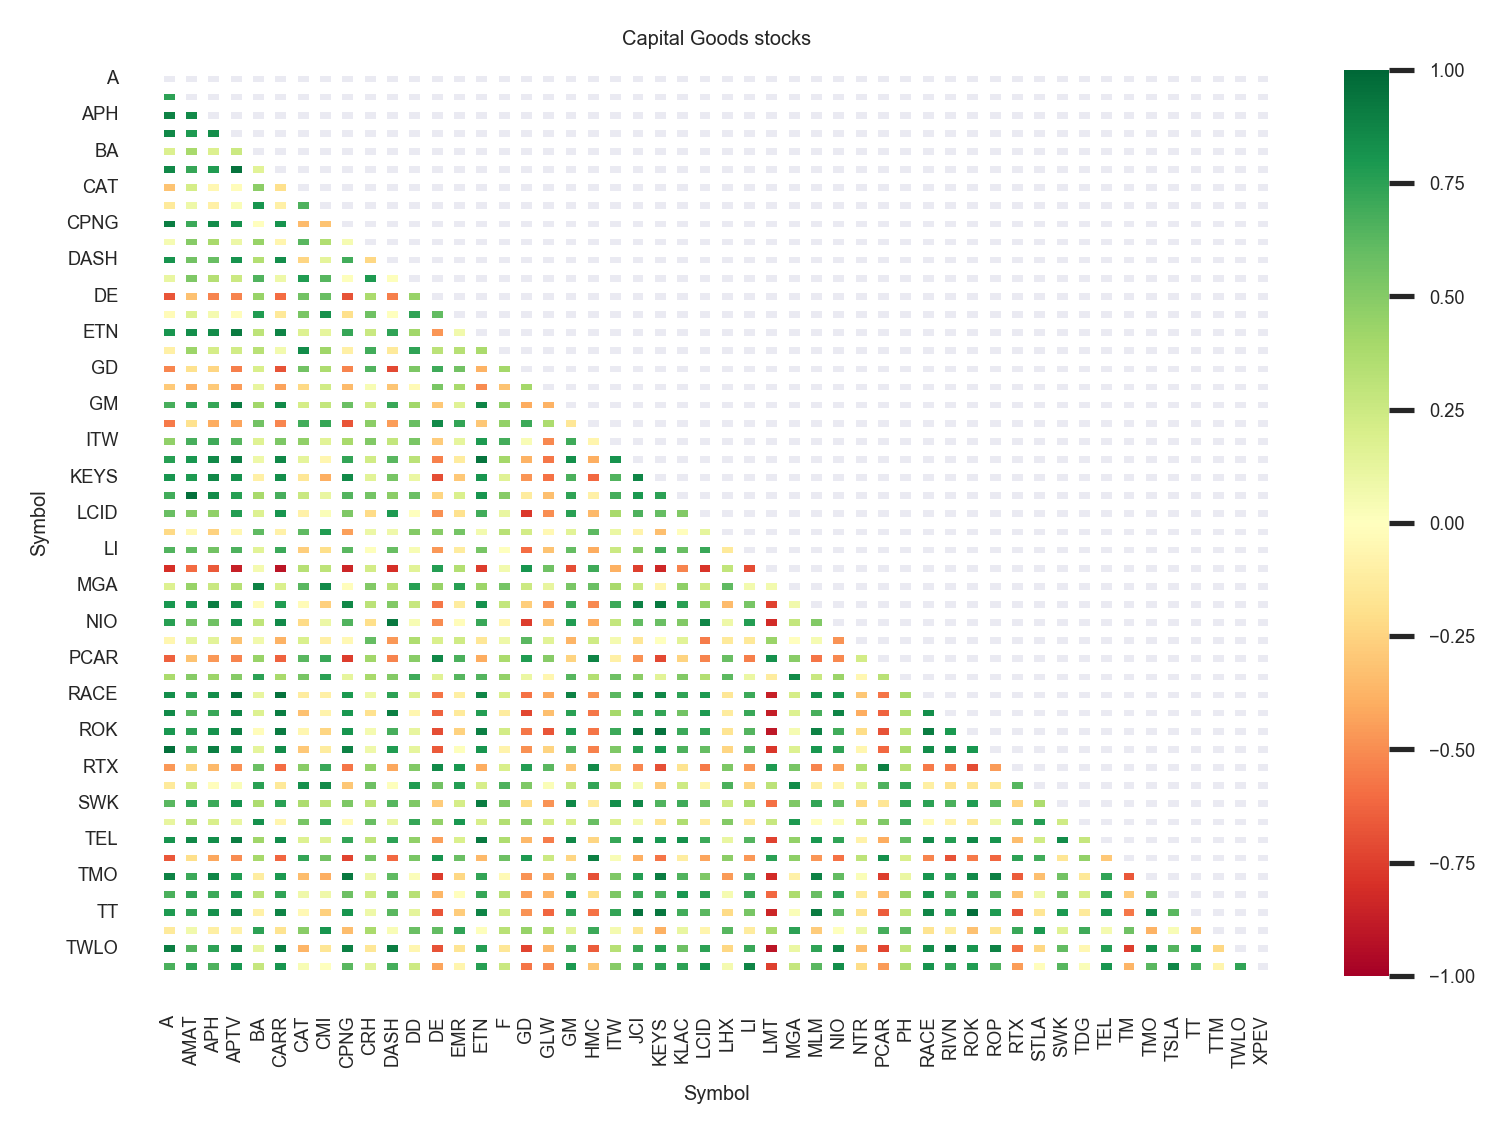

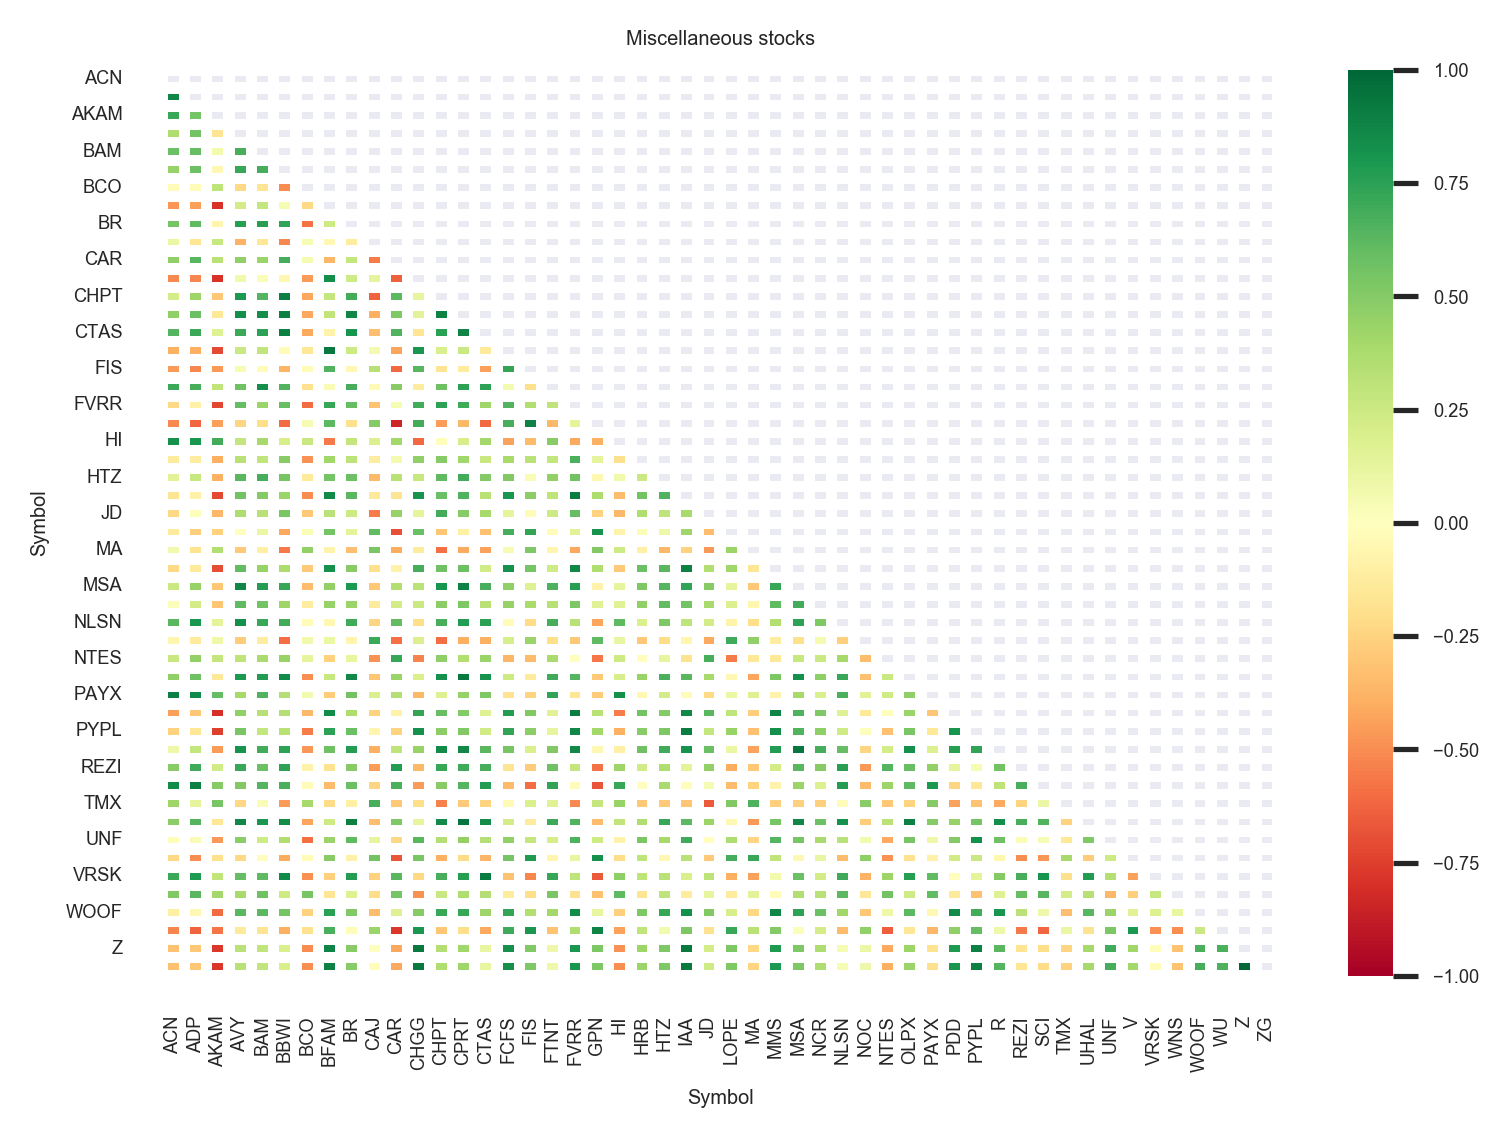

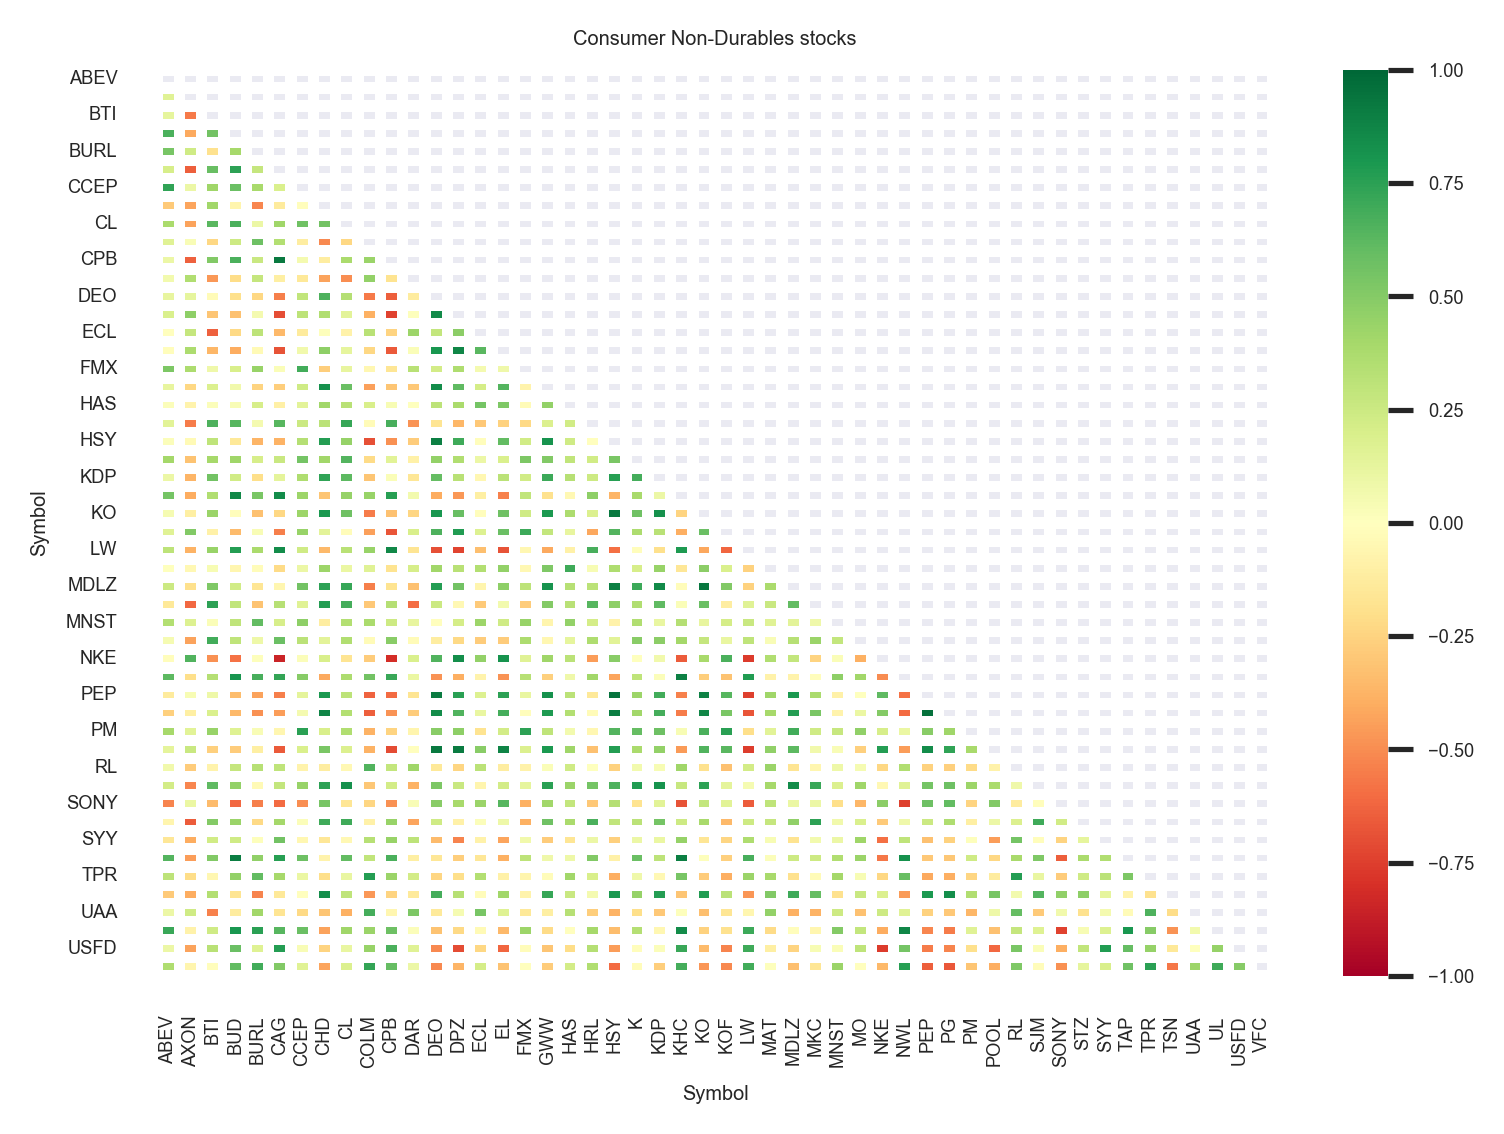

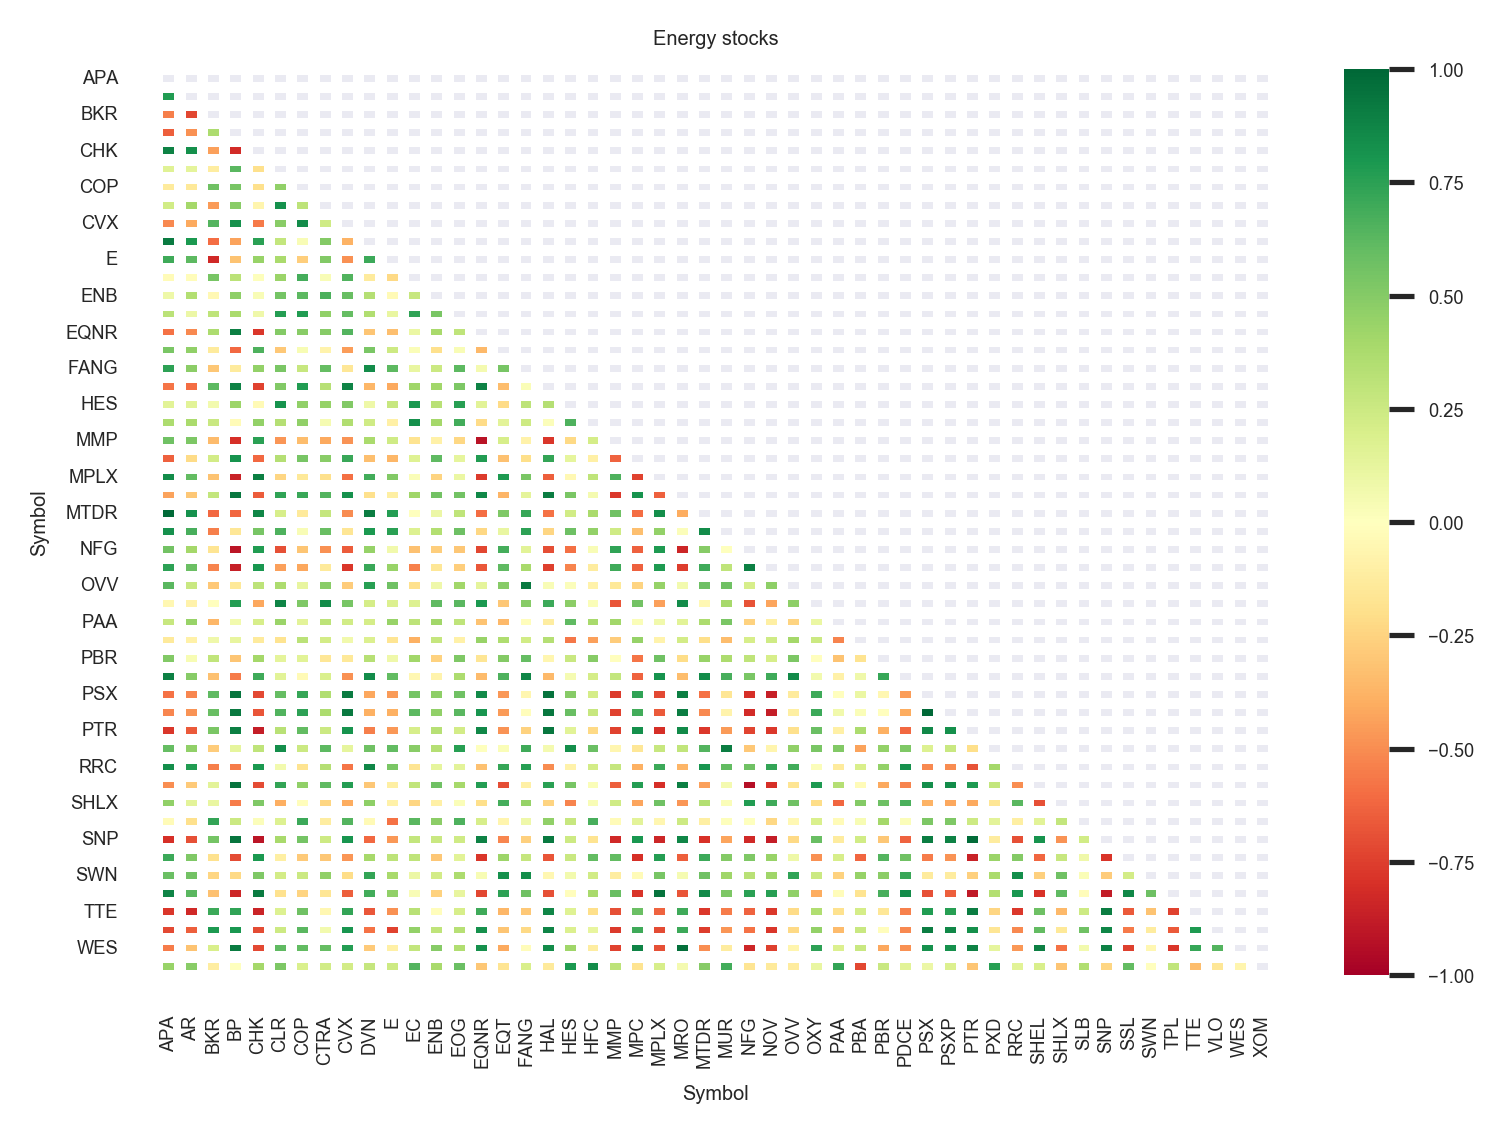

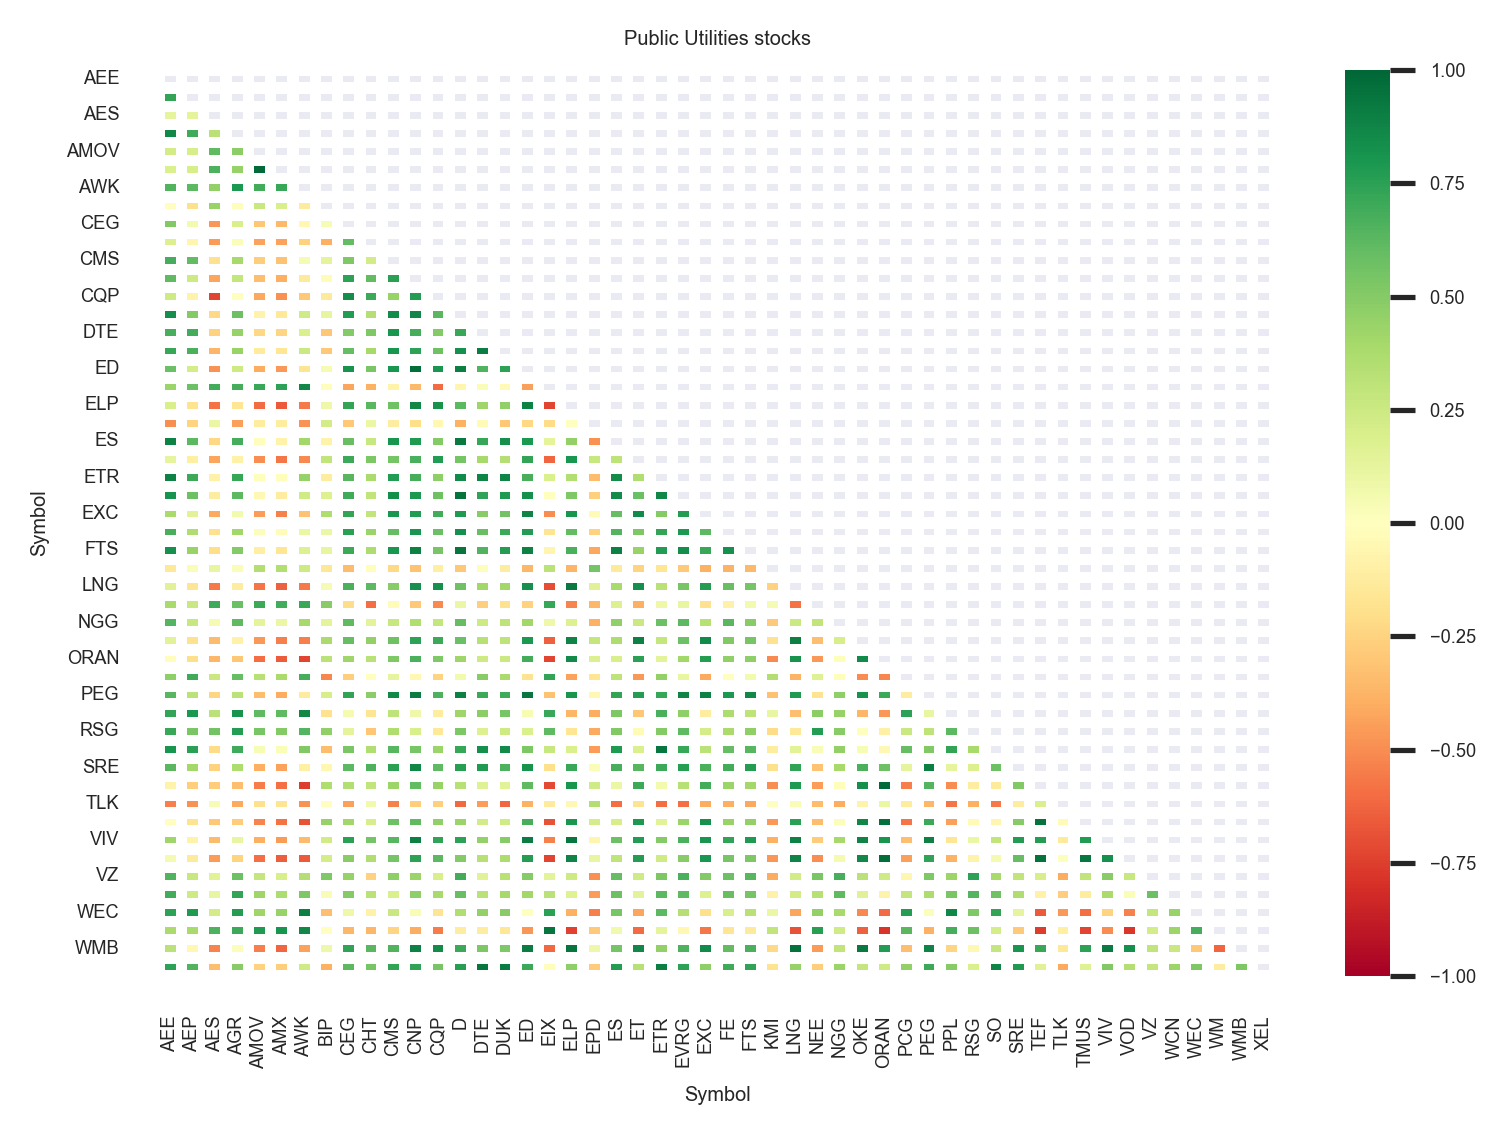

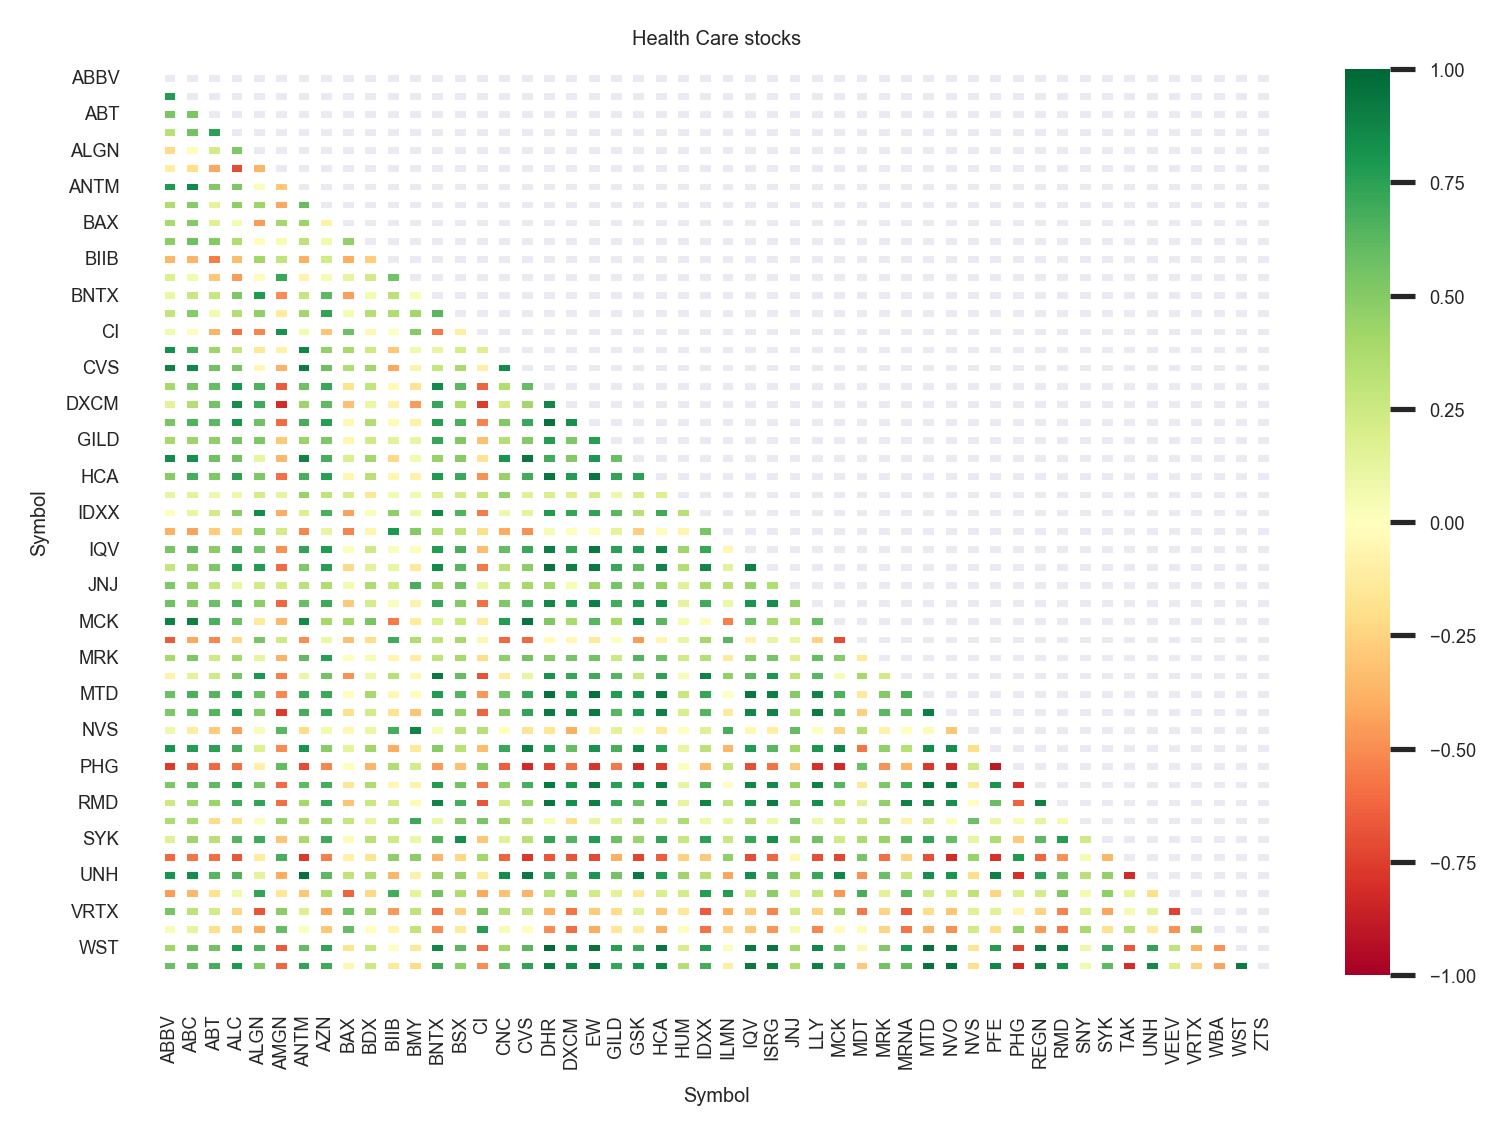

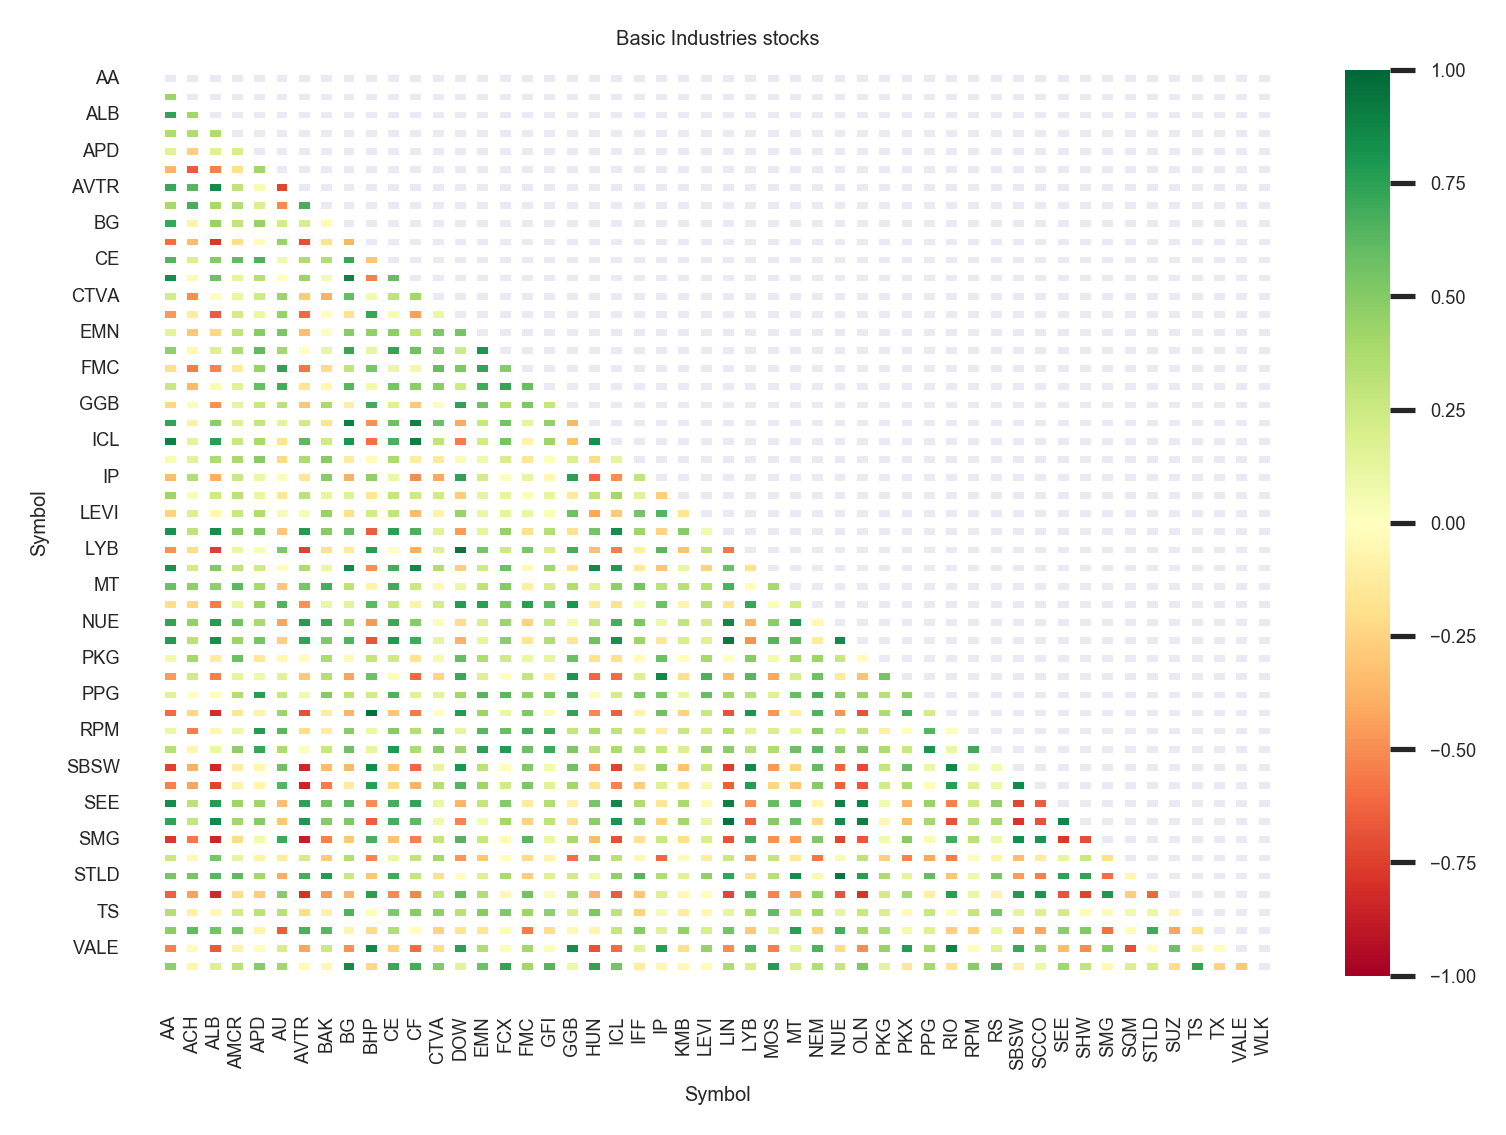

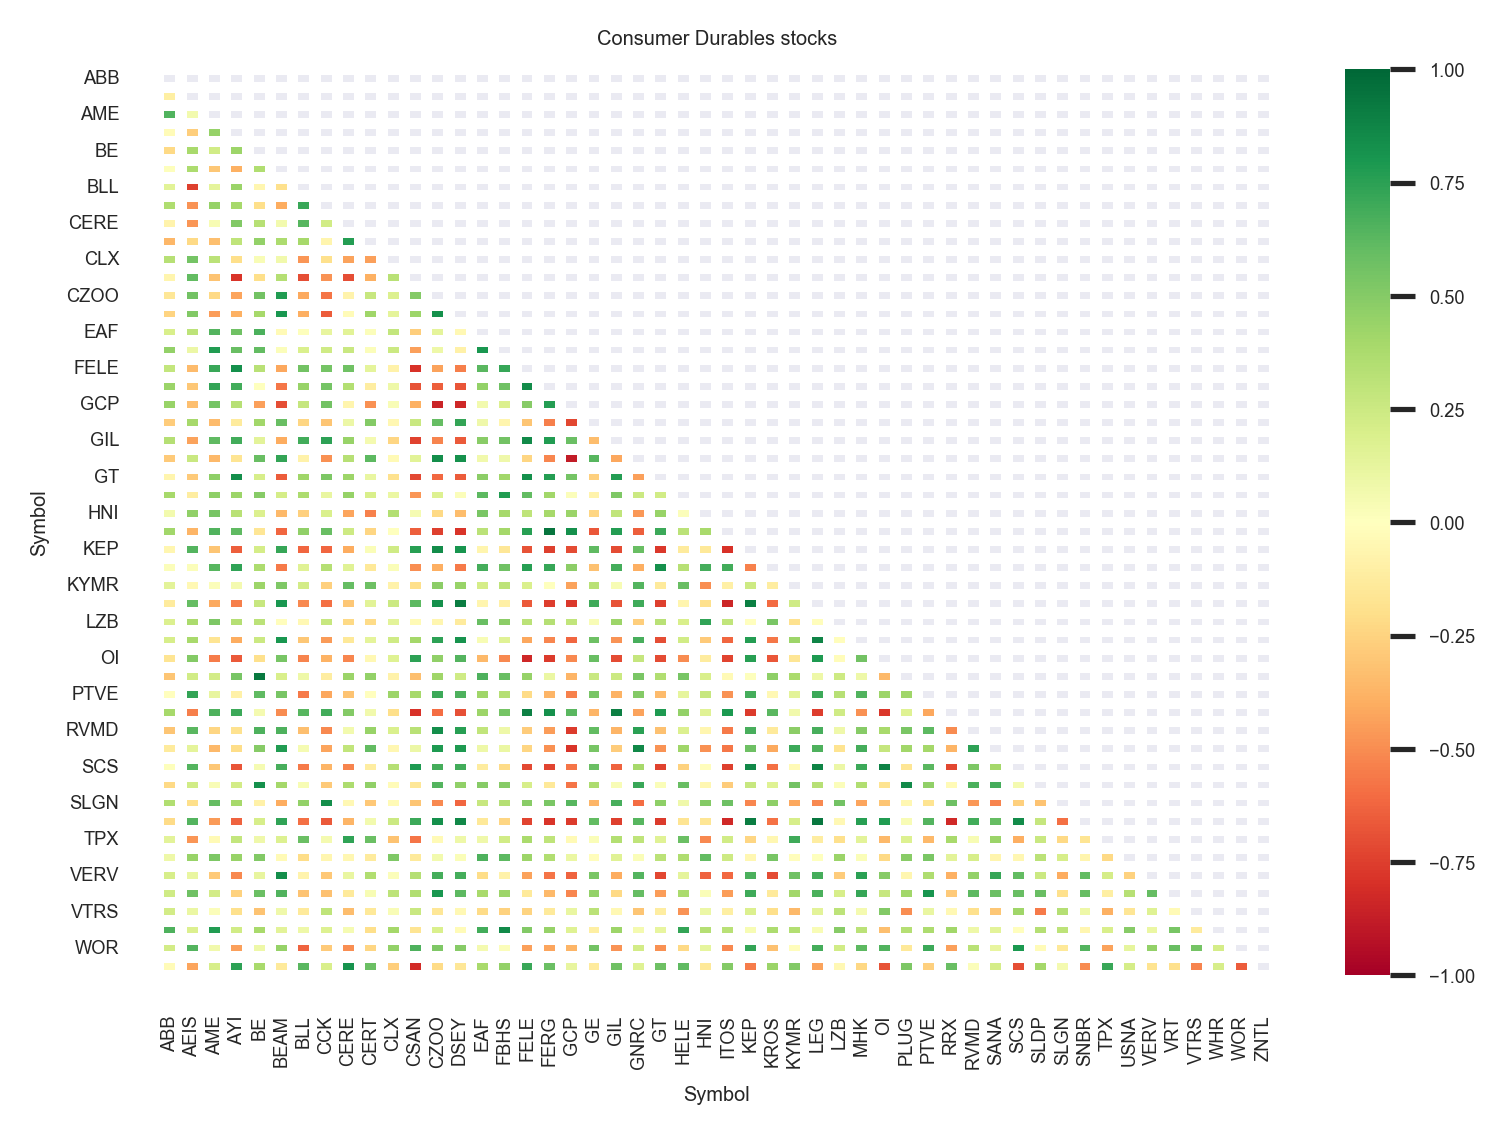

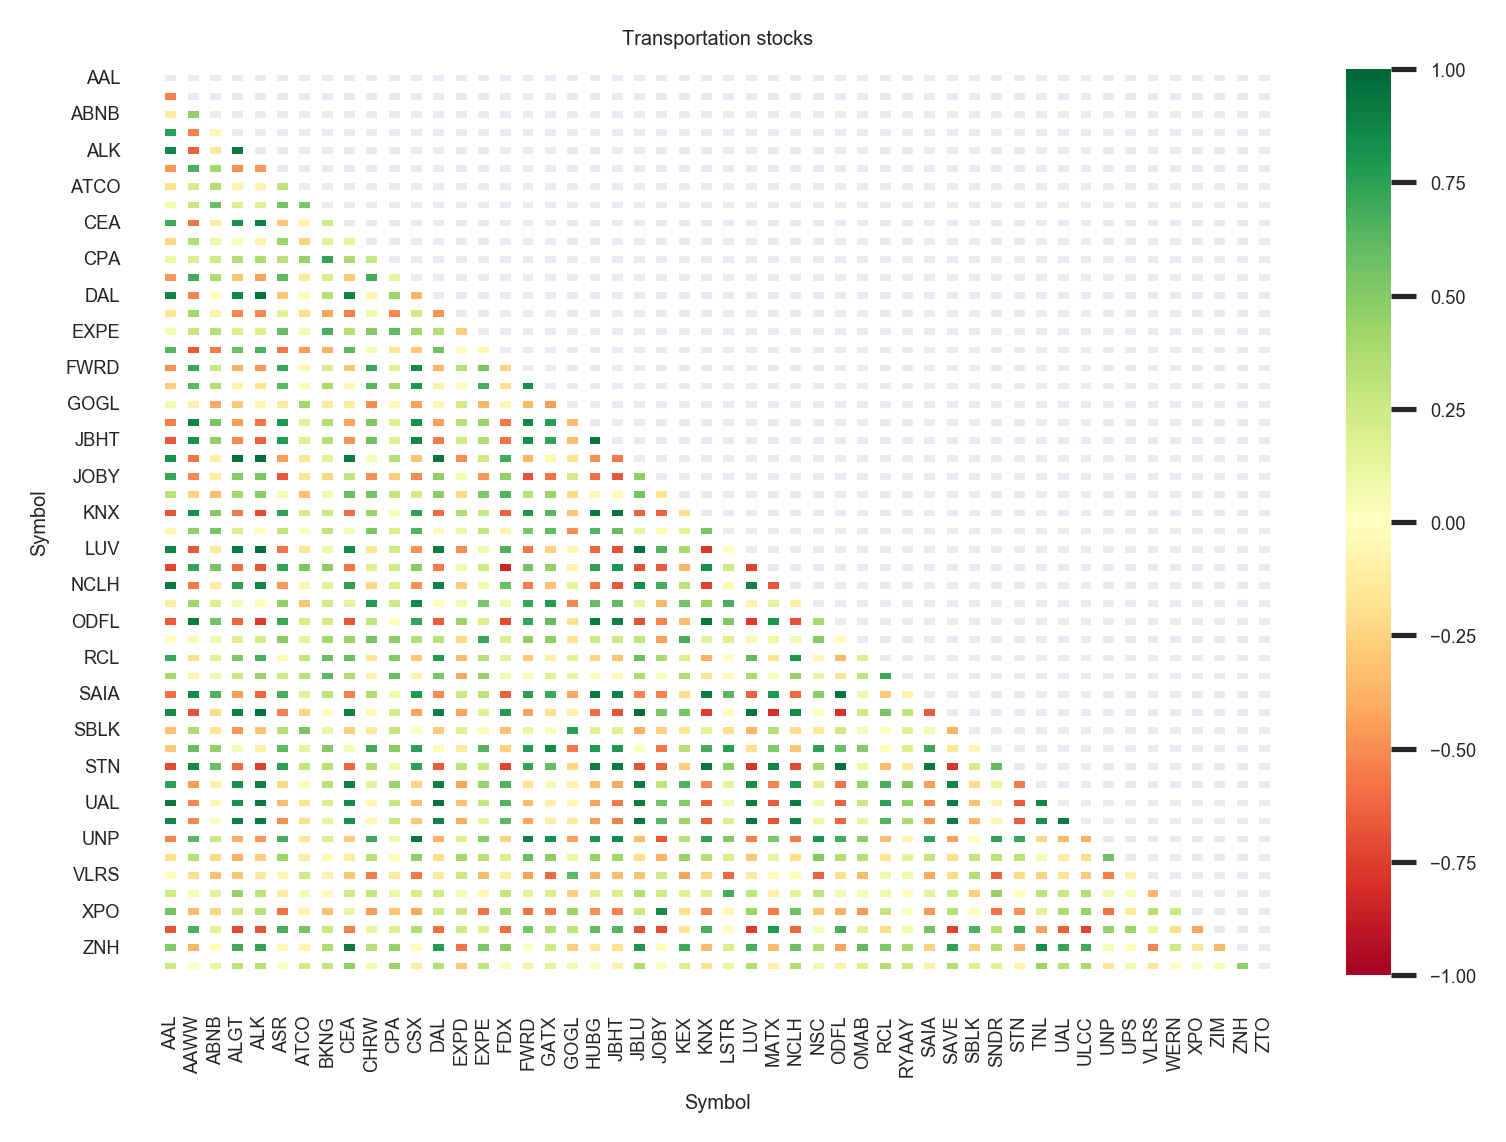

In [77]:
# take the bottom triangle since it repeats itself
counter = 0
for sector in sectors_set:
    if counter == 0:
        counter += 1
        continue
    data = dataframes[sector].corr(method='pearson')
    mask = np.zeros_like(data)

    mask[np.triu_indices_from(mask)] = True

    # generate plot
    seaborn.set(font_scale=0.4)

    seaborn.heatmap(data, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask, linewidths=2.5)
    plt.title(f"{sector} stocks")

    plt.yticks(rotation=0)

    plt.xticks(rotation=90)
    plt.savefig(f"{sector}.png")
    plt.show()

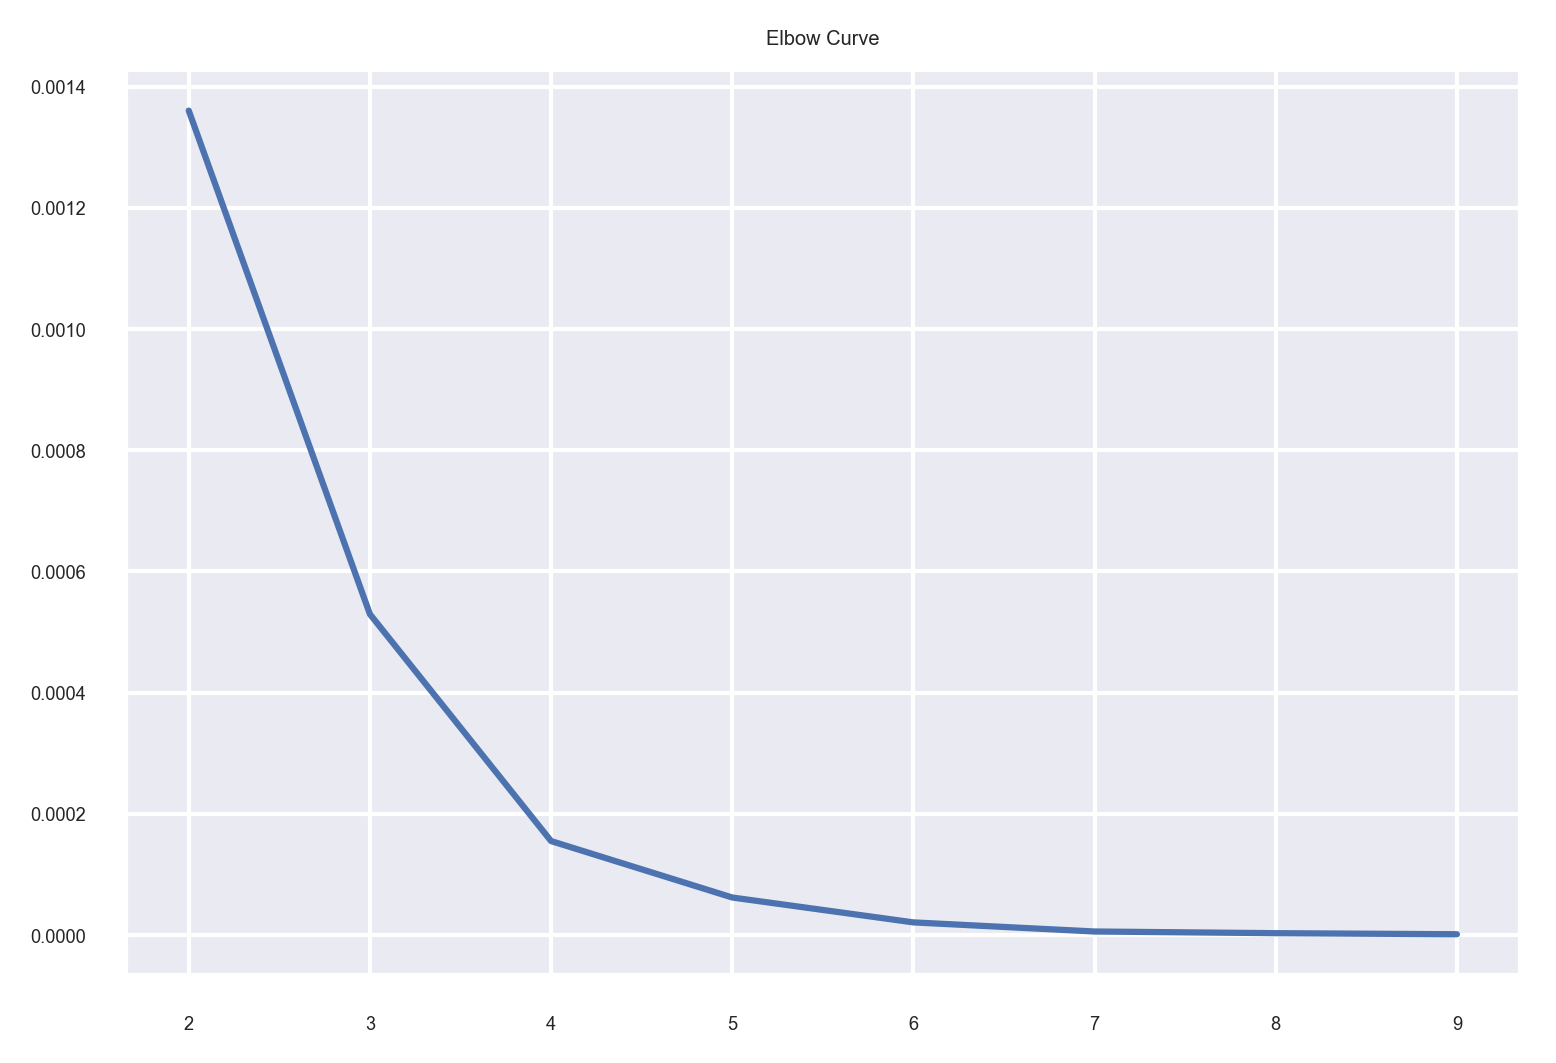

In [38]:
# import pandas as pd
# from sklearn.cluster import KMeans
# from math import sqrt
# import  pylab as pl
# import numpy as np
# 
# 
# data = dataframes['Basic Industries']
# returns = data.pct_change().mean() * N_STOCKS
# variance = data.pct_change().std() * np.sqrt(N_STOCKS)
# returns.columns = ["Returns"]
# variance.columns = ["Variance"]
# #Concatenating the returns and variances into a single data-frame
# ret_var = pd.concat([returns, variance], axis = 1).dropna()
# ret_var.columns = ["Returns","Variance"]
# X =  ret_var.values #Converting ret_var into nummpy array
# sse = []
# for k in range(2,N_STOCKS):
#     kmeans = KMeans(n_clusters = k)
#     kmeans.fit(X)
# 
#     sse.append(kmeans.inertia_) #SSE for each n_clusters
# pl.plot(range(2,N_STOCKS), sse)
# pl.title("Elbow Curve")
# pl.show()

####### undefined #########
####### Technology #########
####### Consumer Services #########
####### Finance #########
####### Capital Goods #########
####### Miscellaneous #########
####### Consumer Non-Durables #########
####### Energy #########
####### Public Utilities #########
####### Health Care #########
####### Basic Industries #########
####### Consumer Durables #########
####### Transportation #########


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an

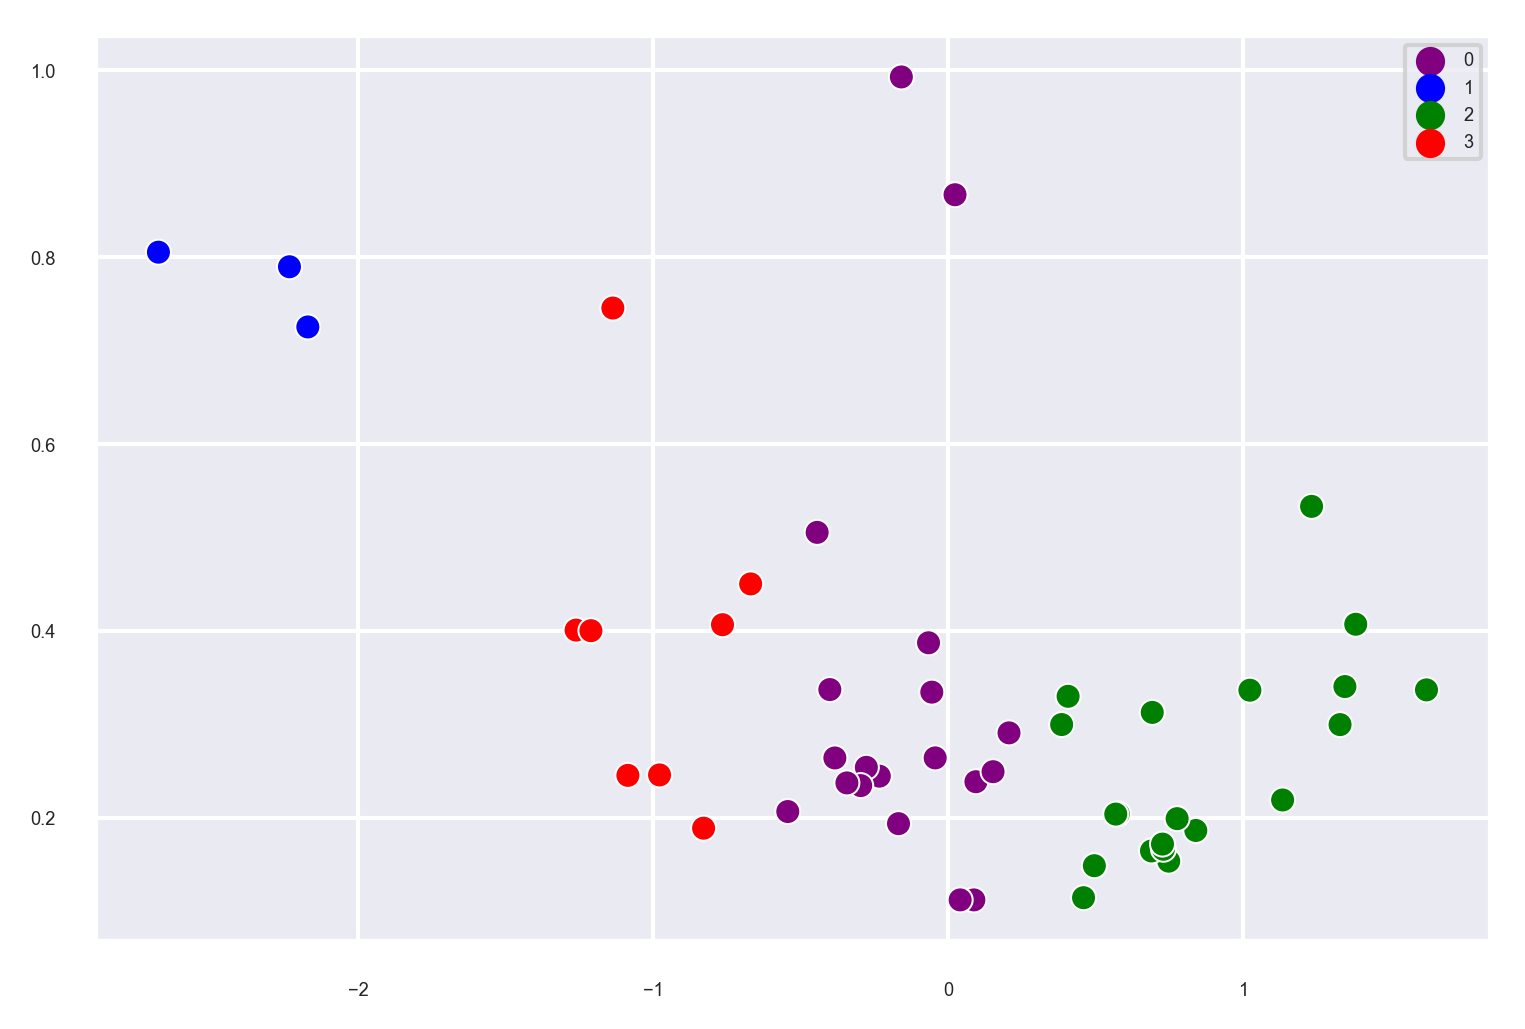

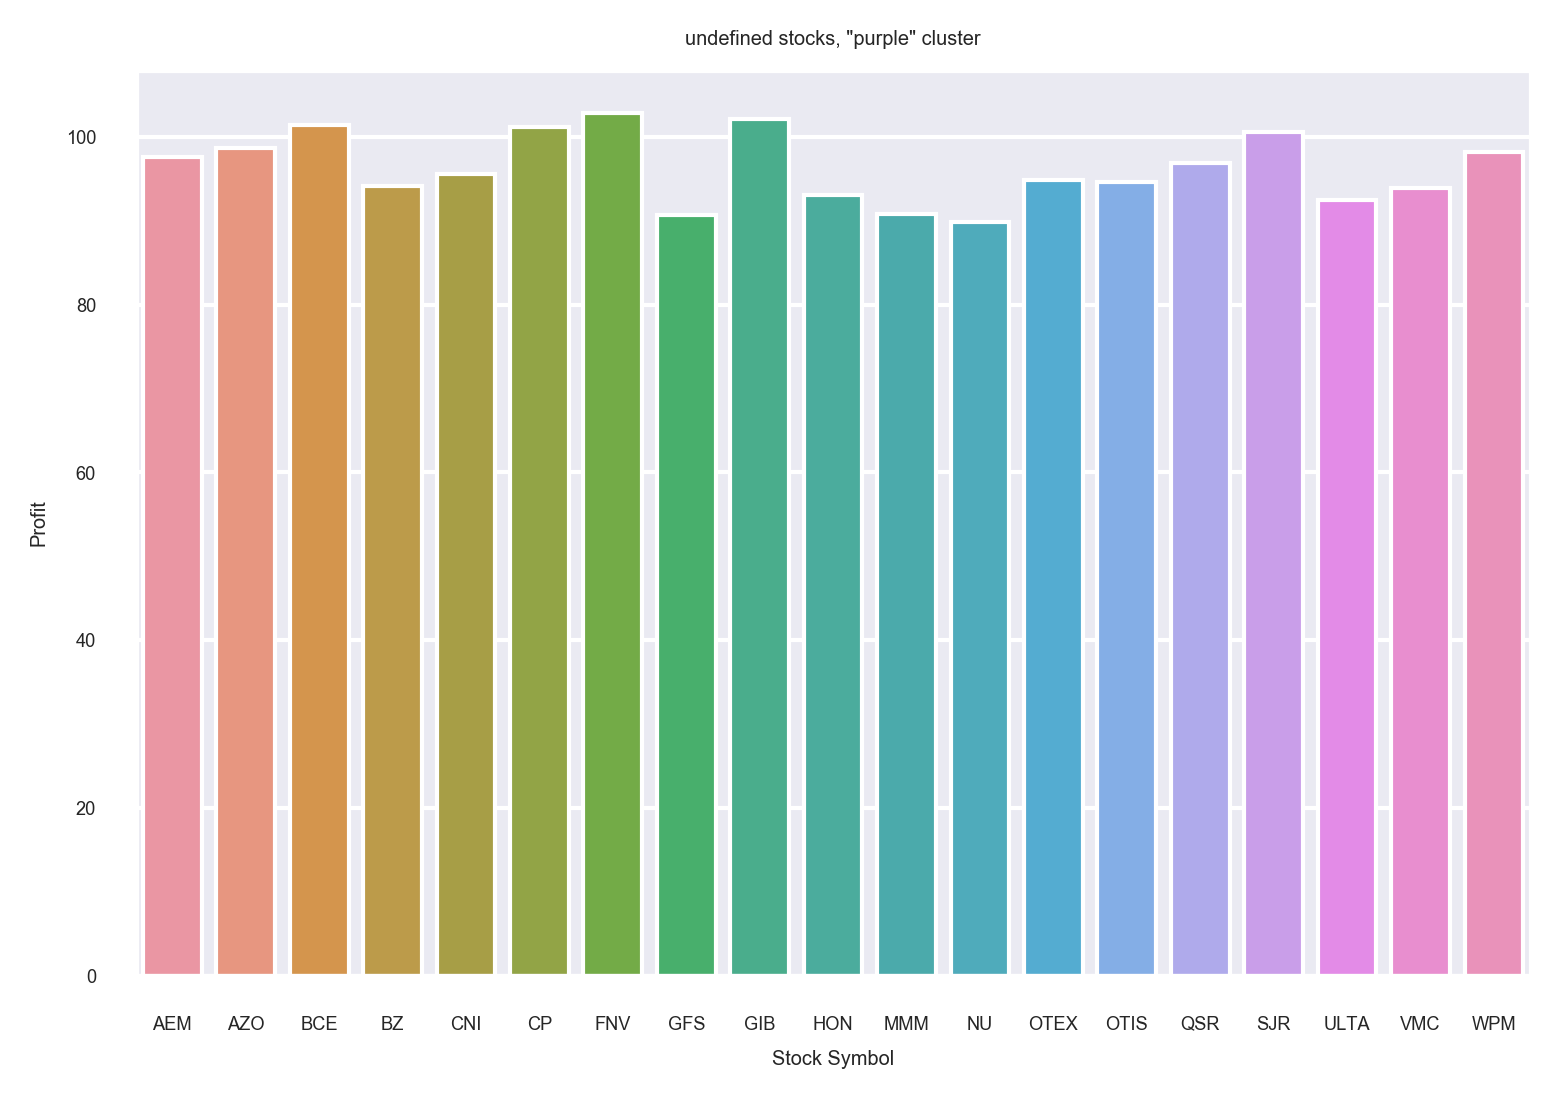

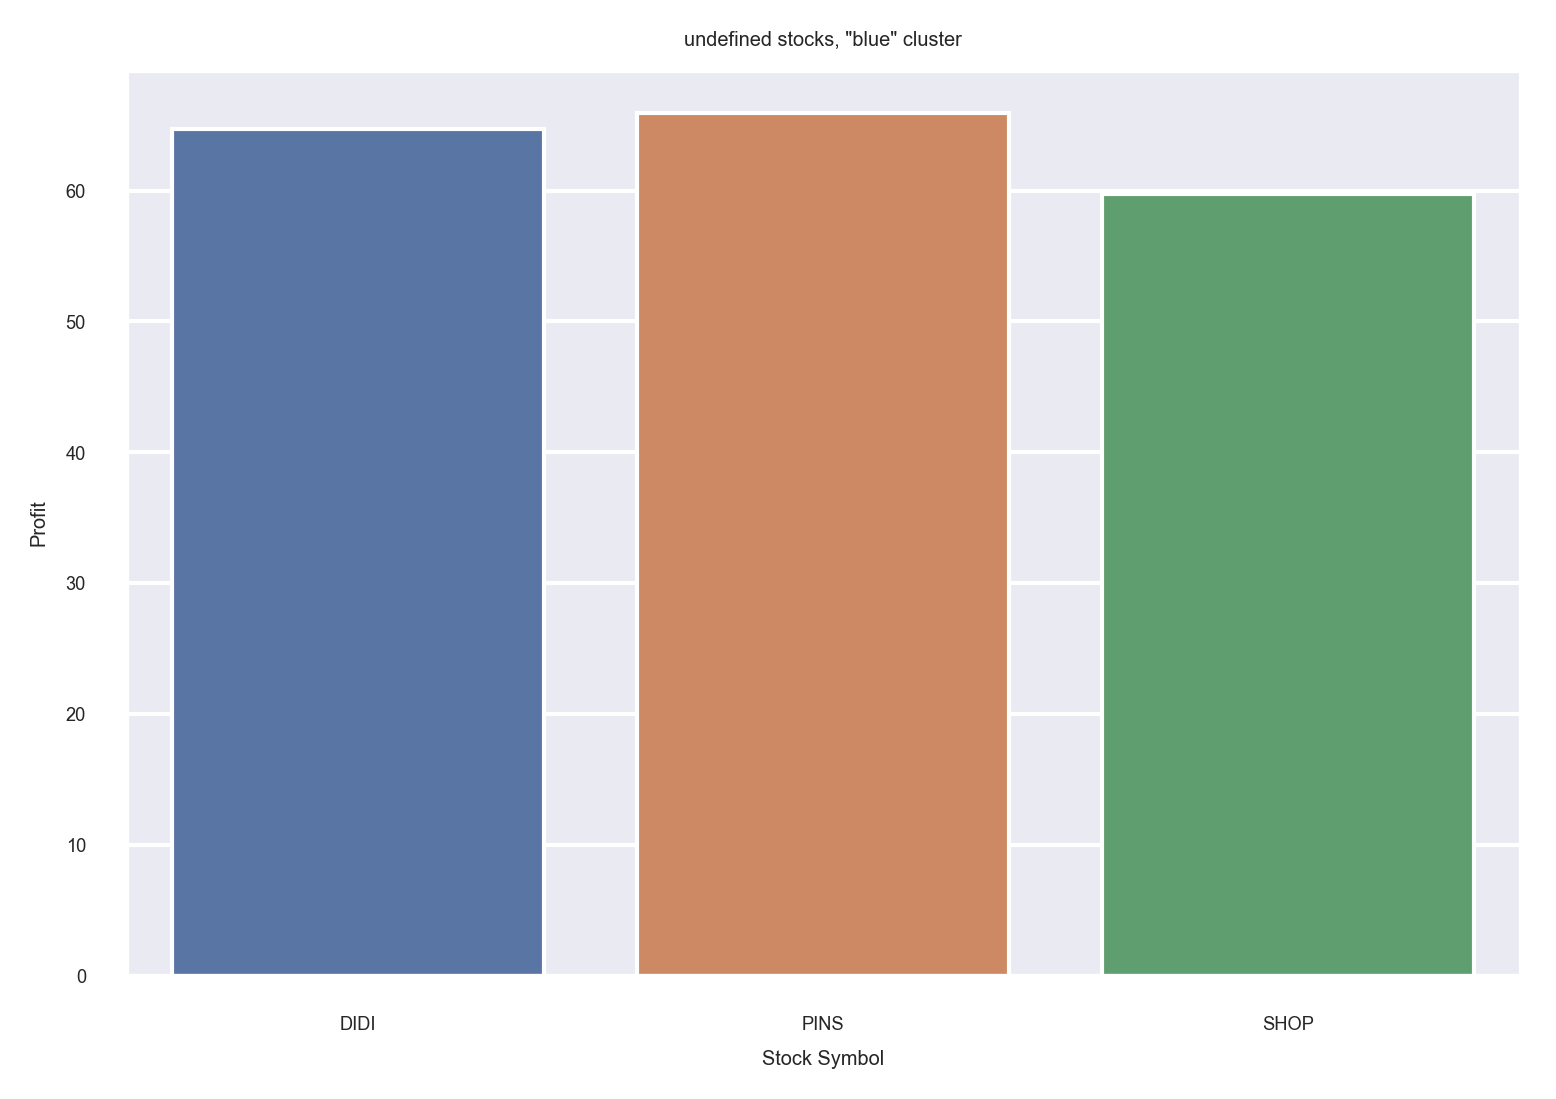

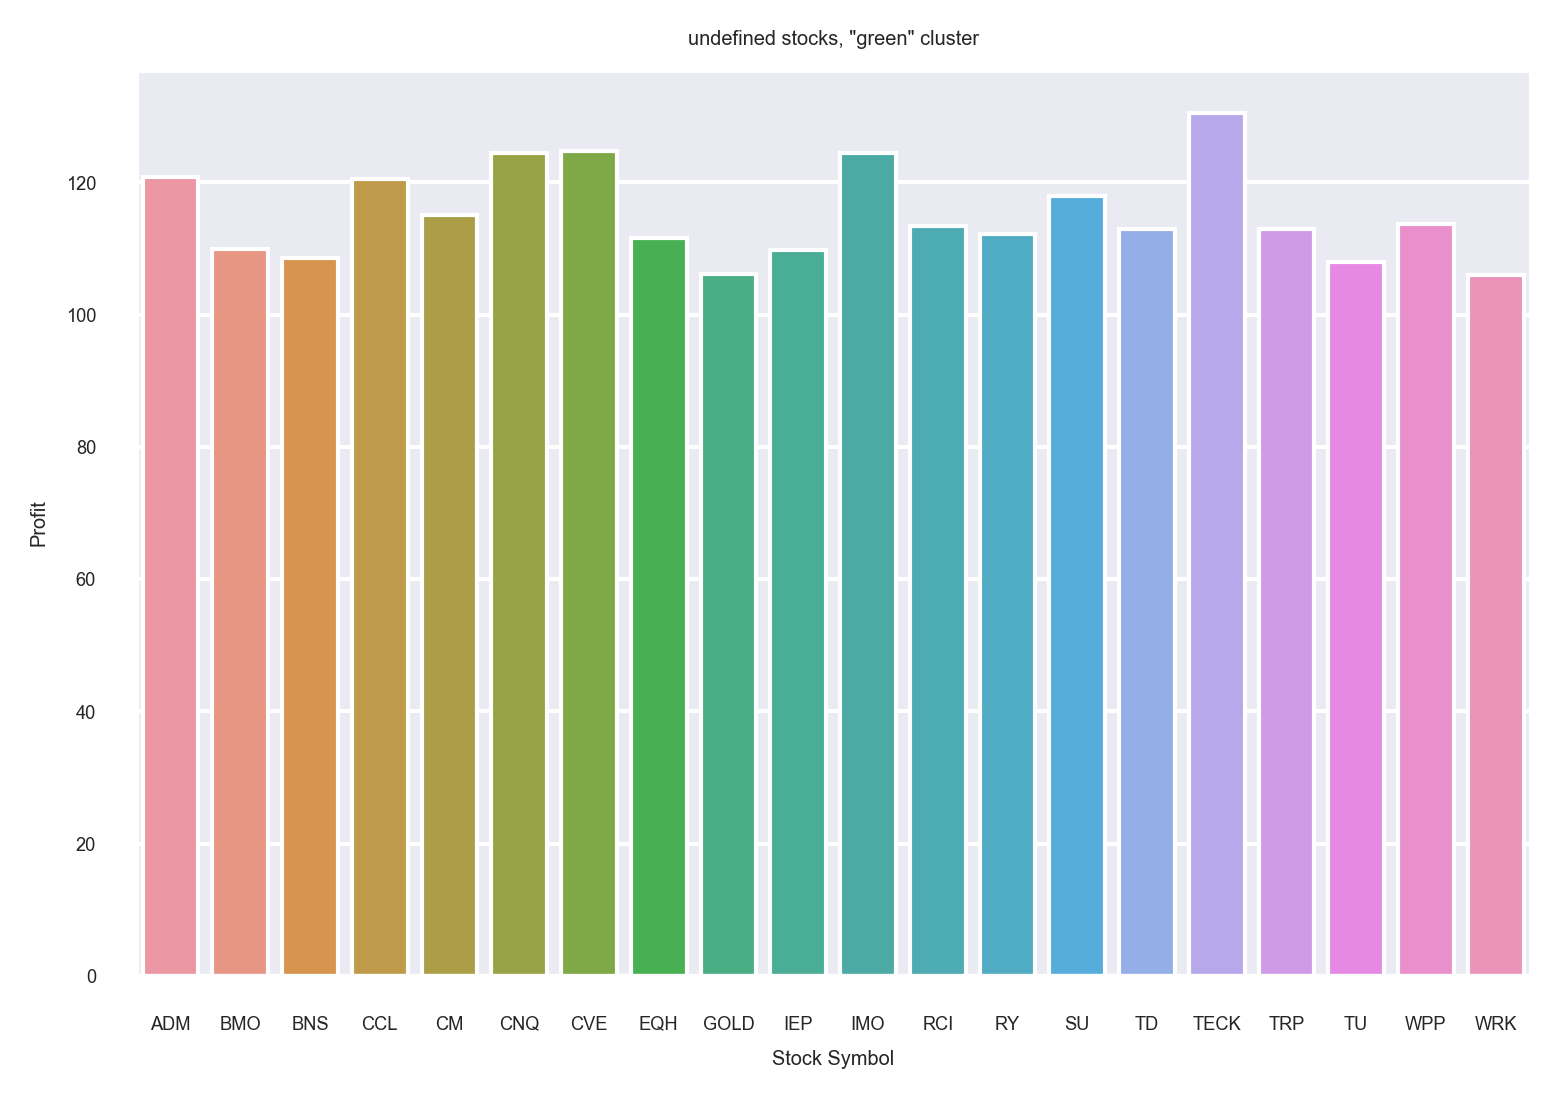

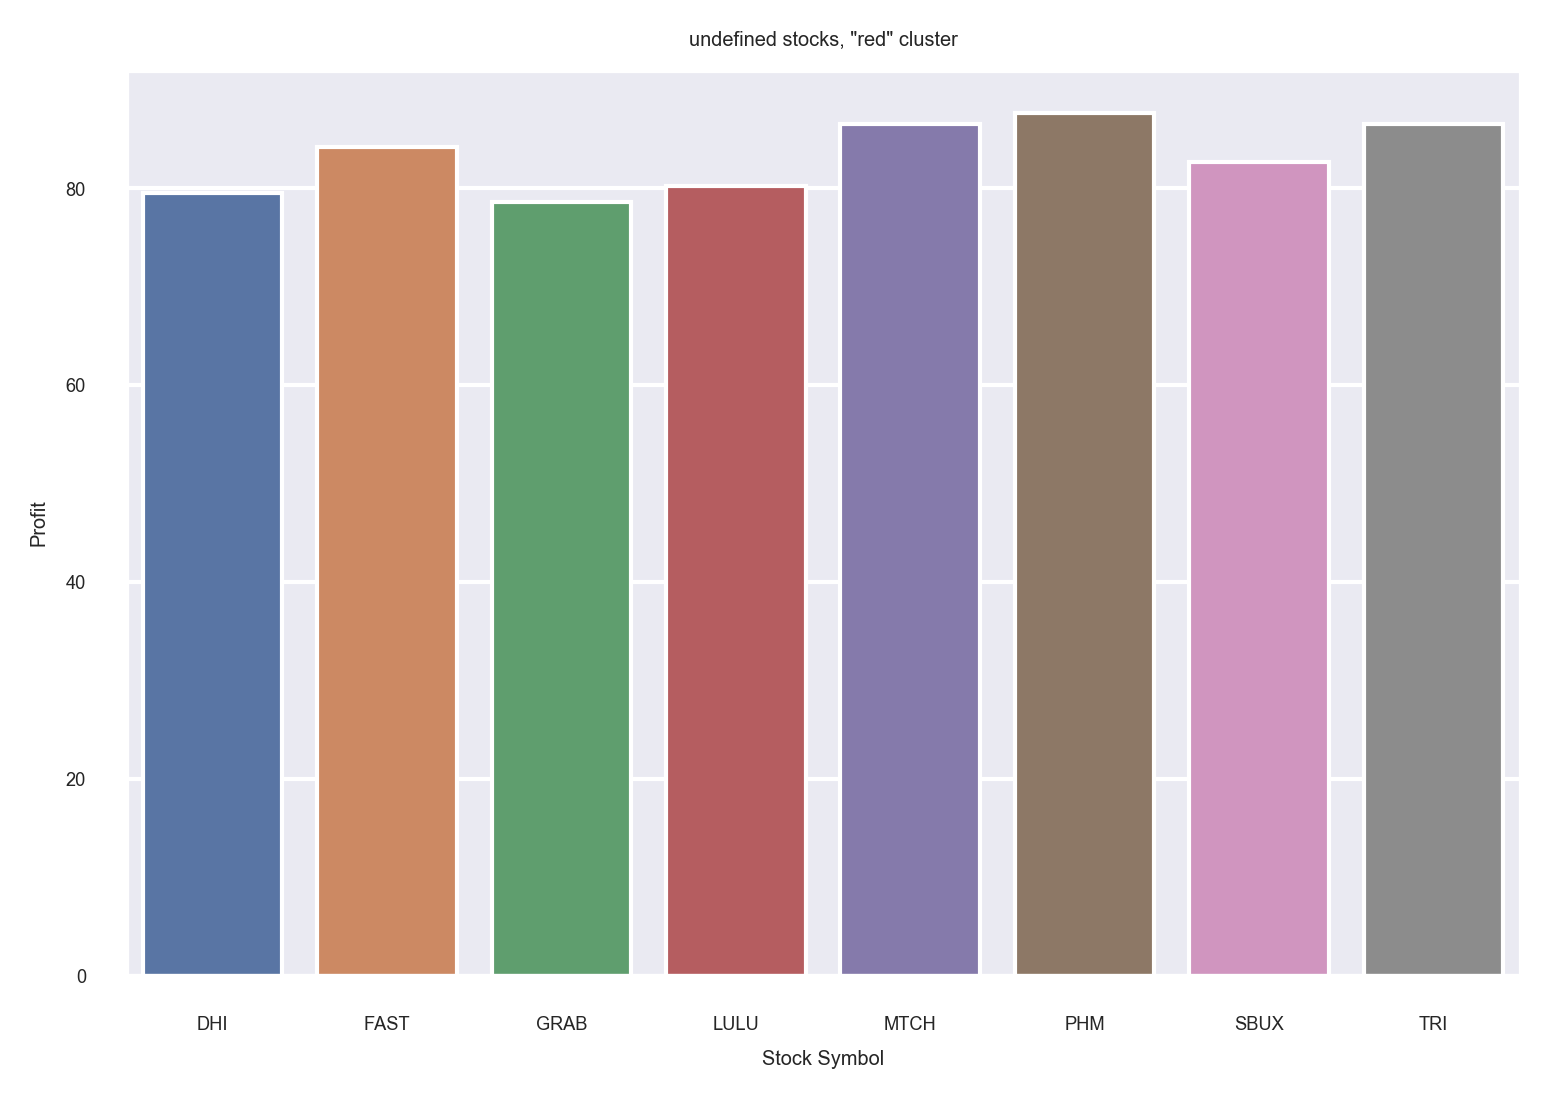

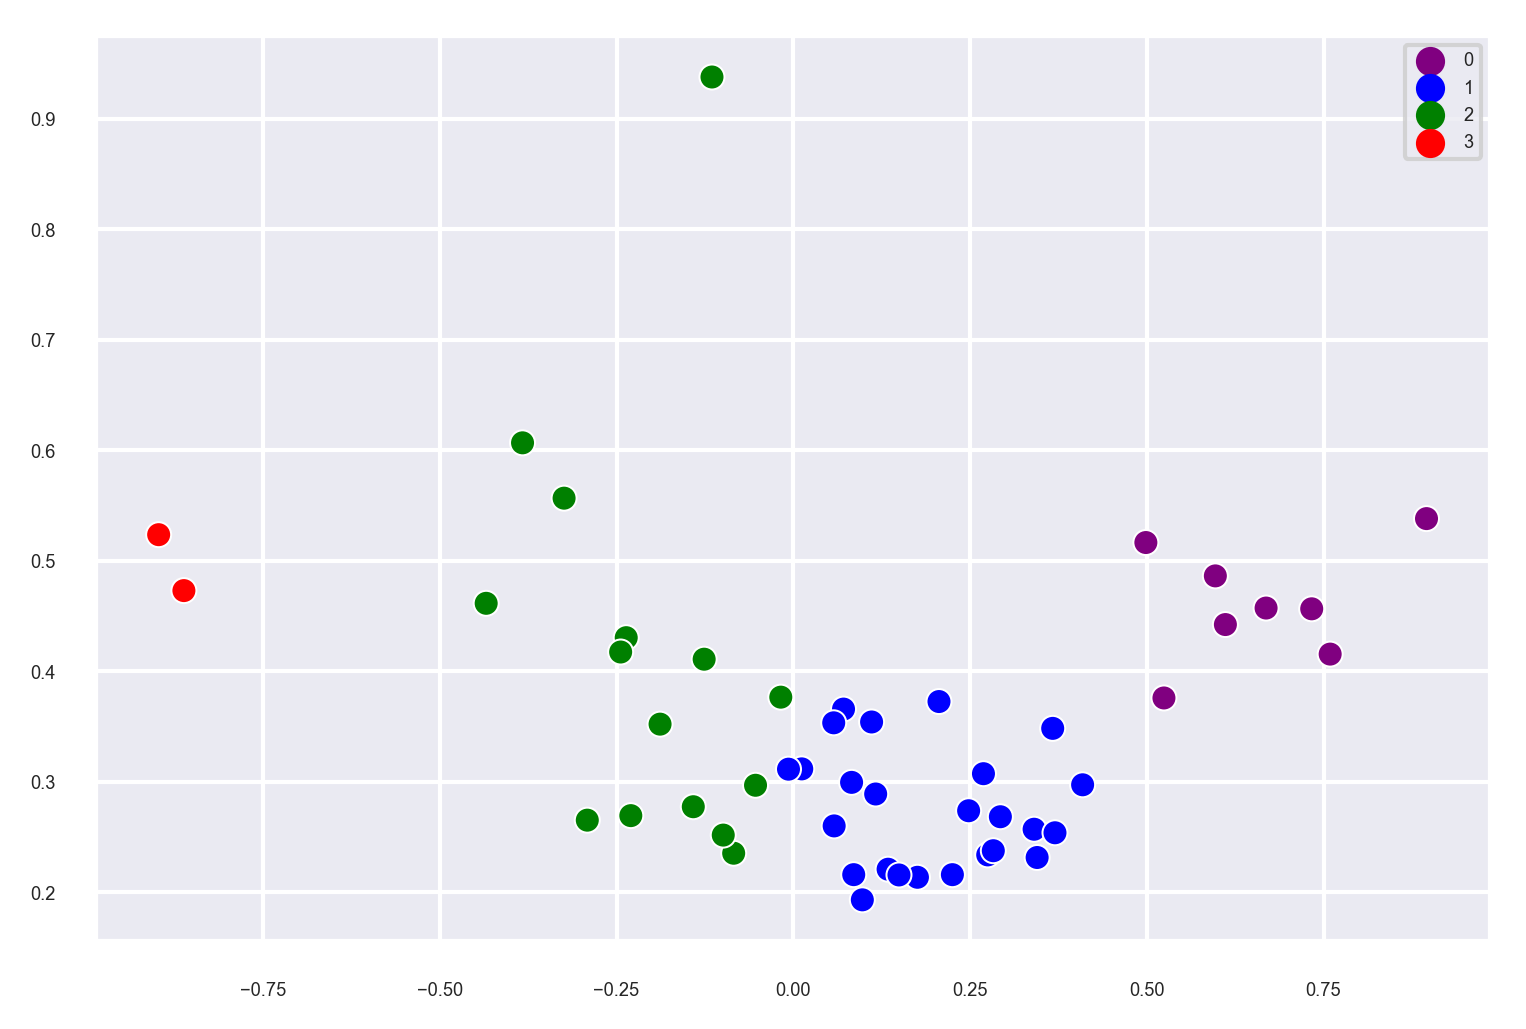

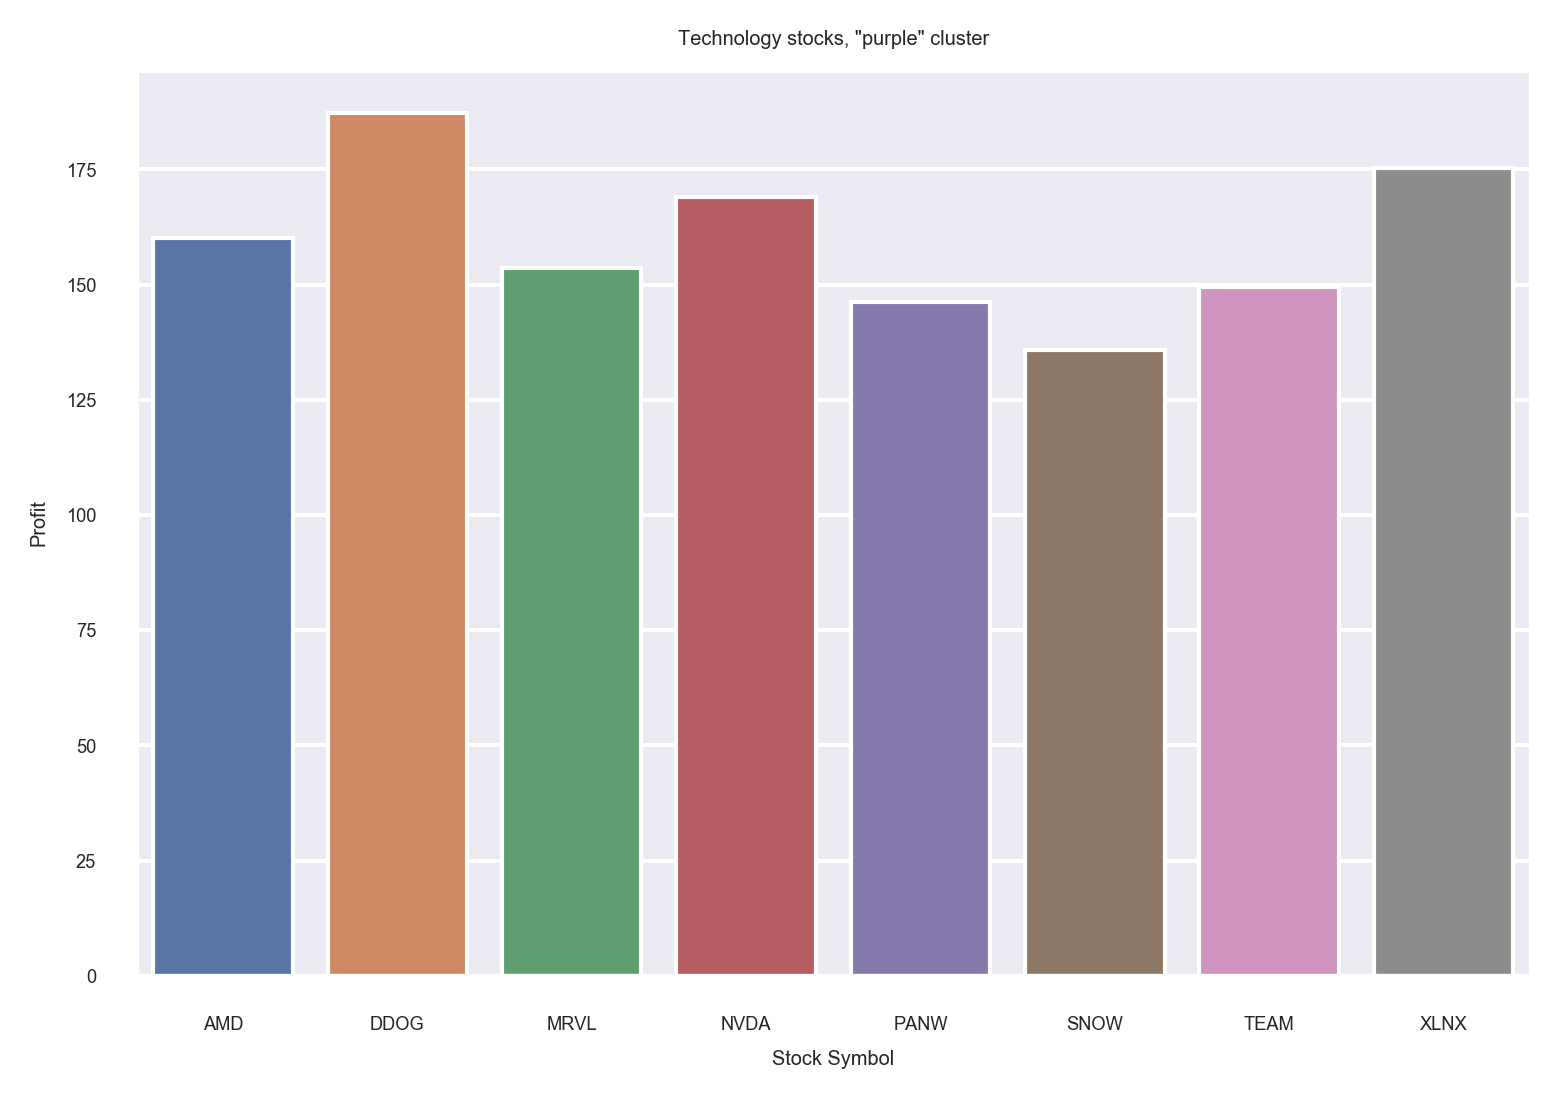

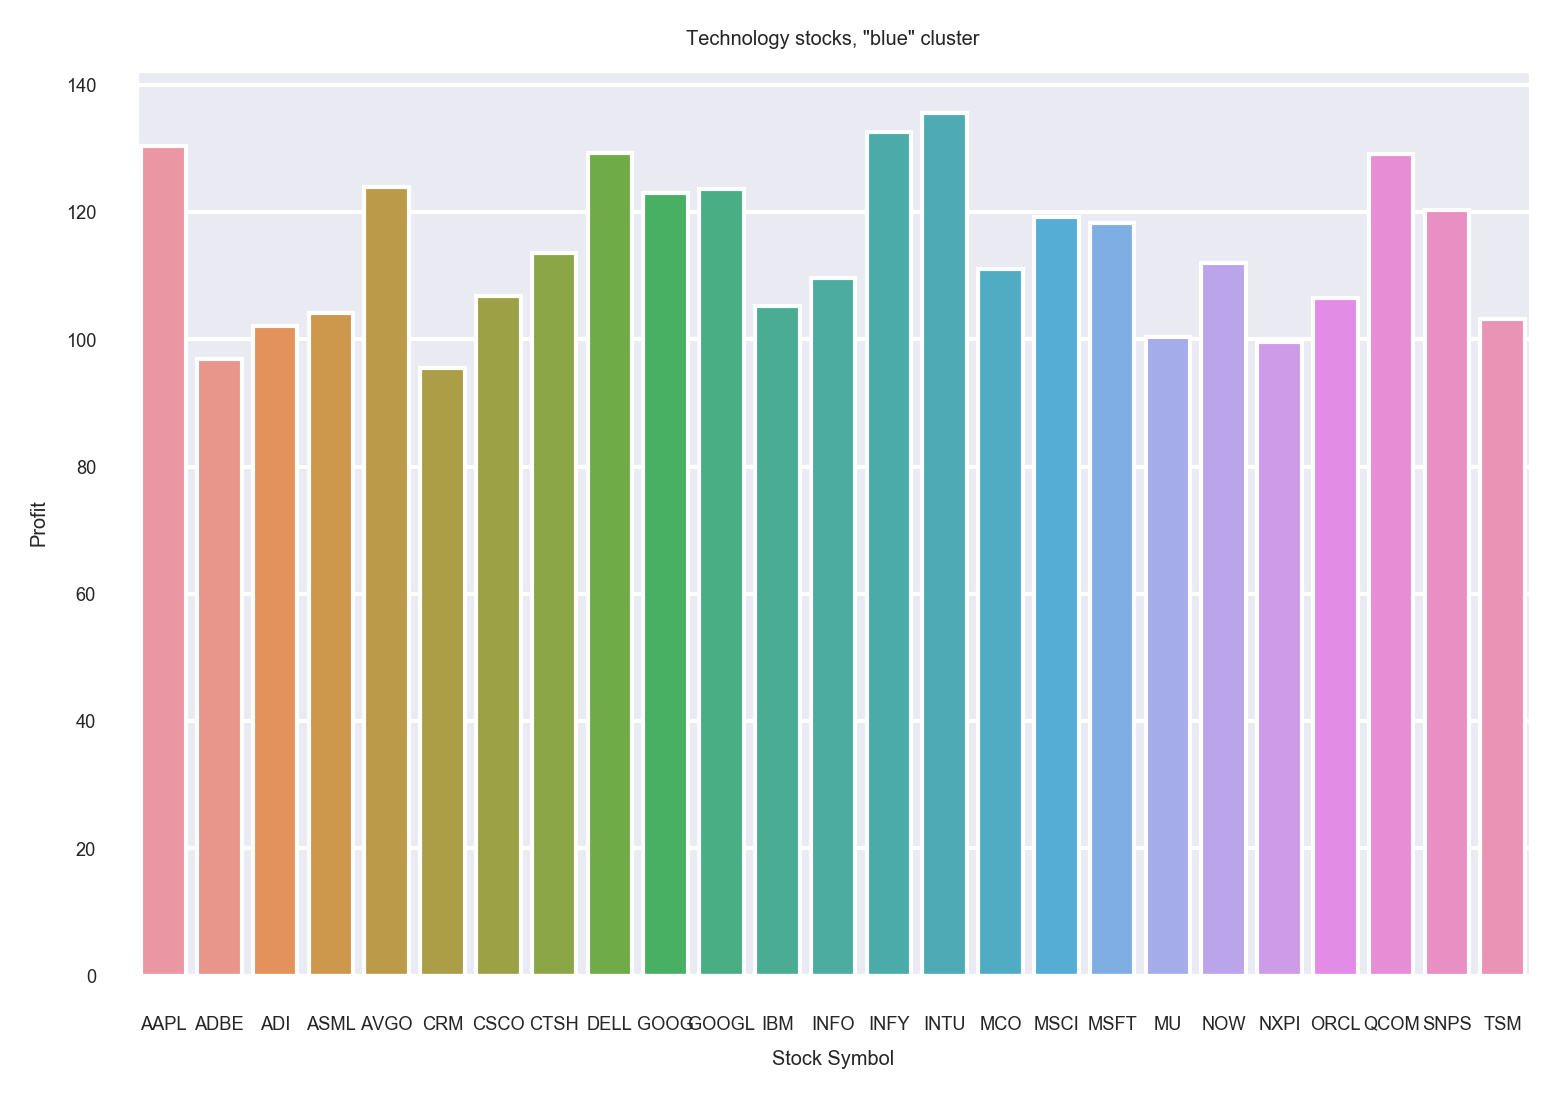

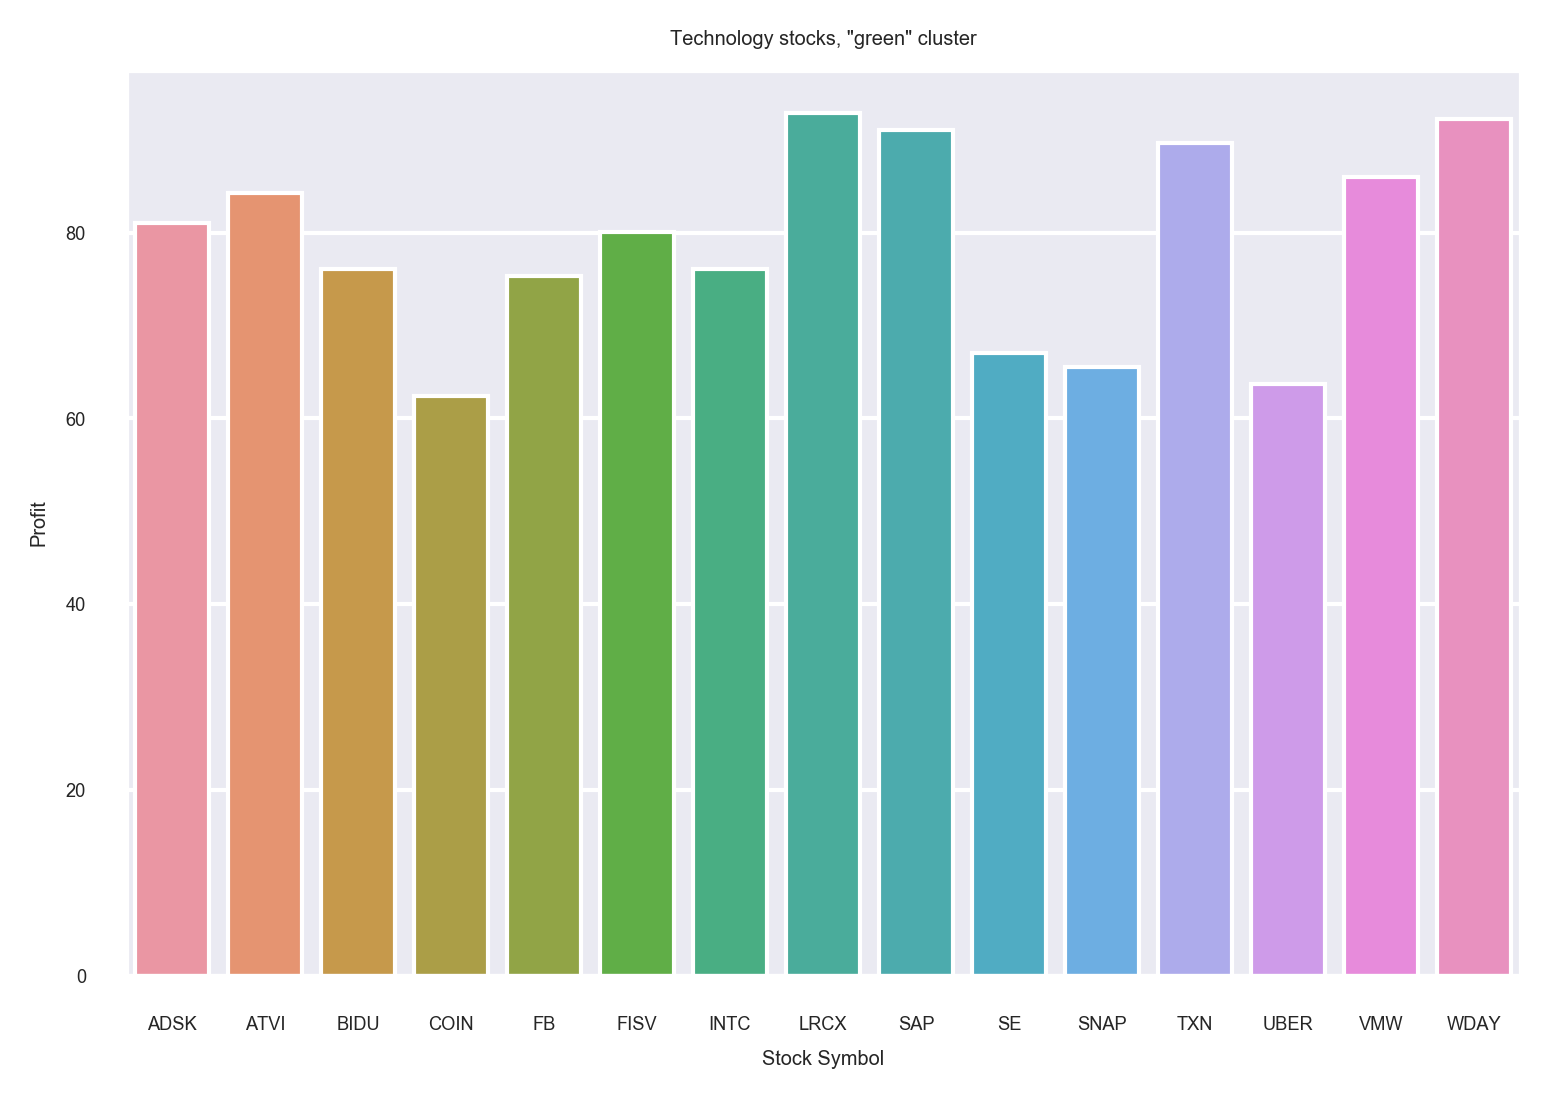

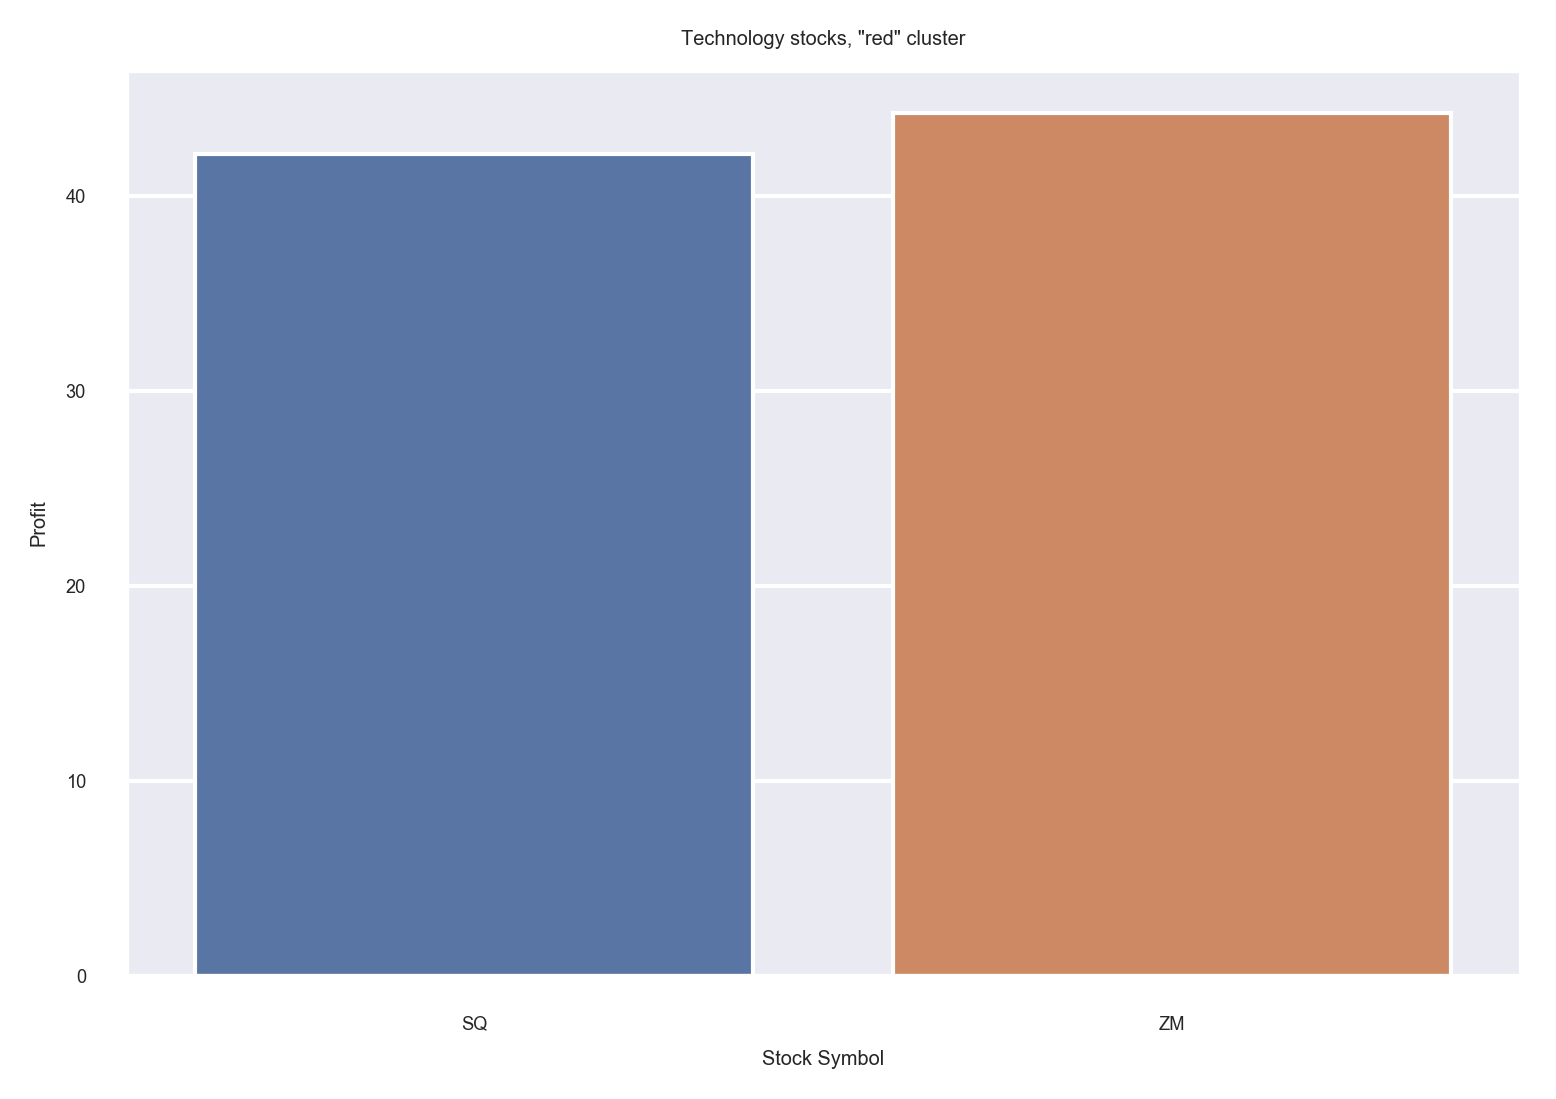

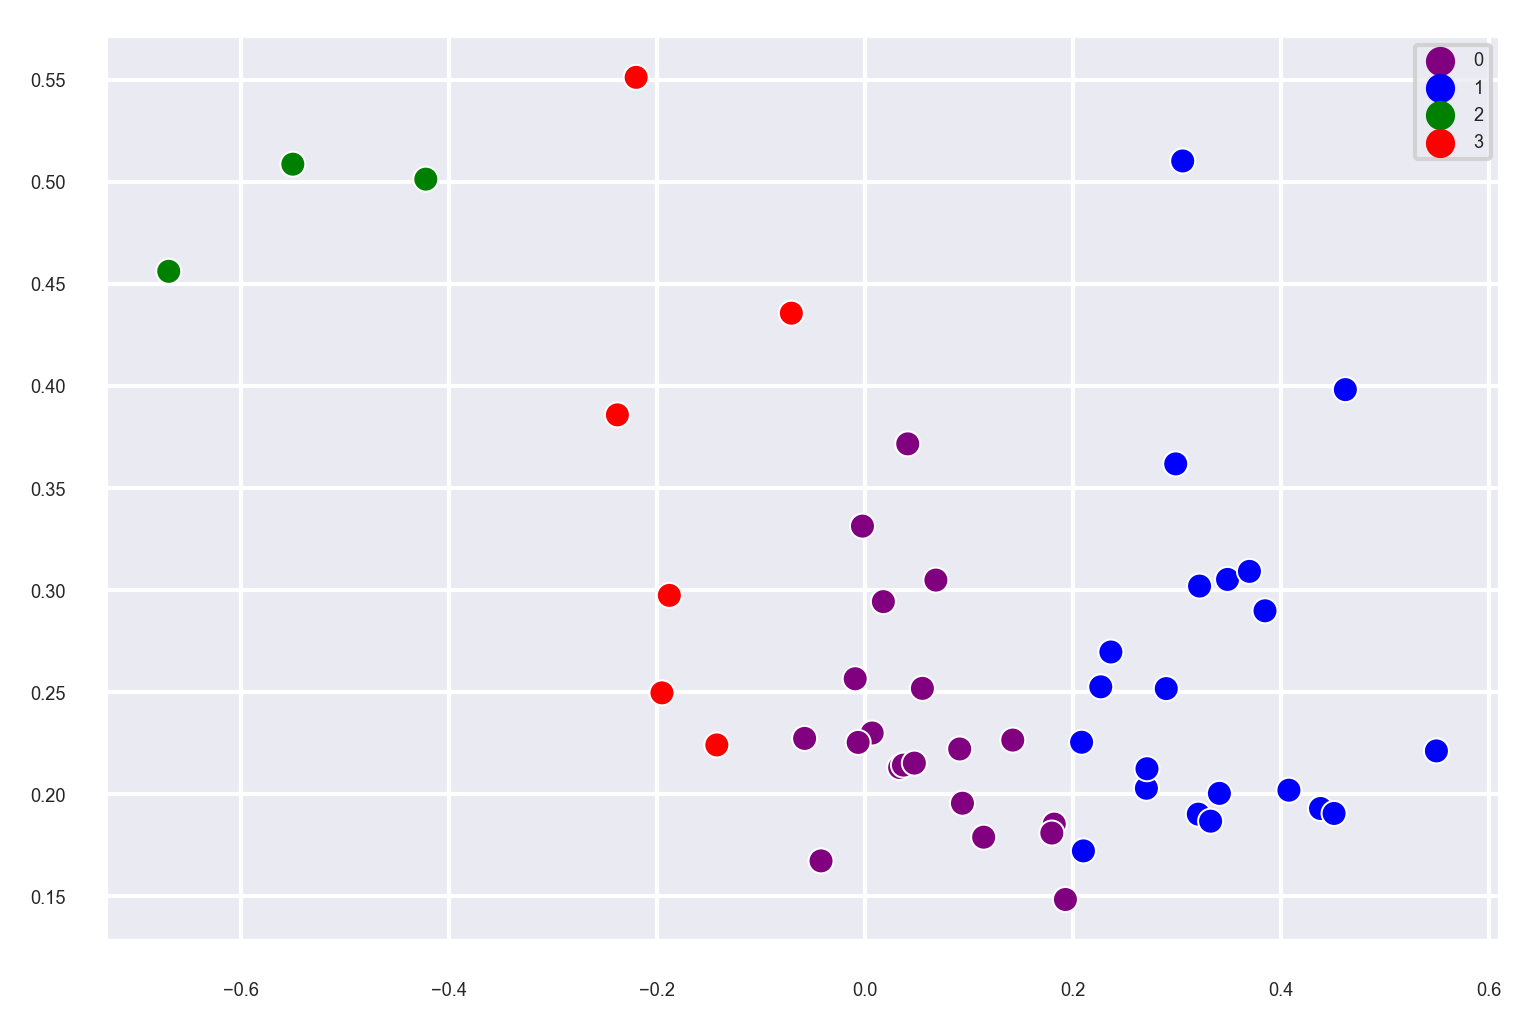

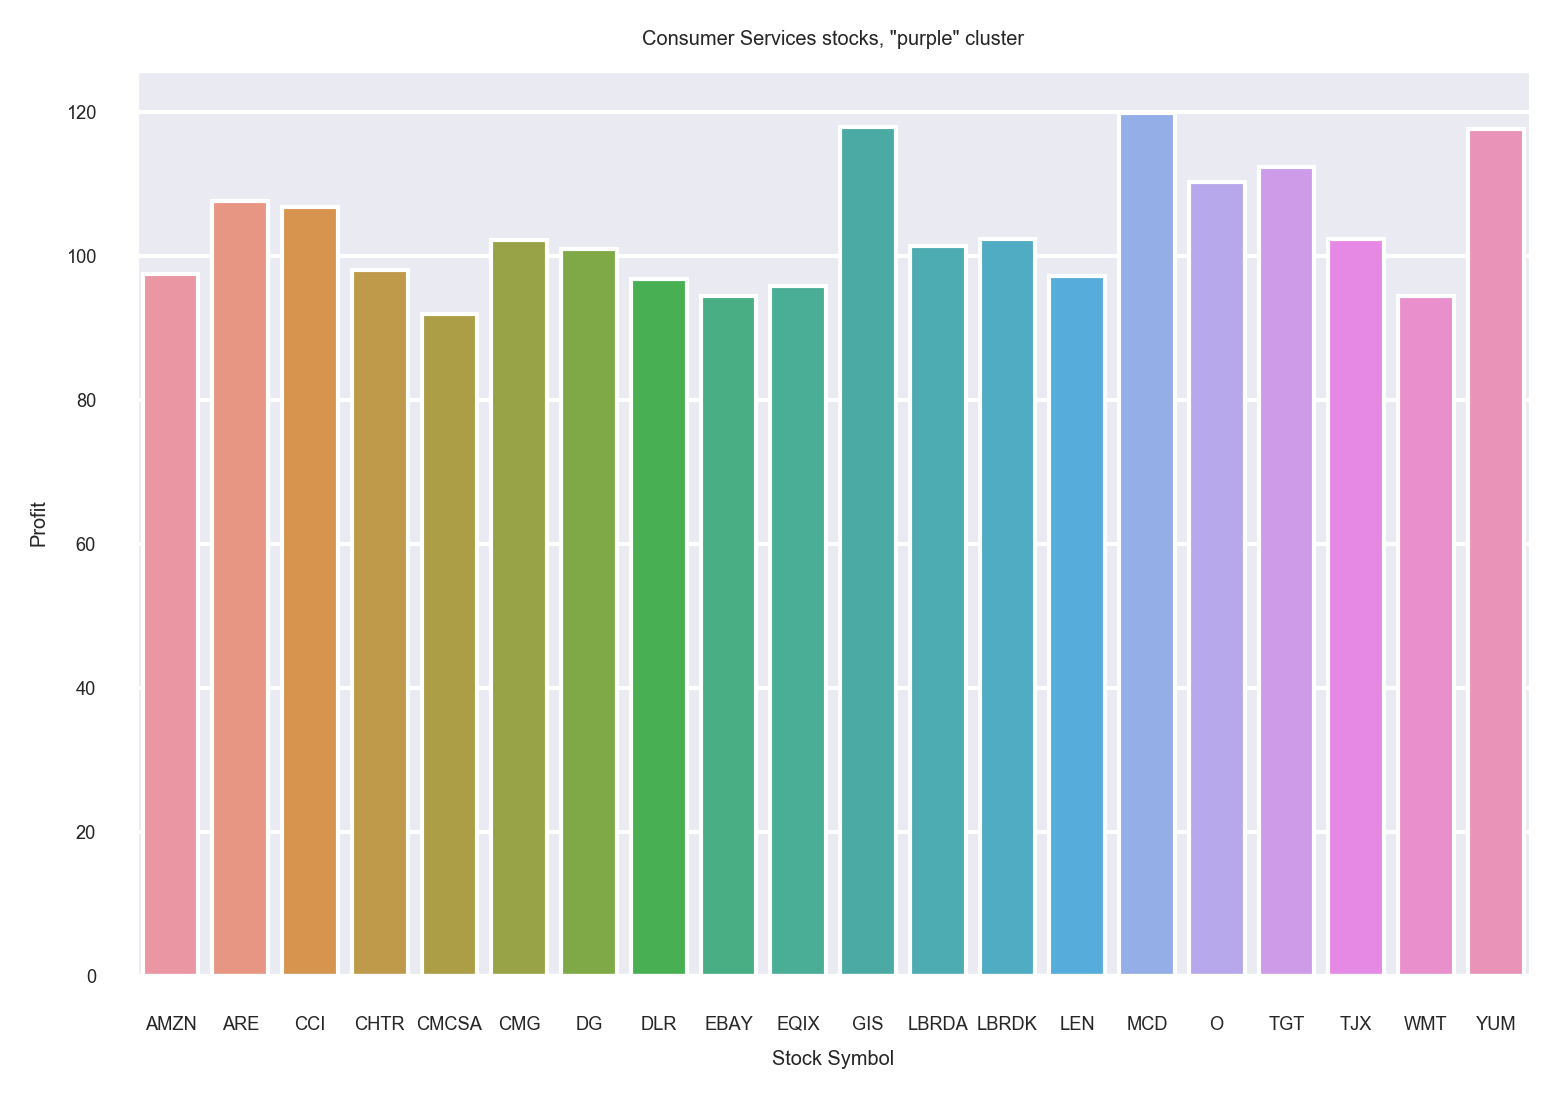

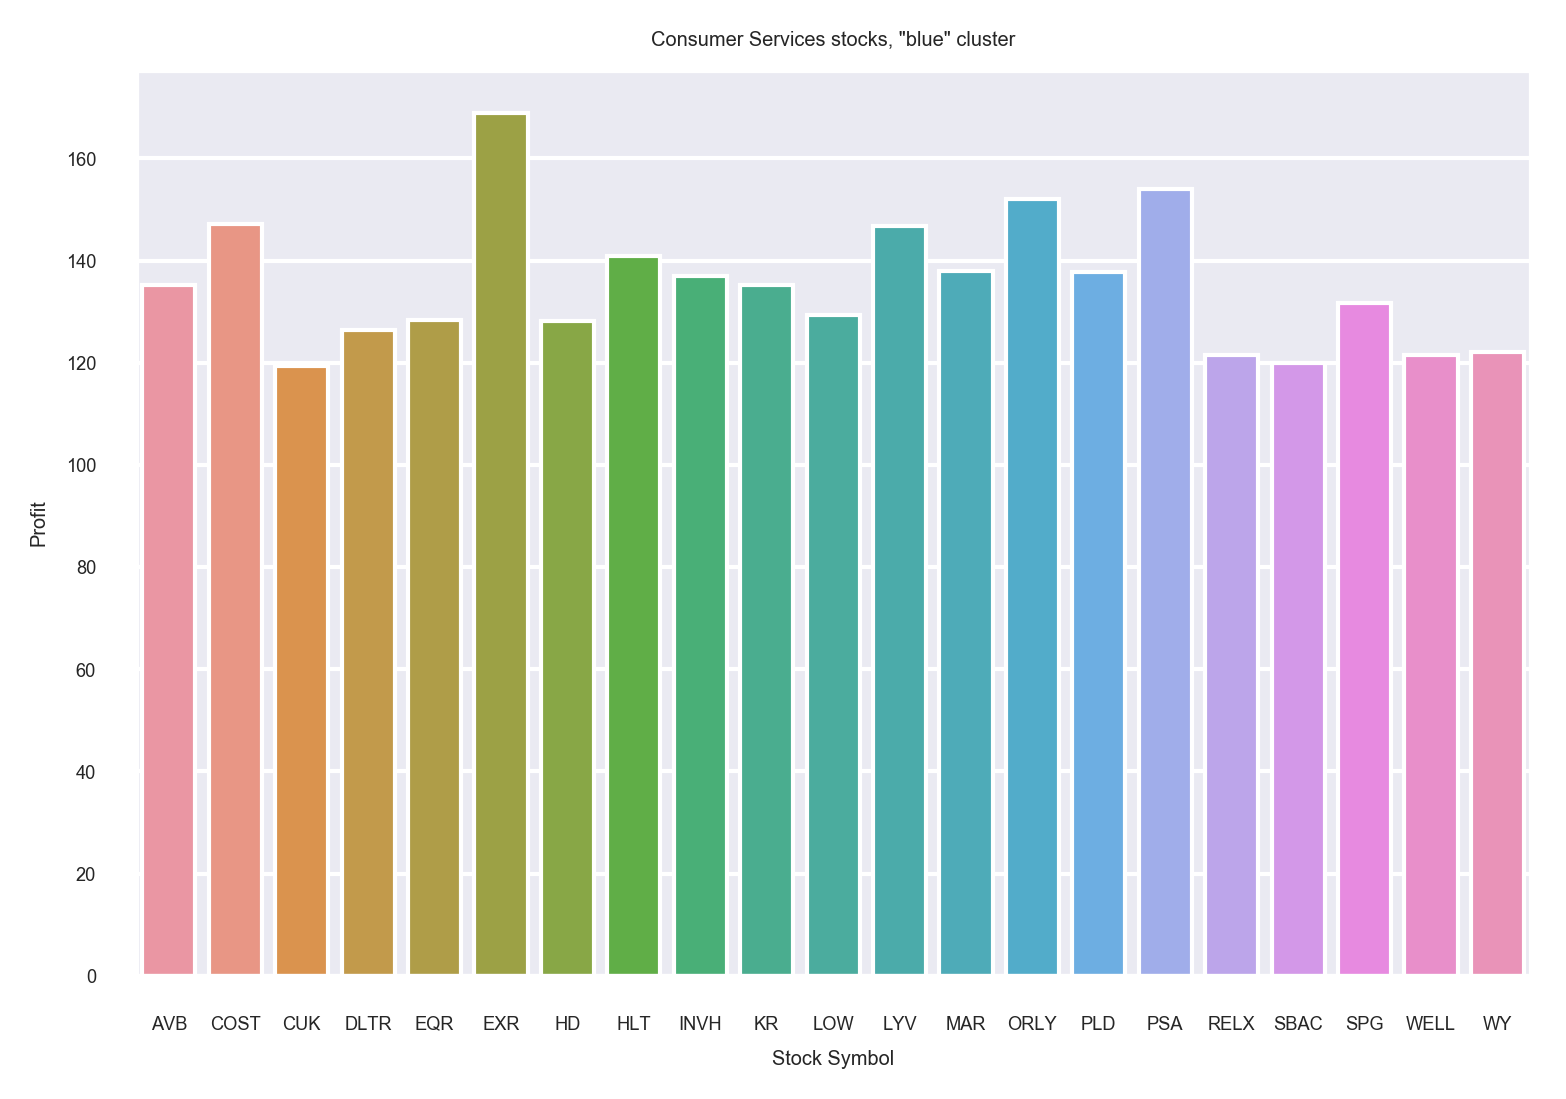

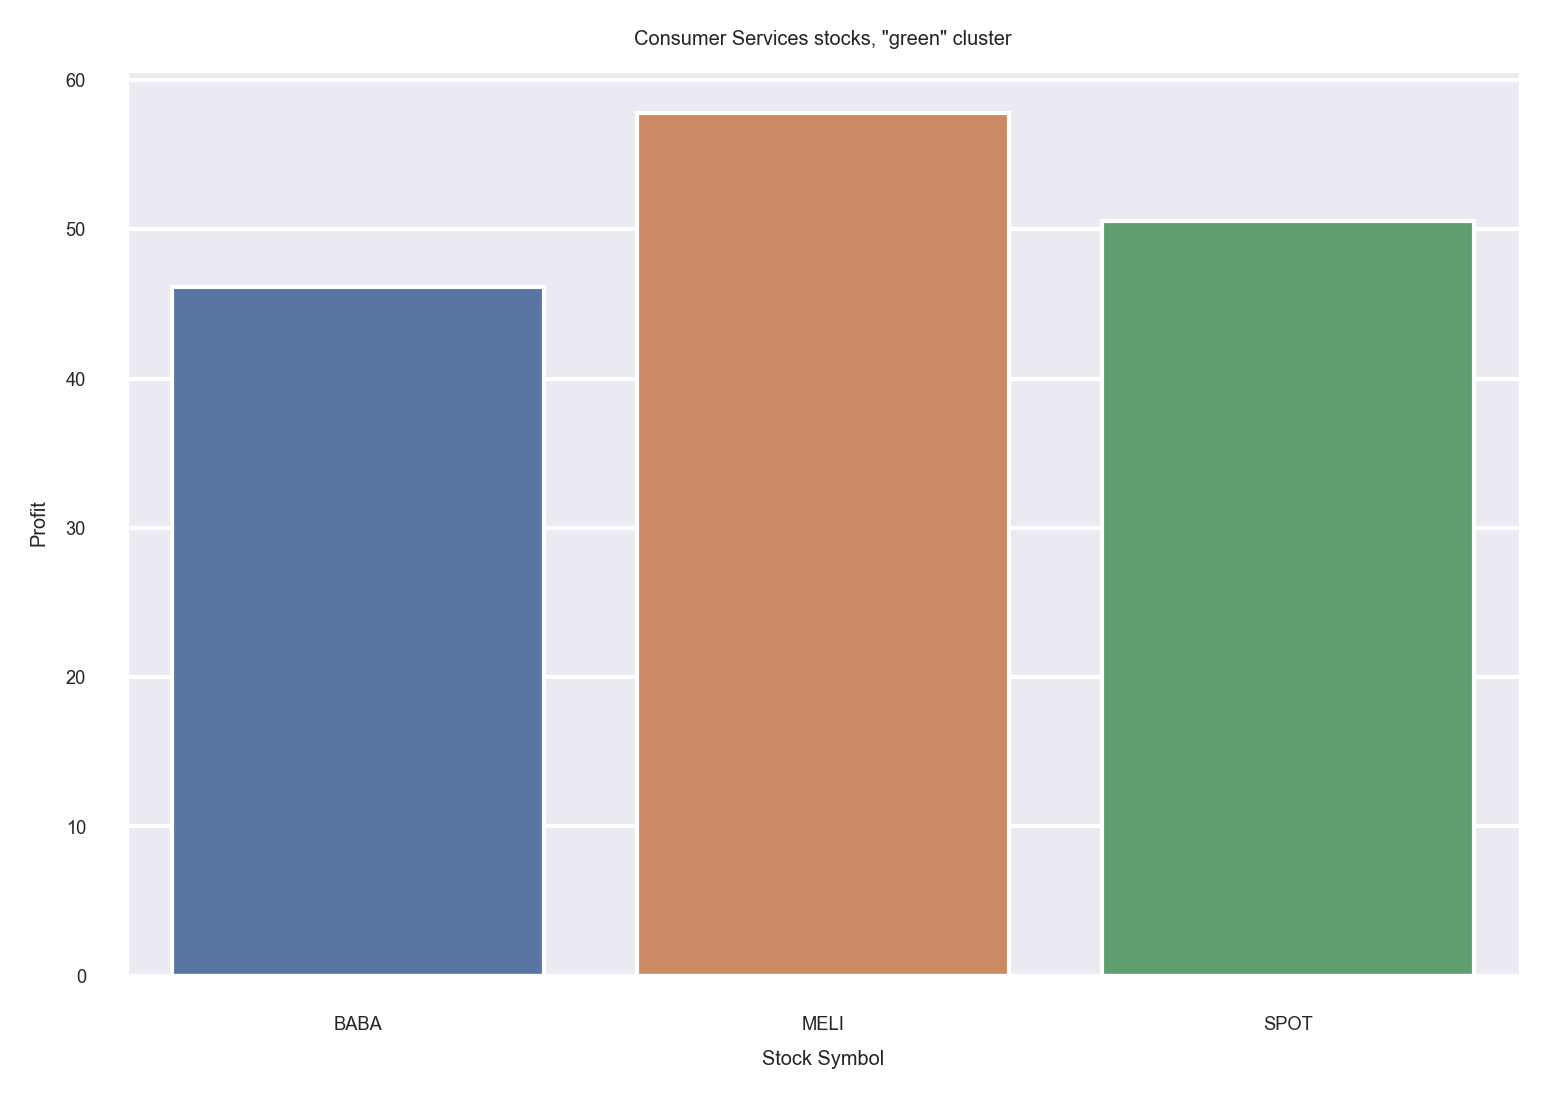

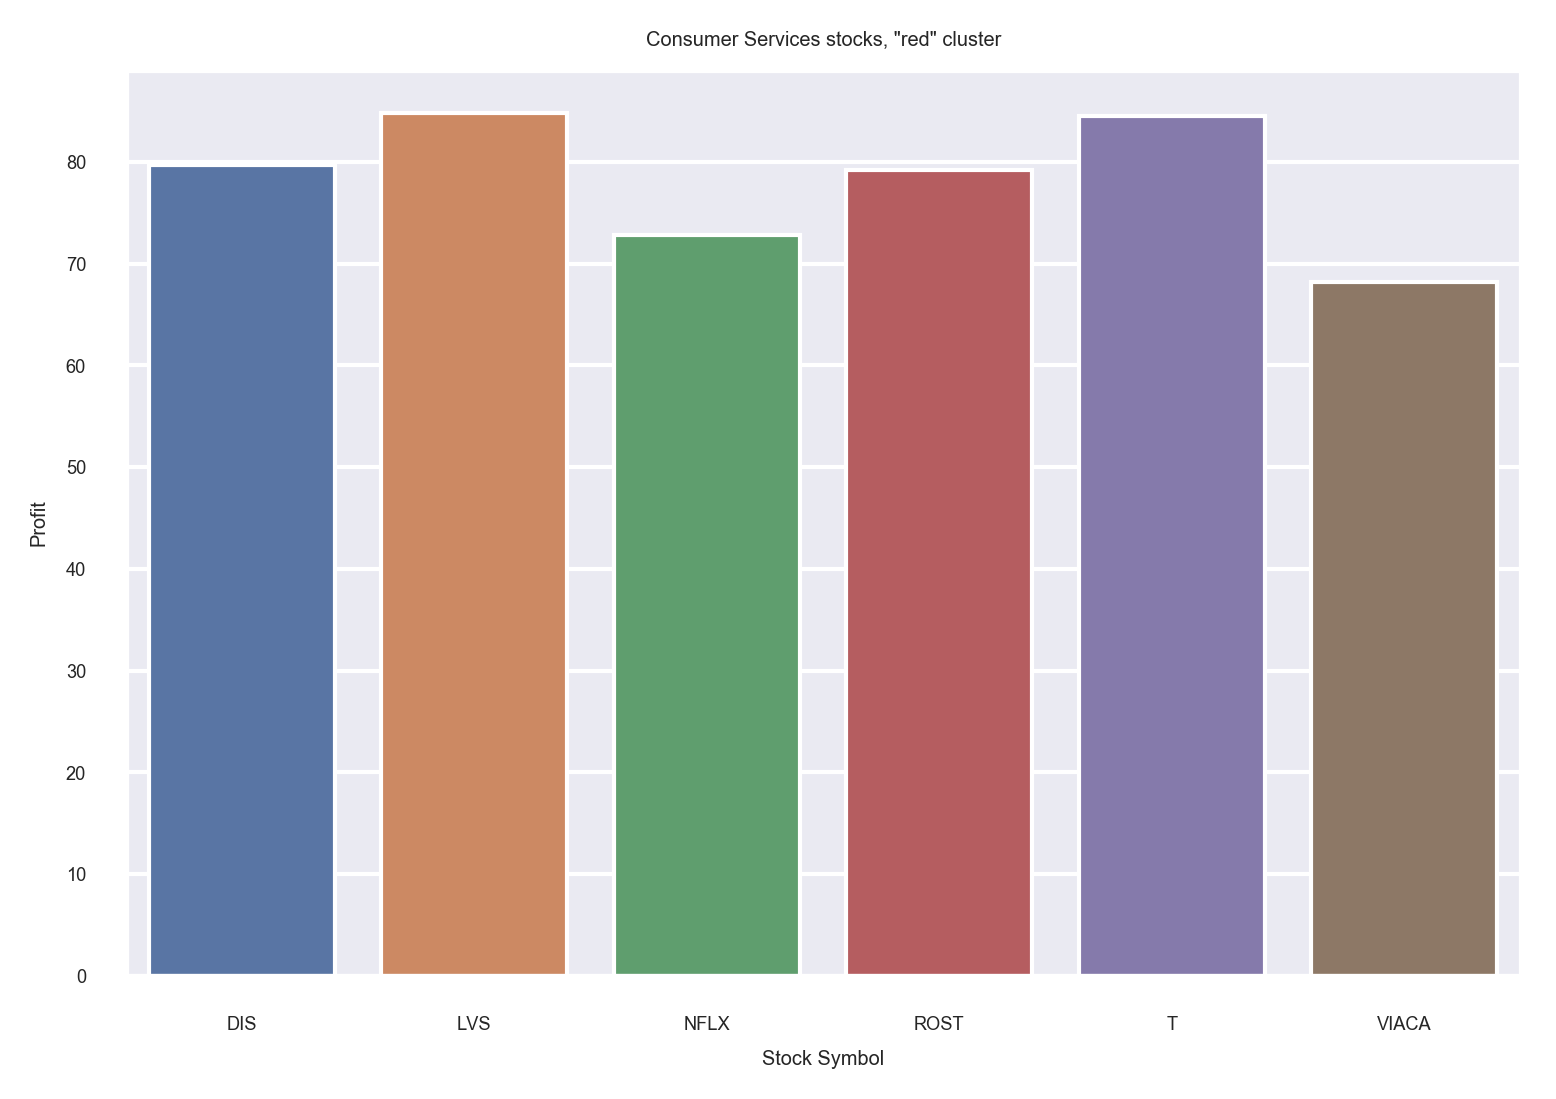

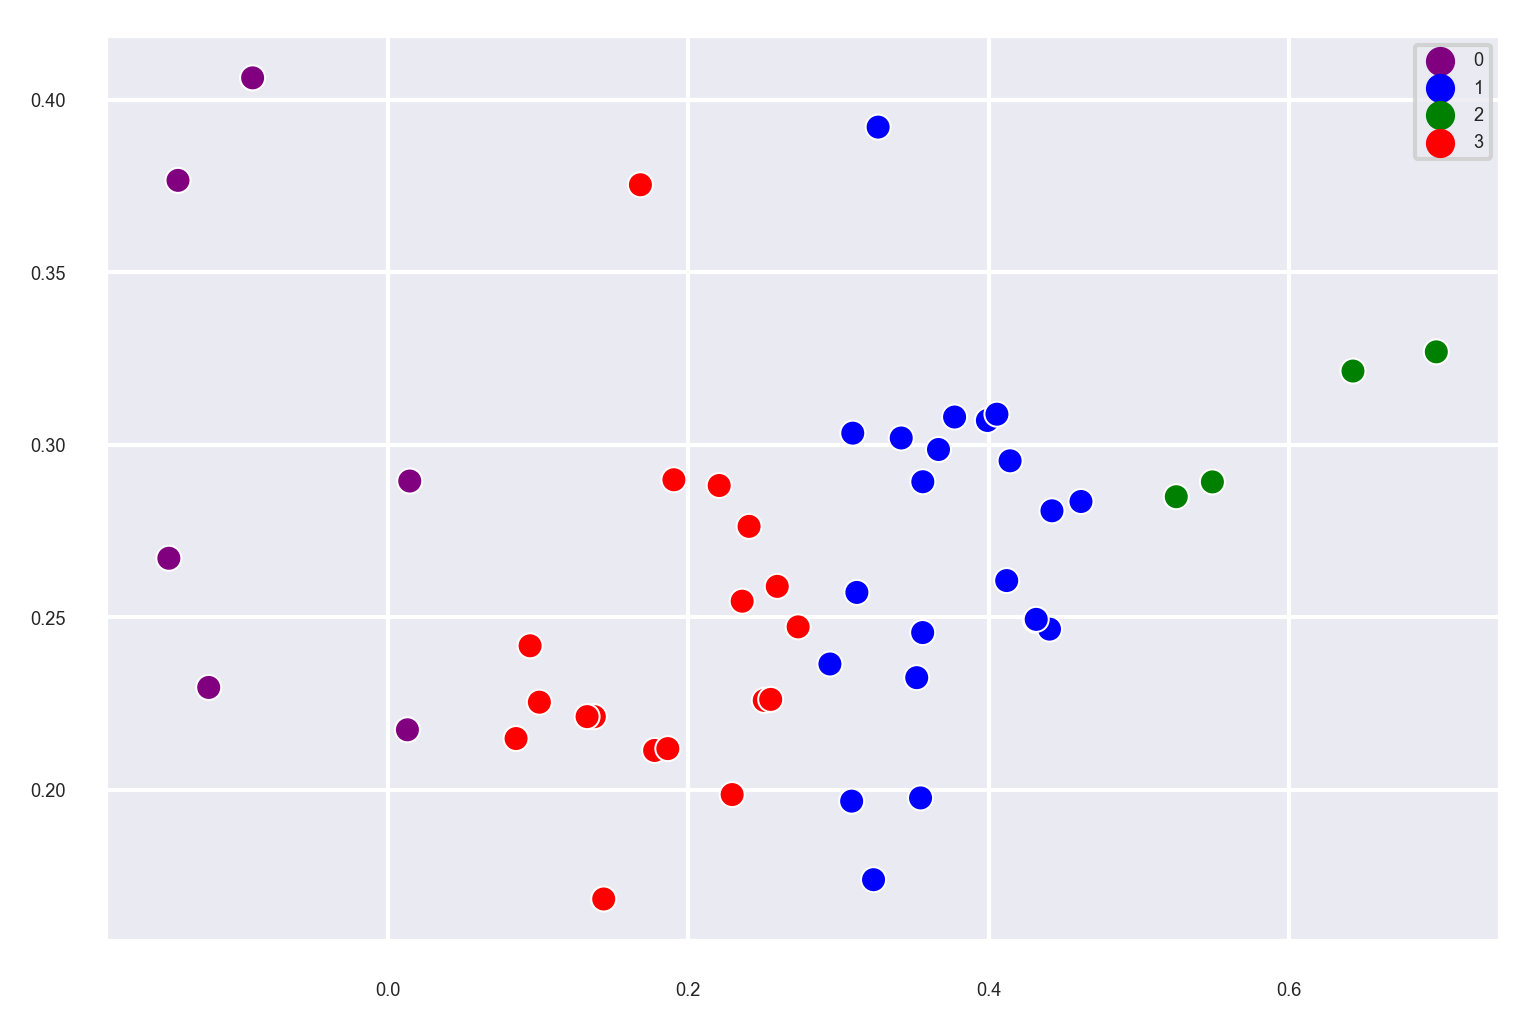

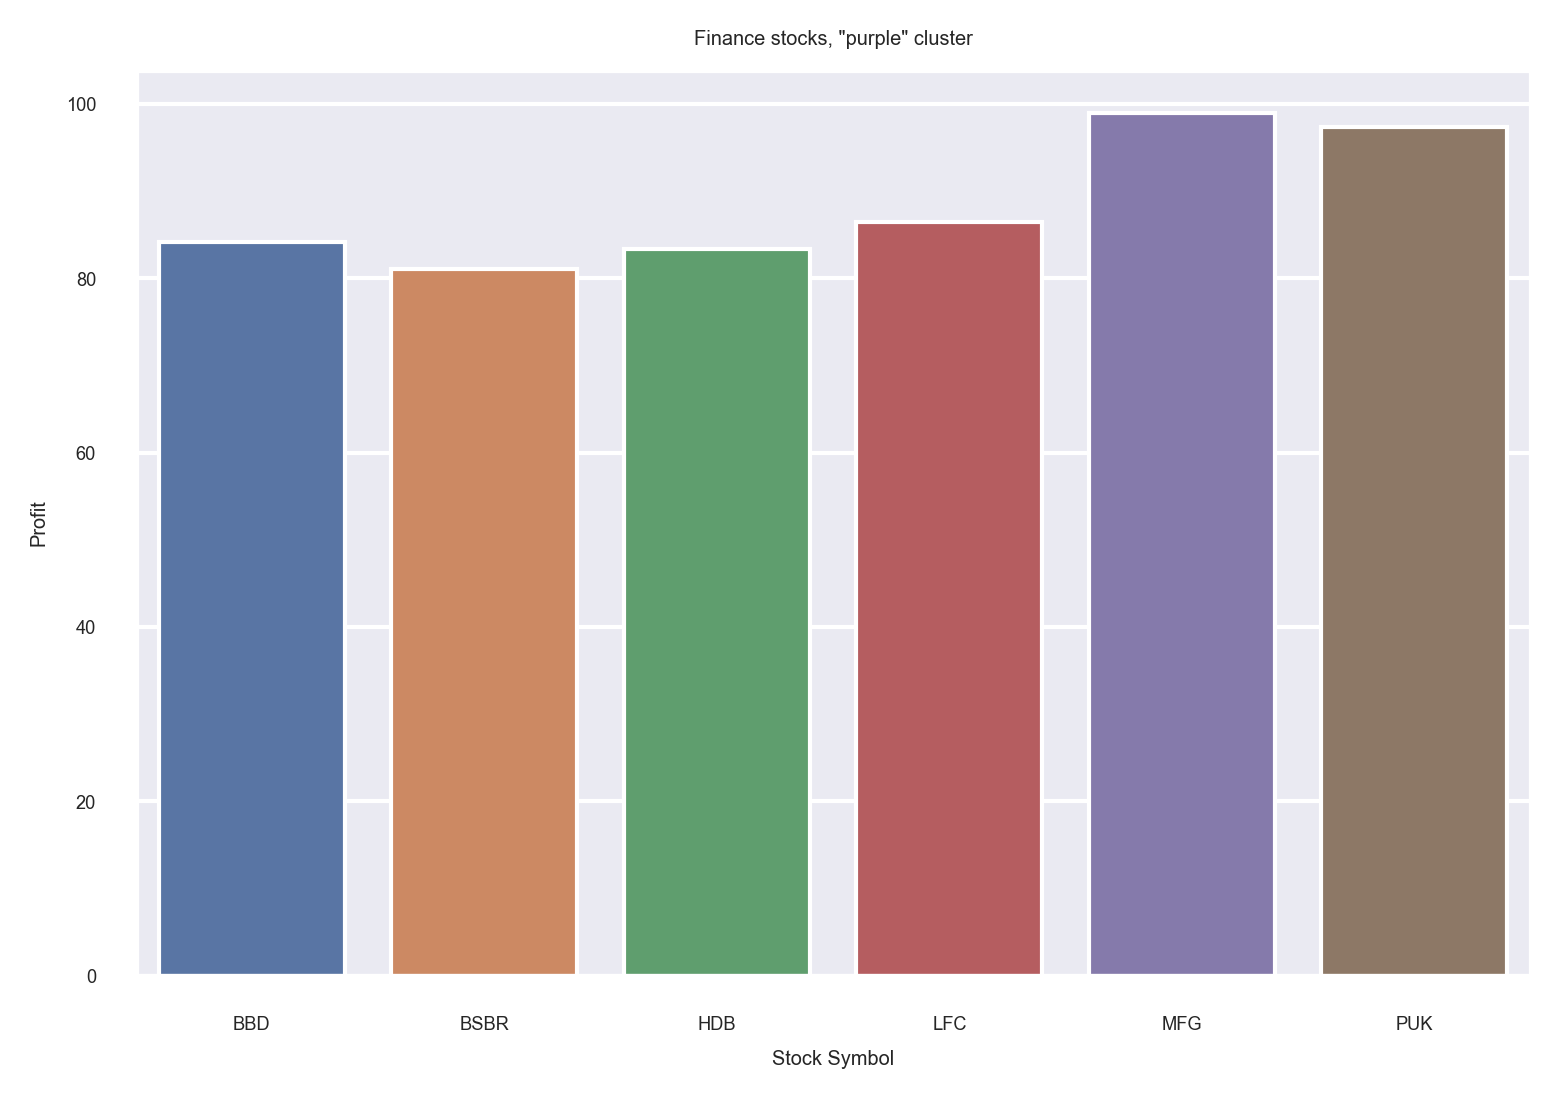

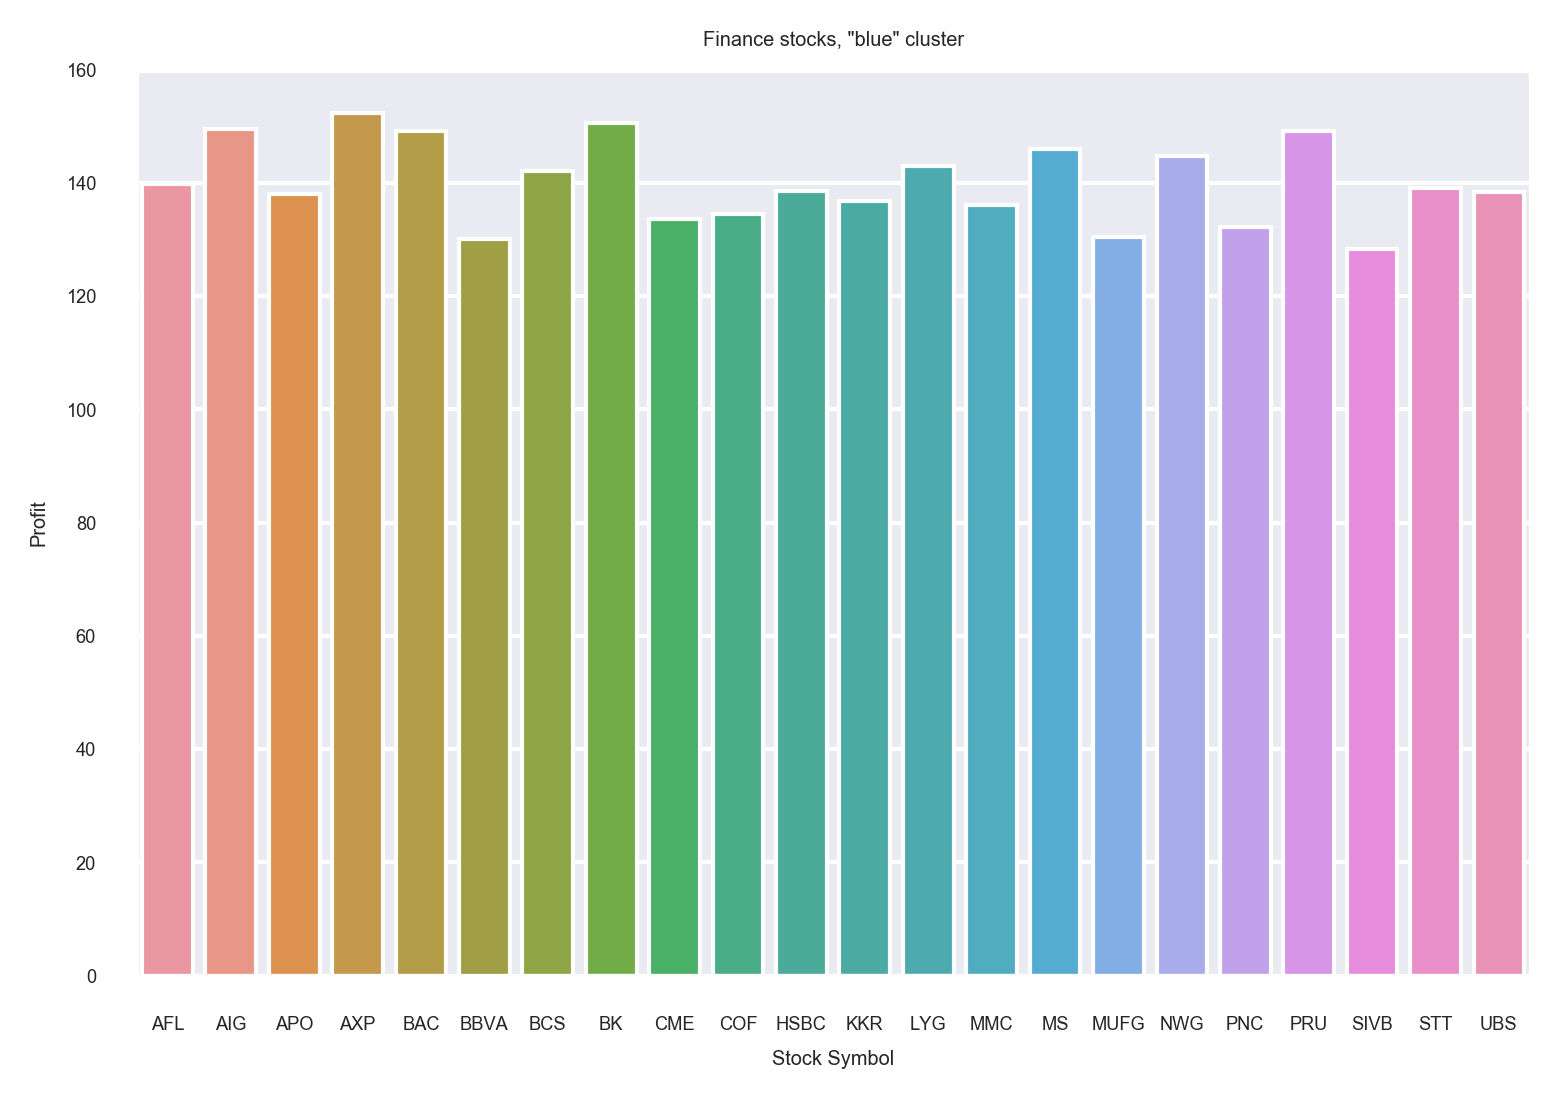

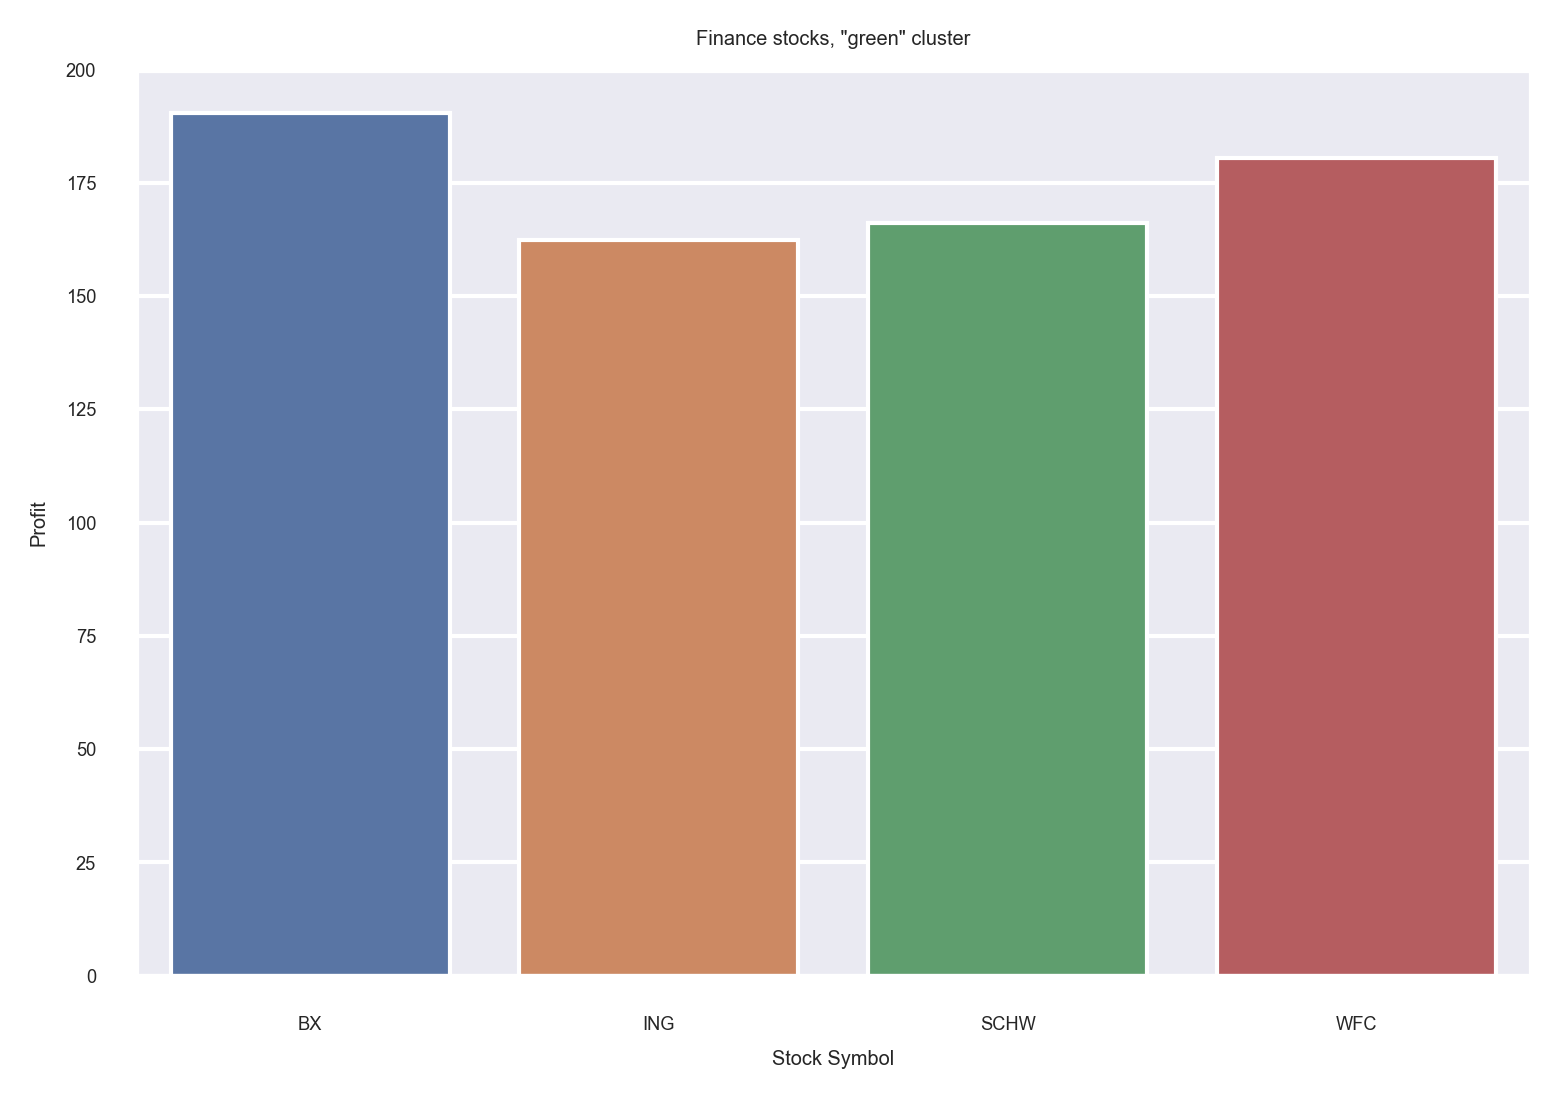

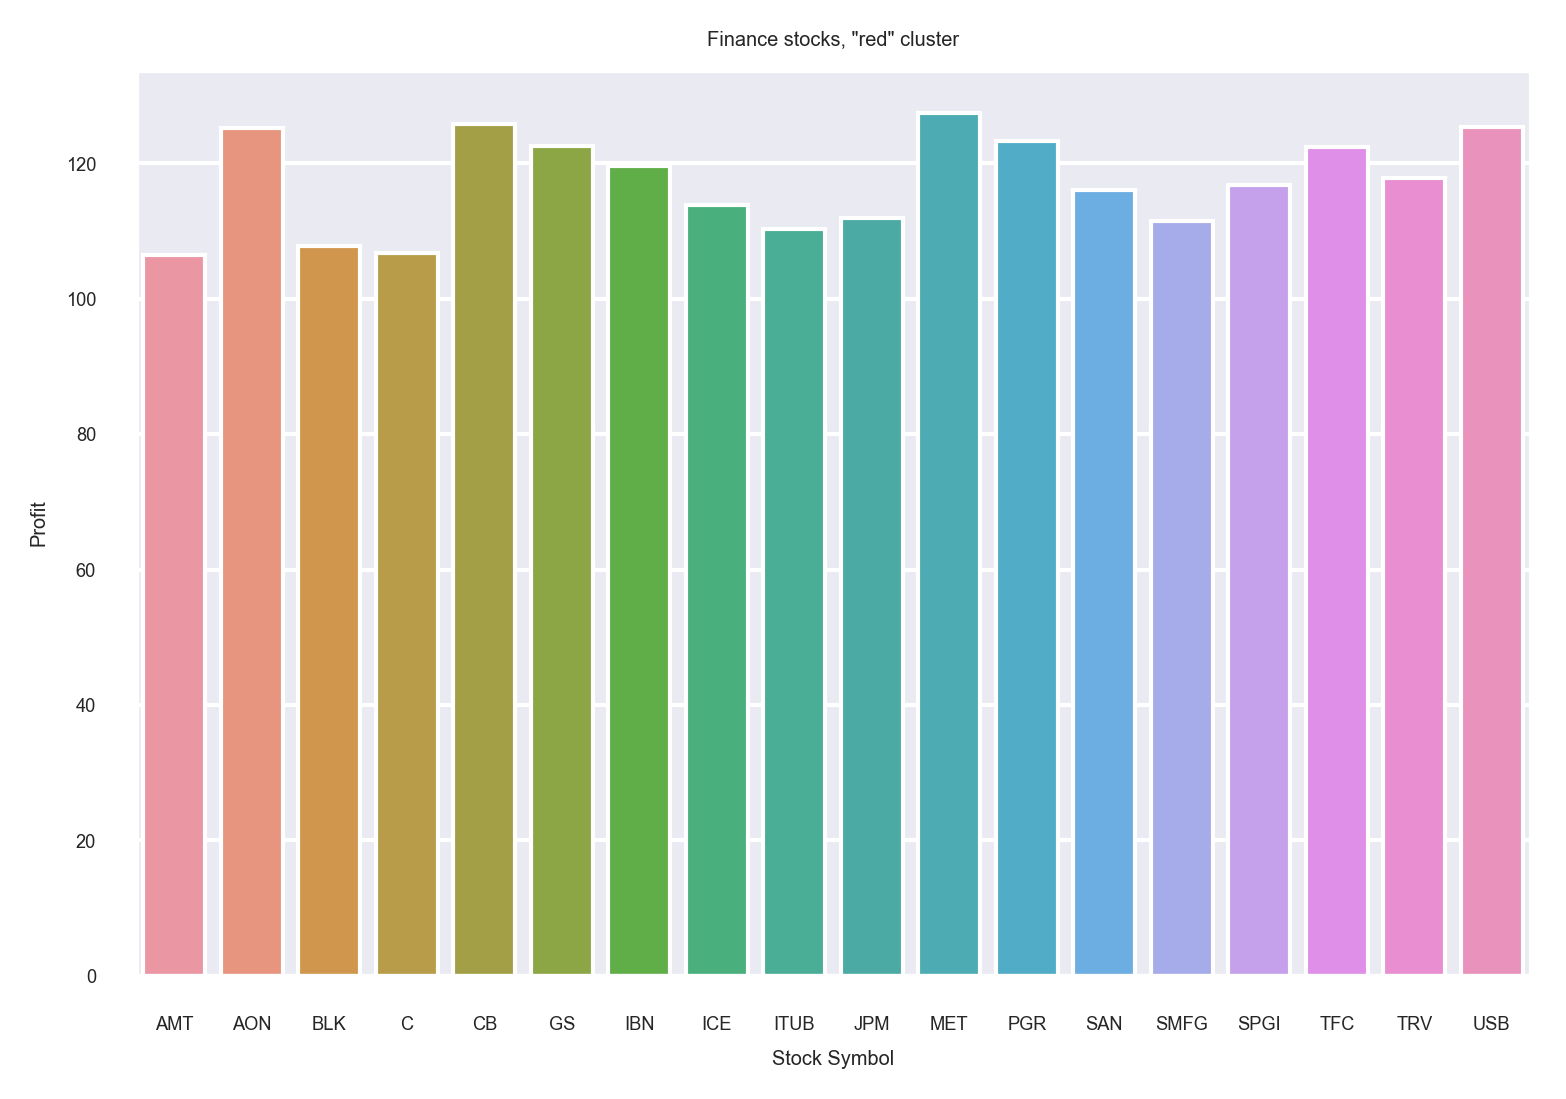

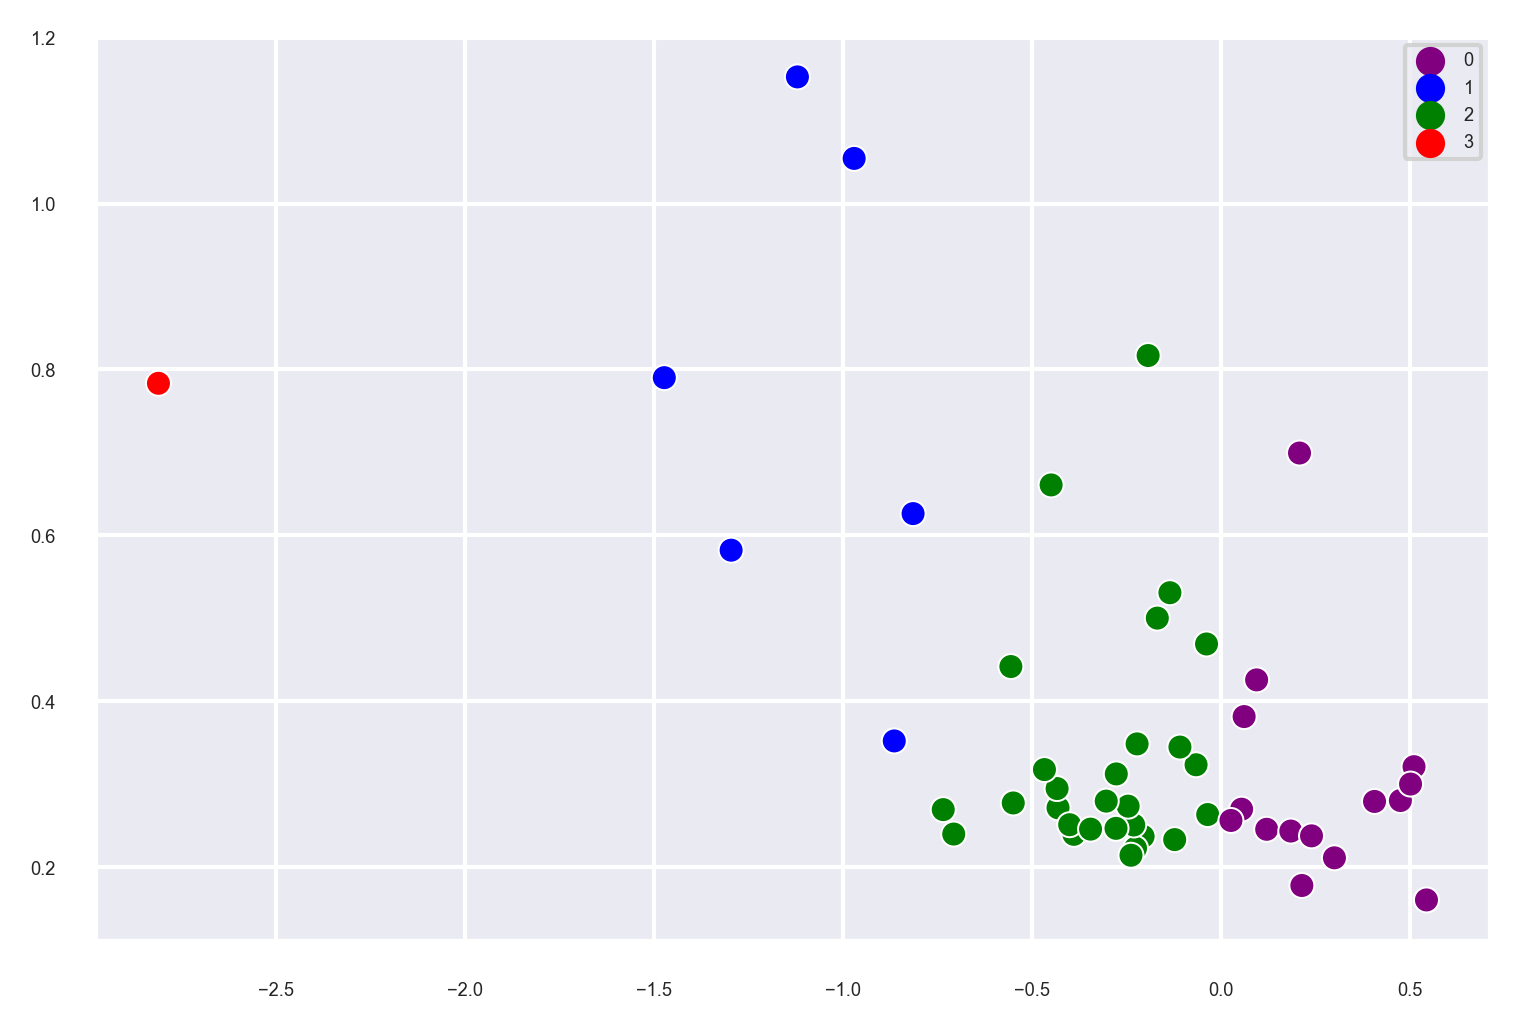

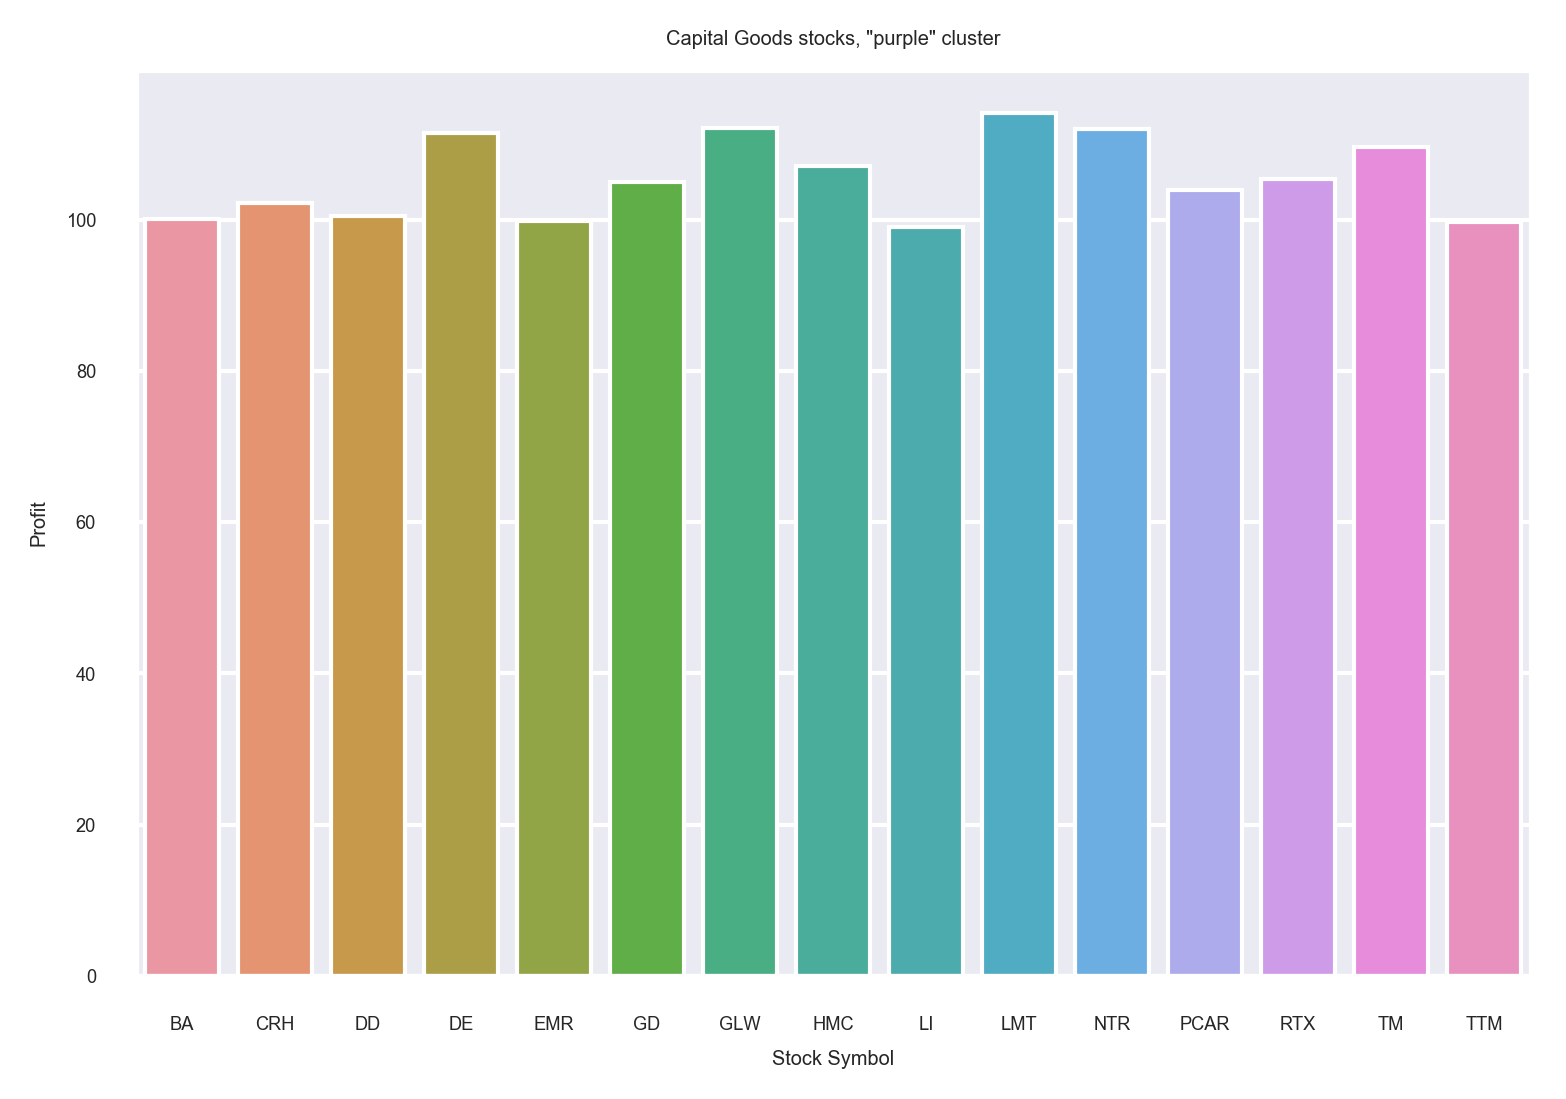

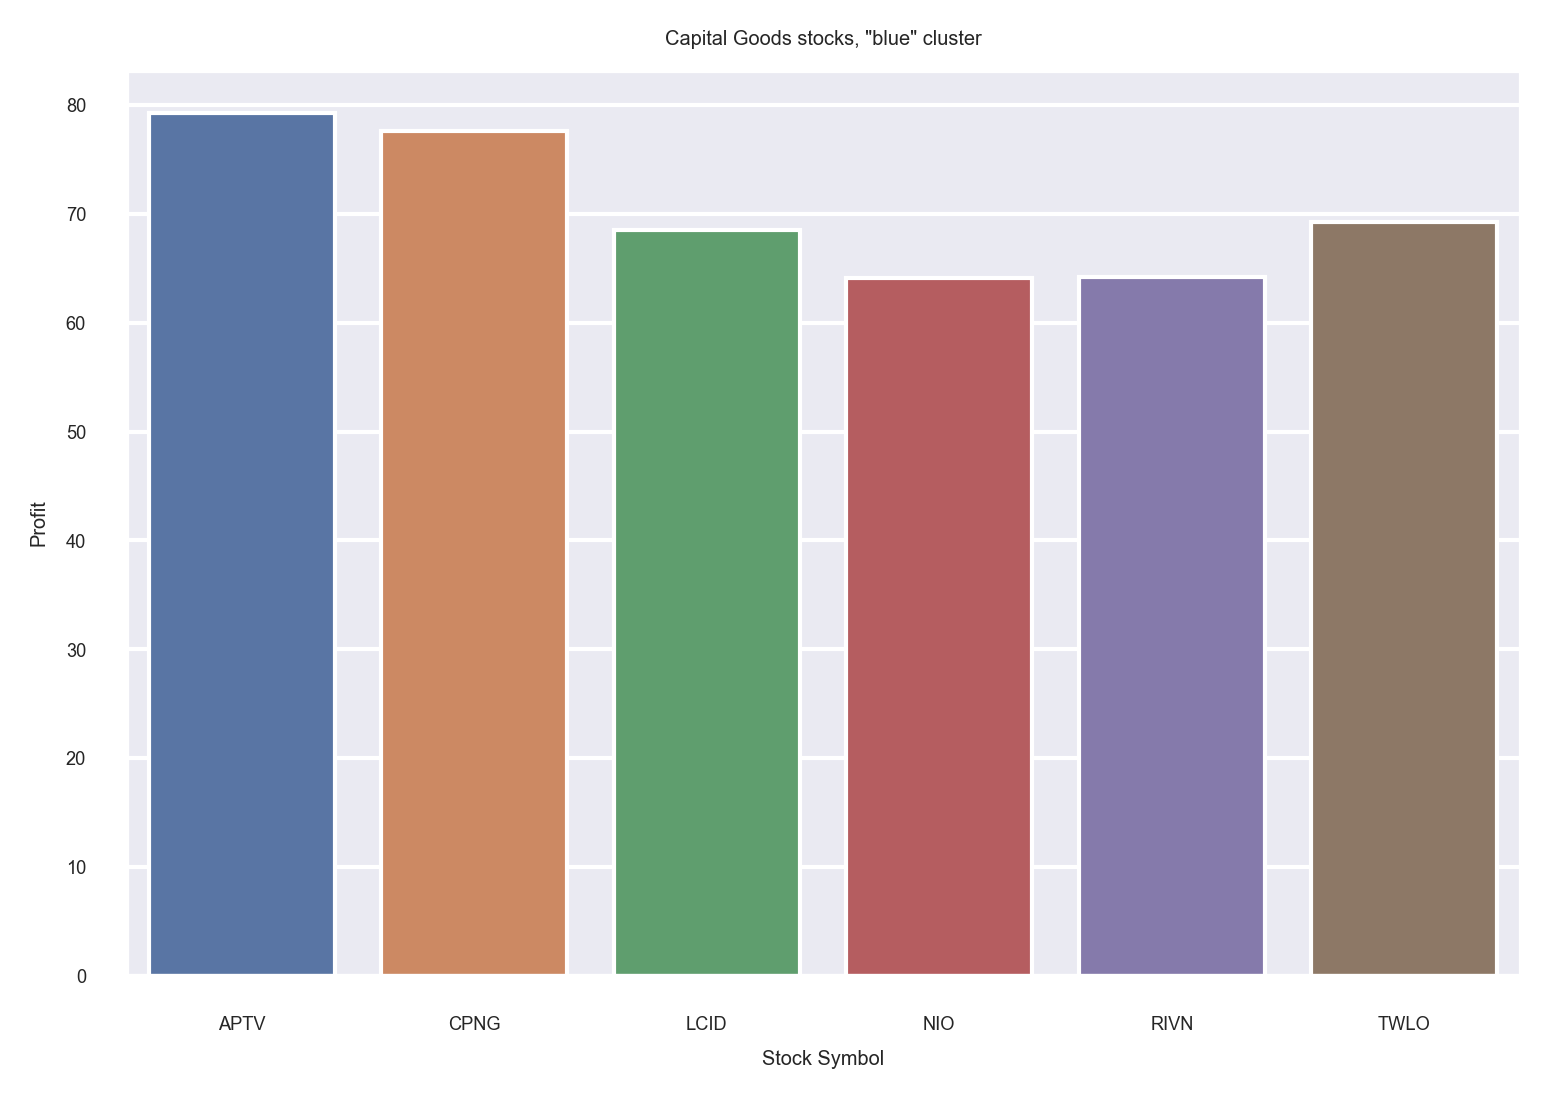

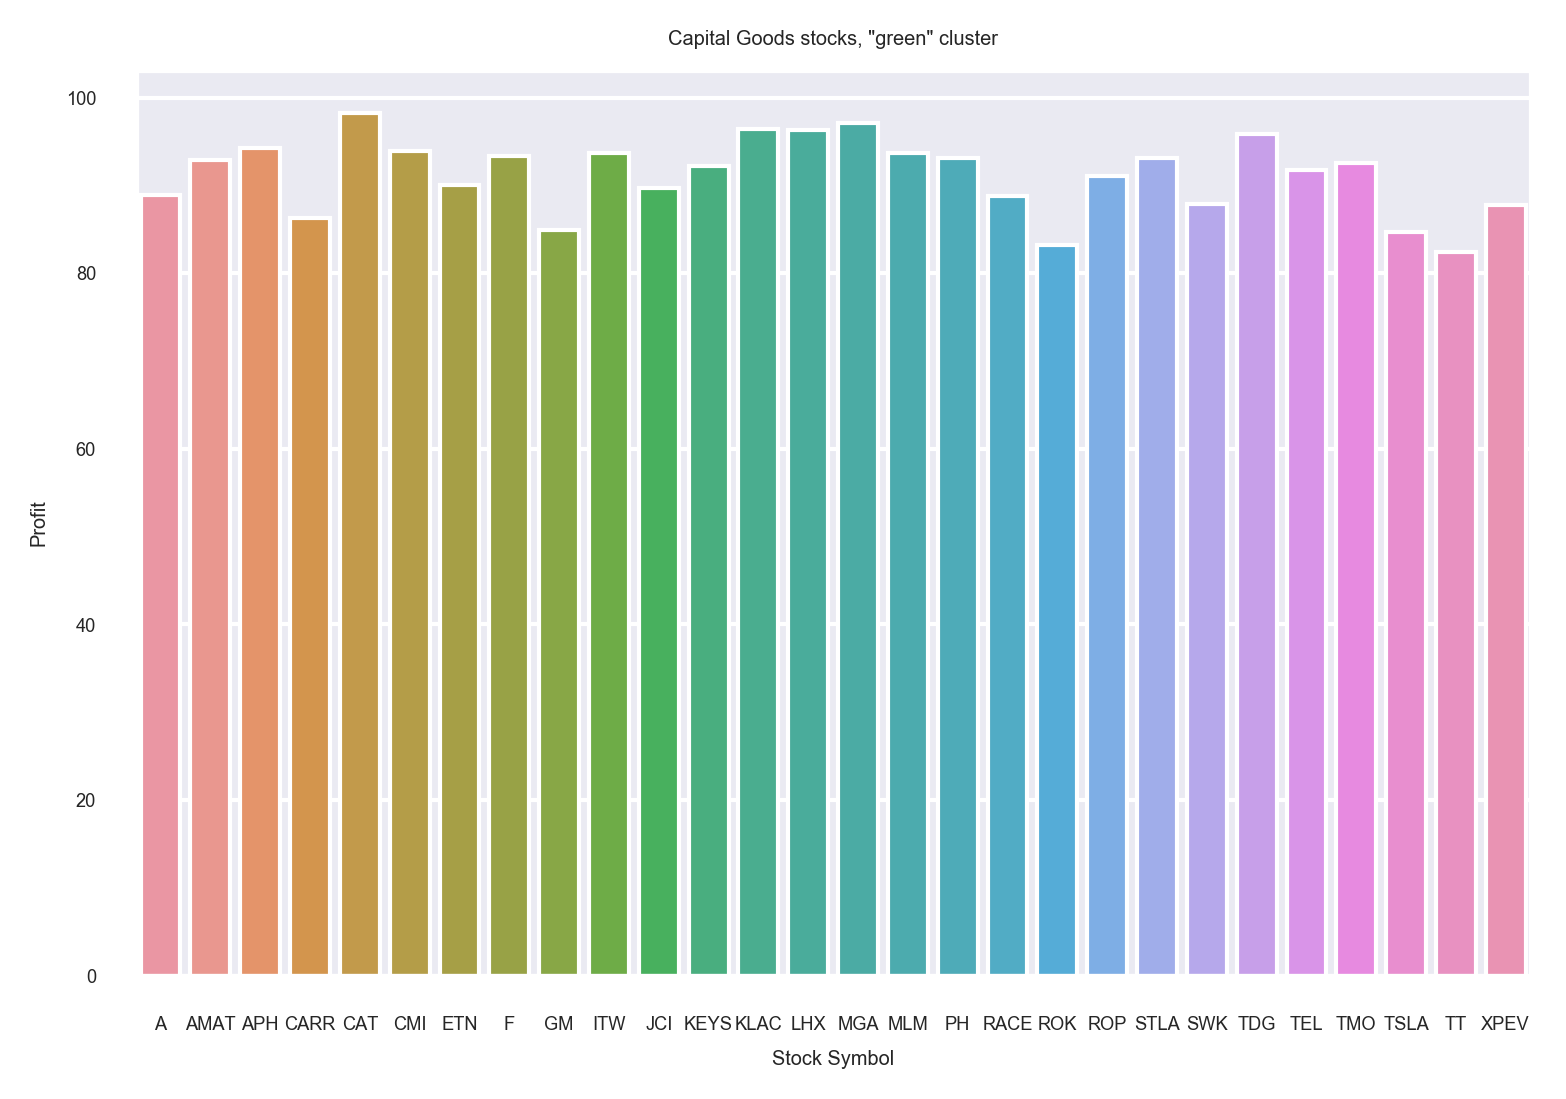

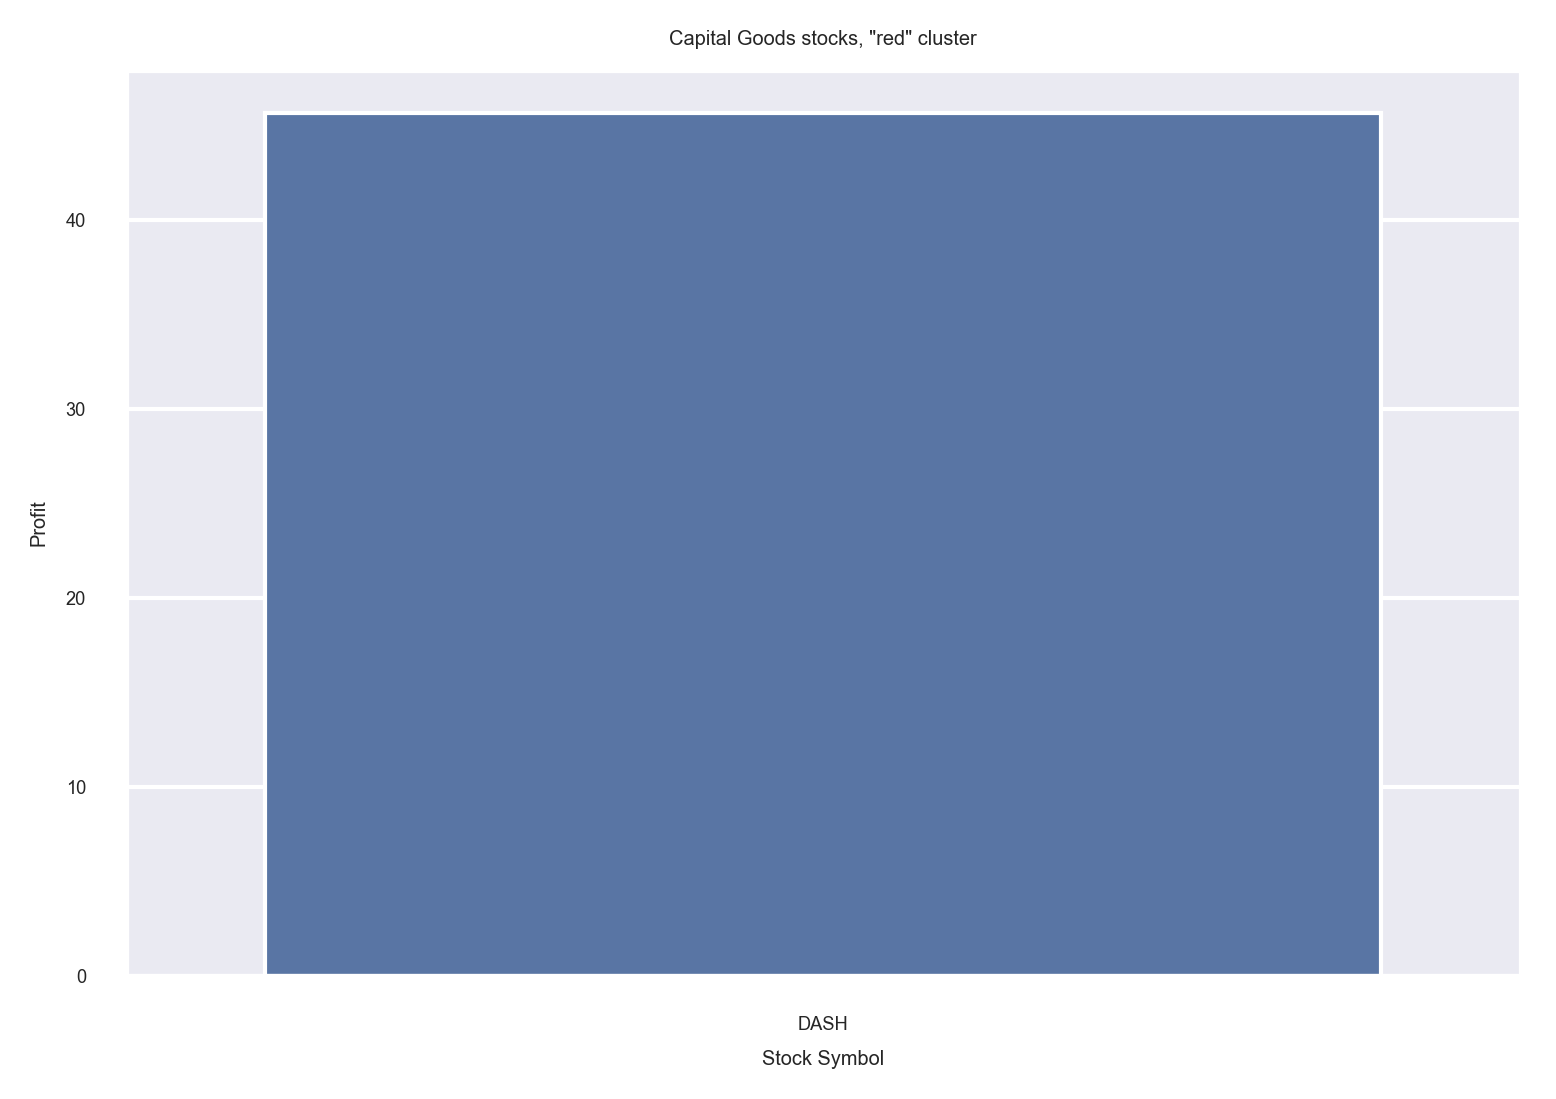

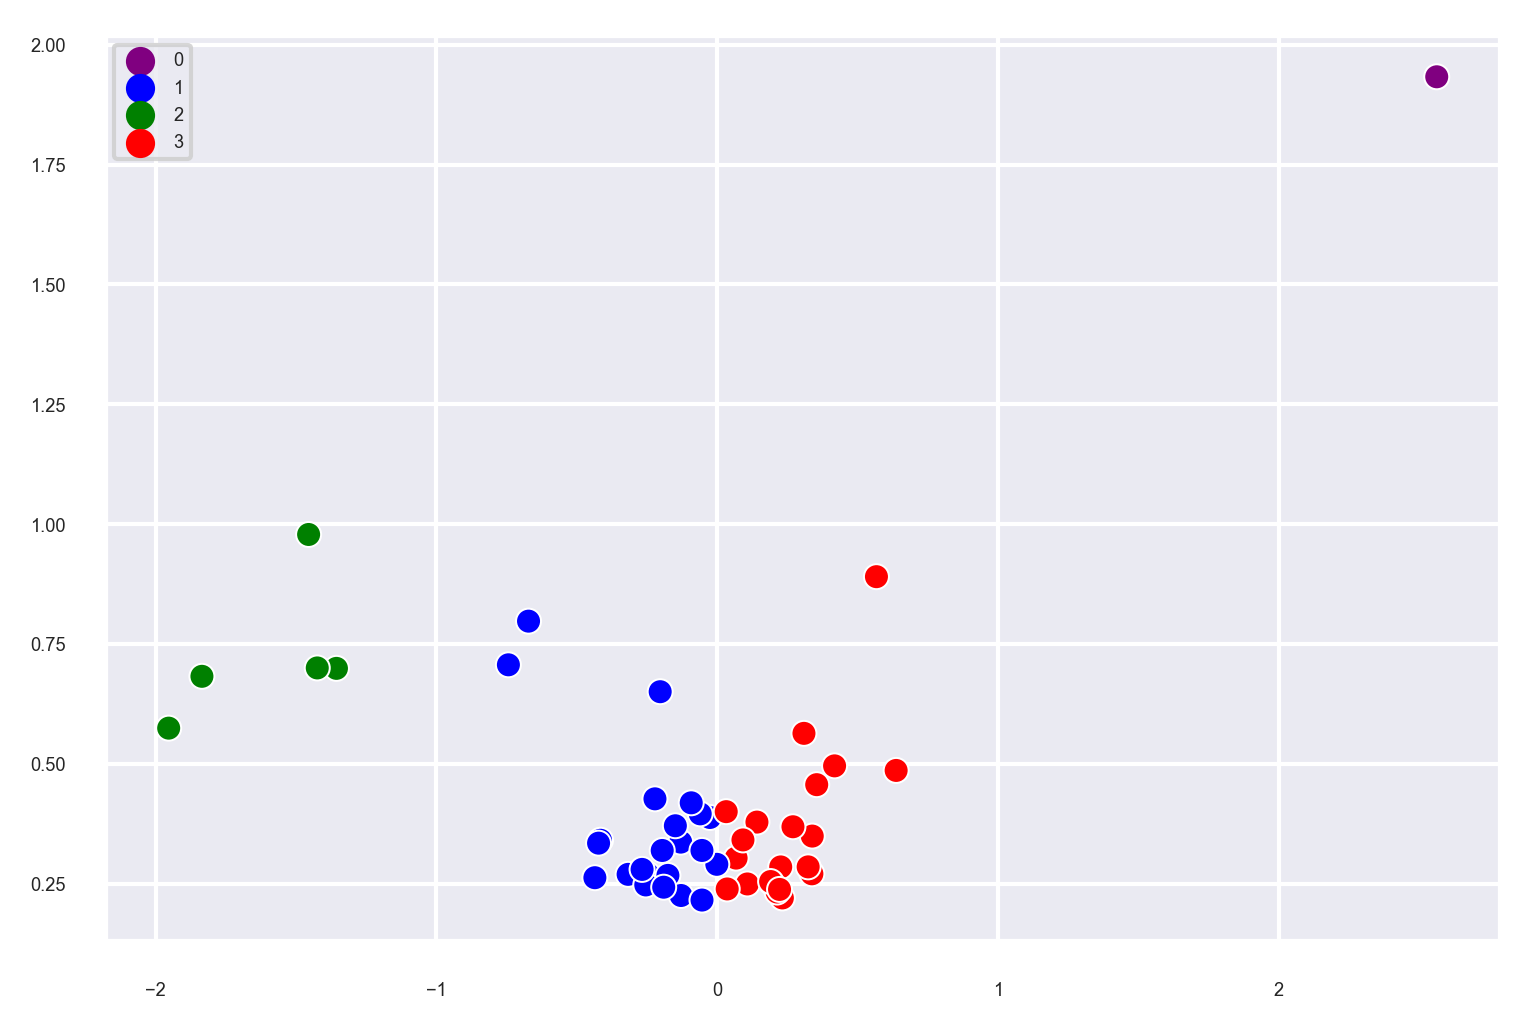

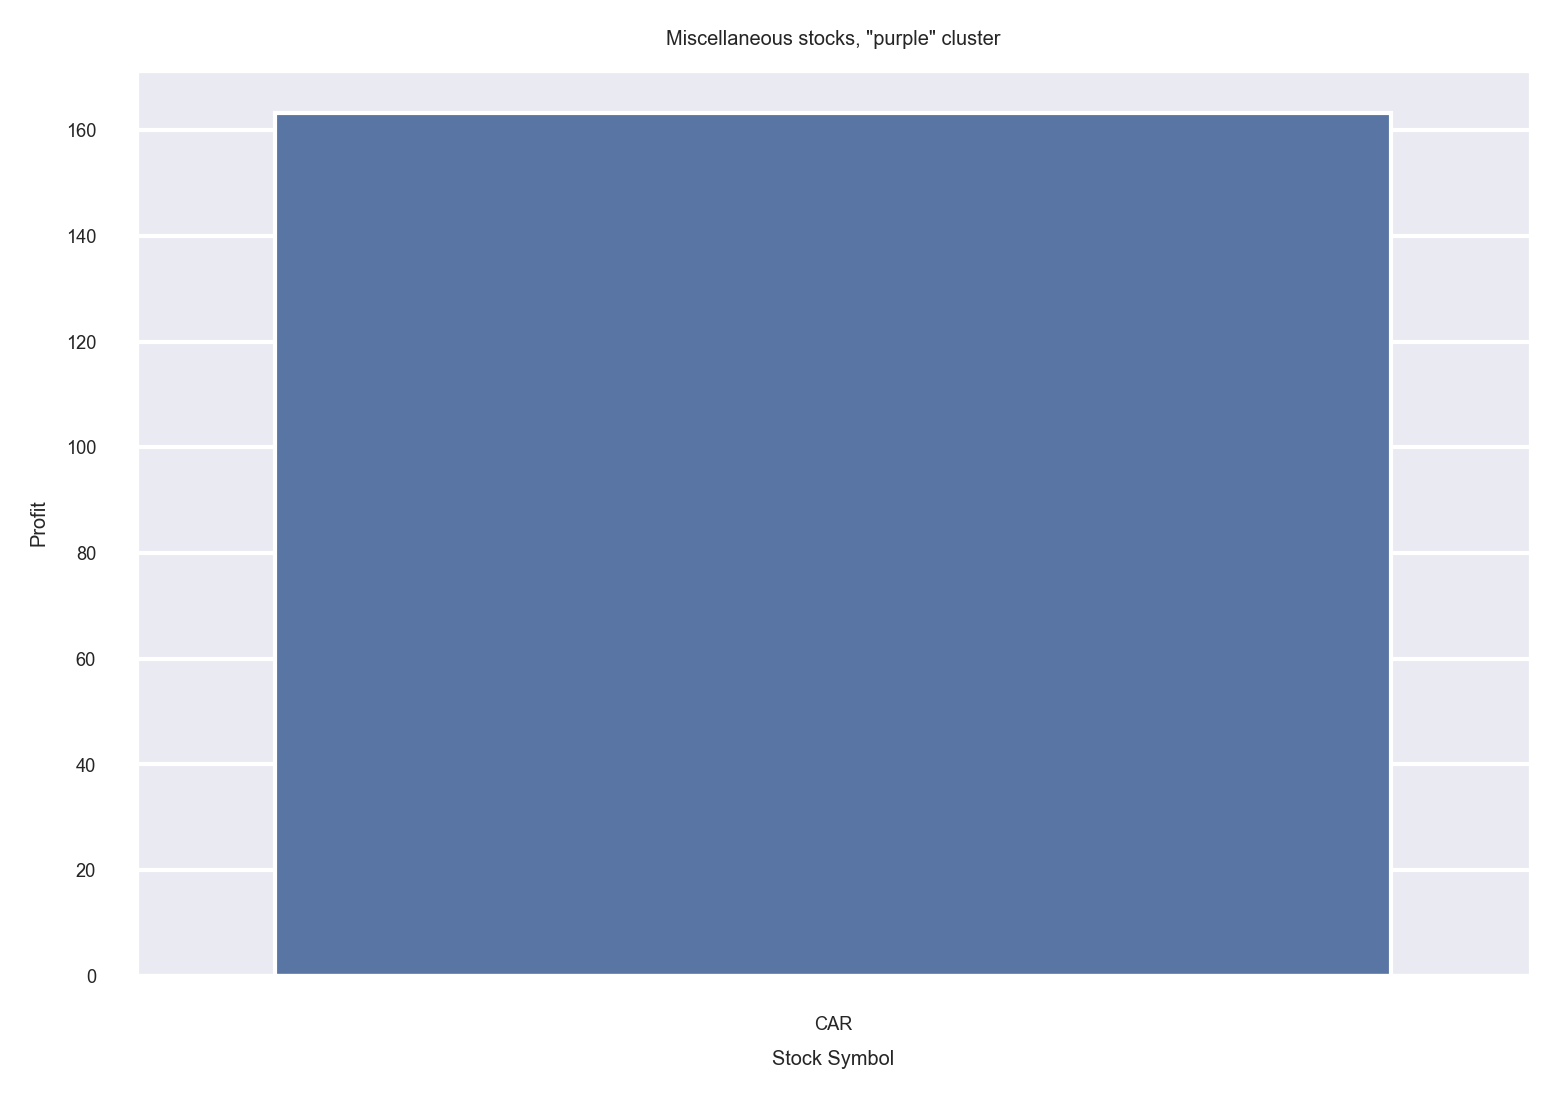

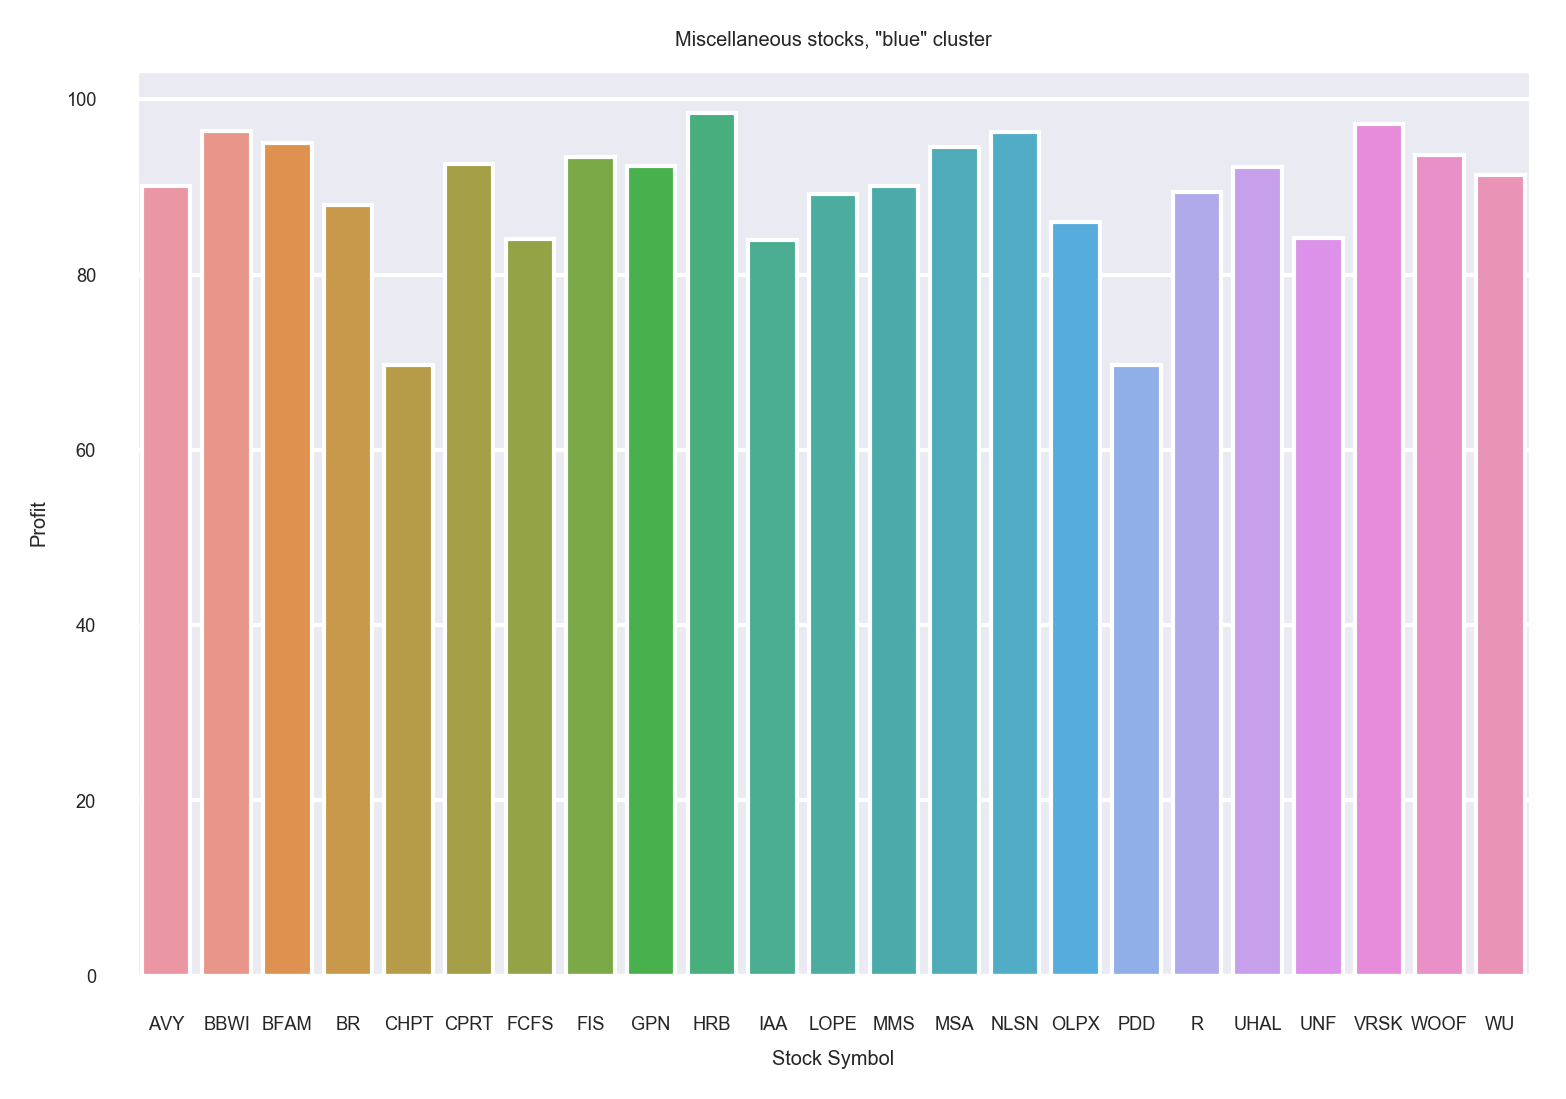

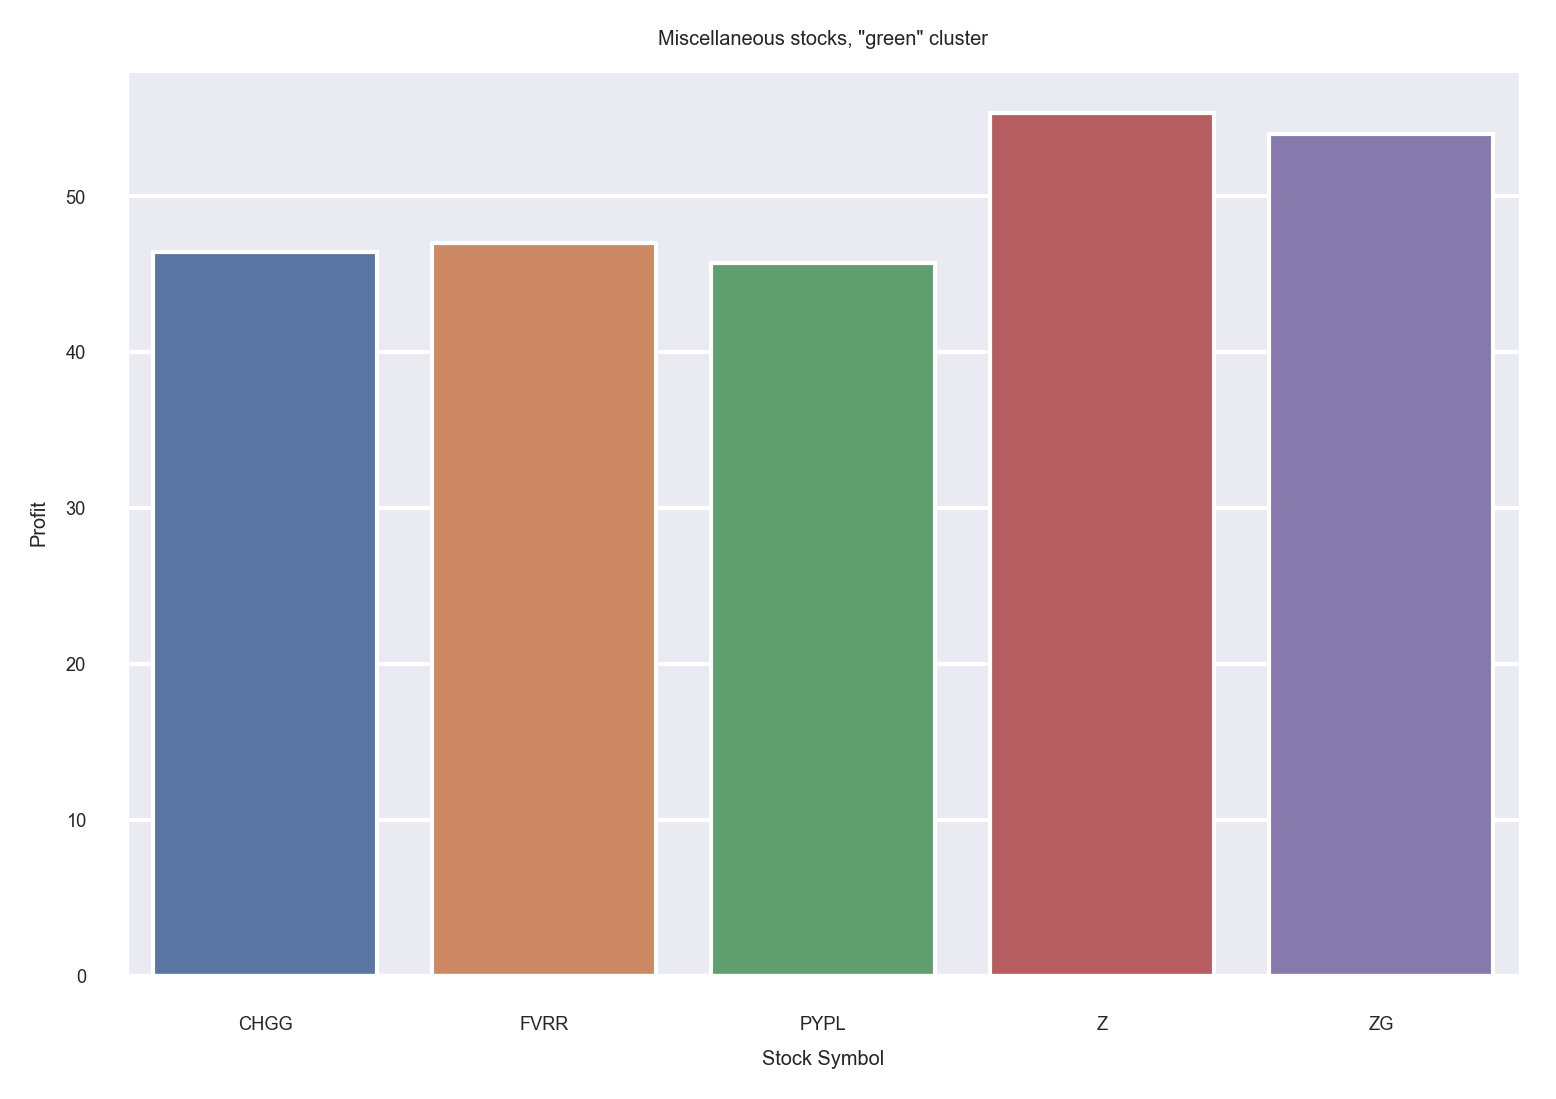

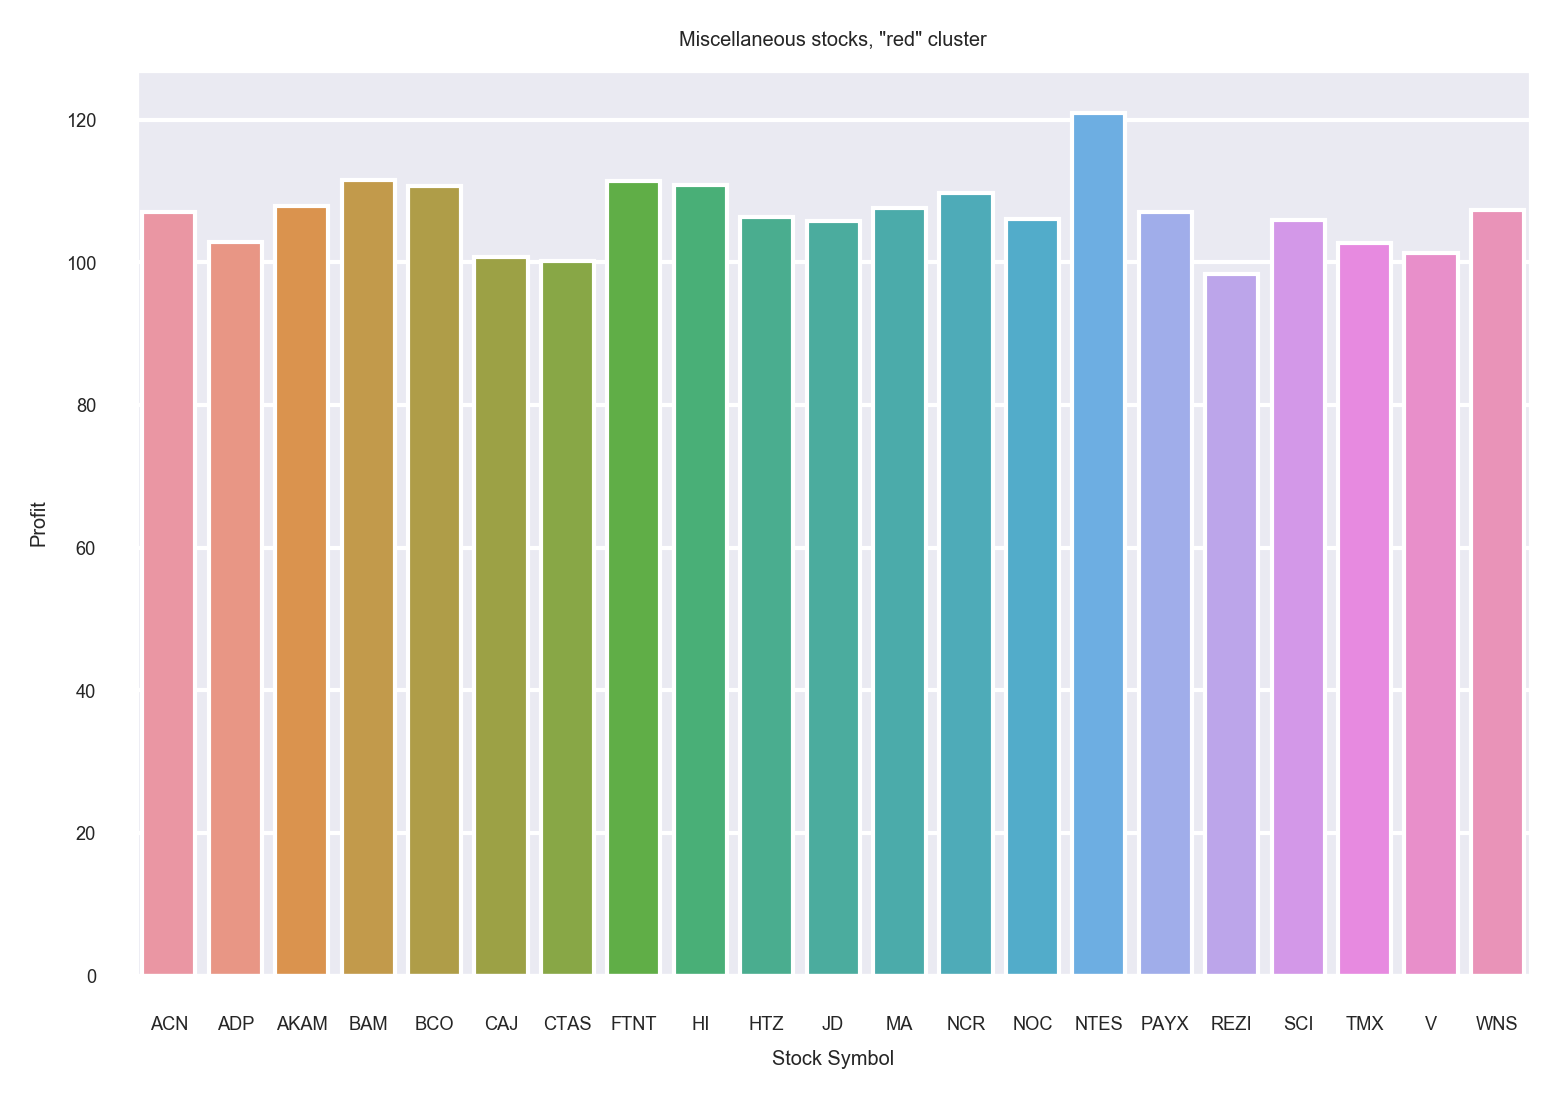

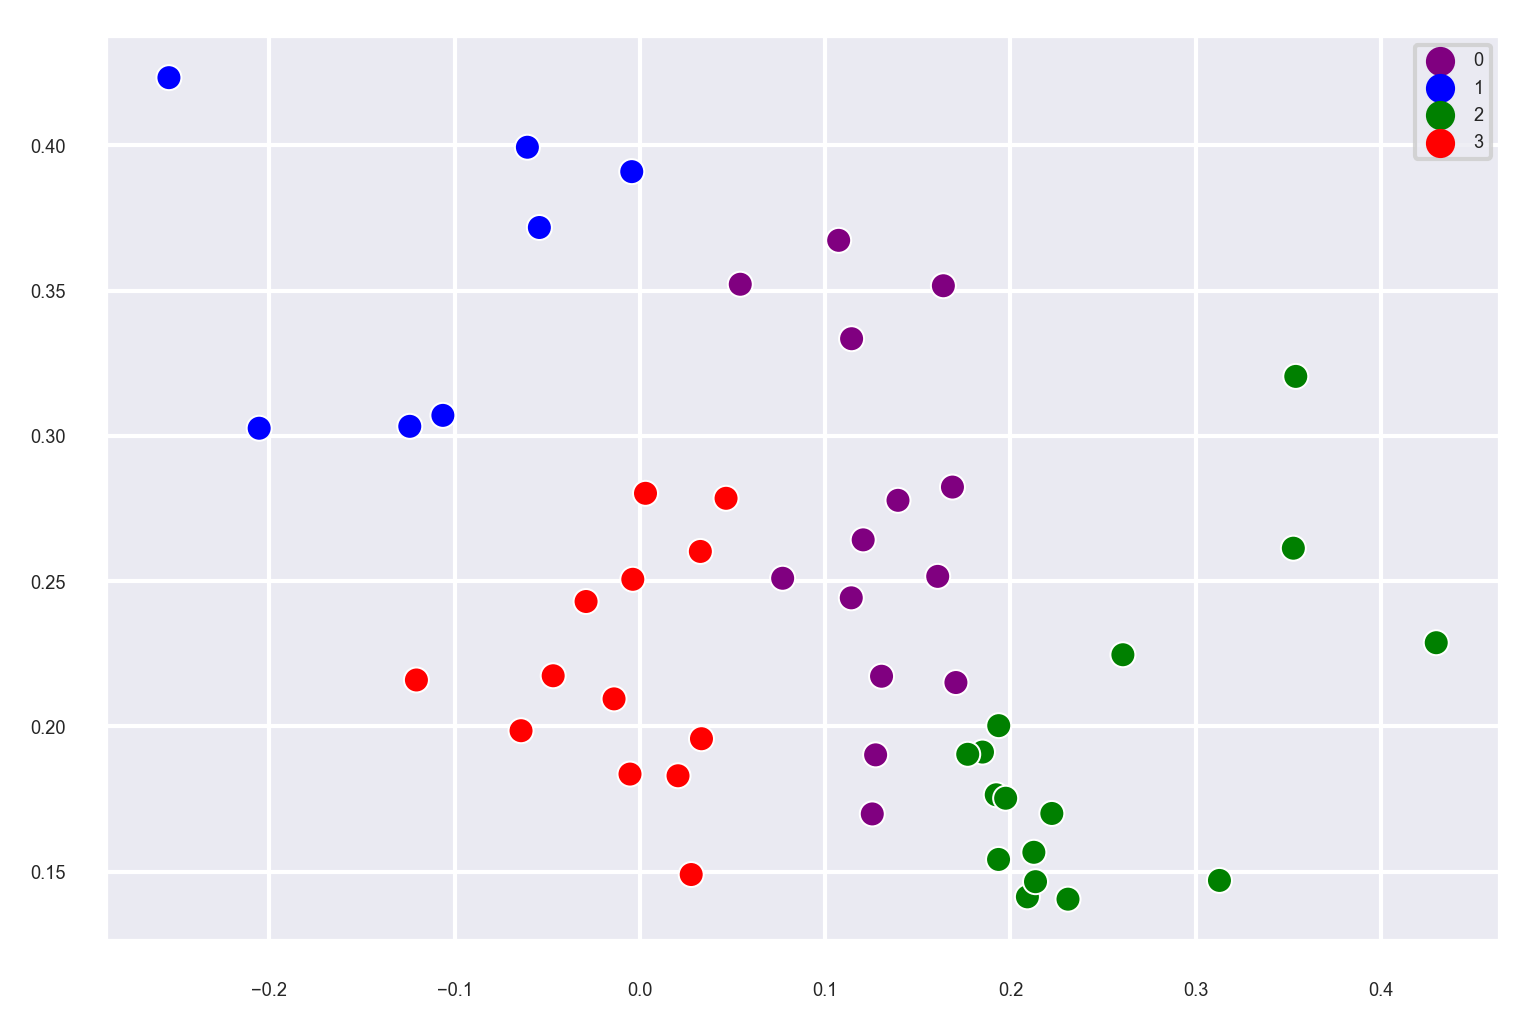

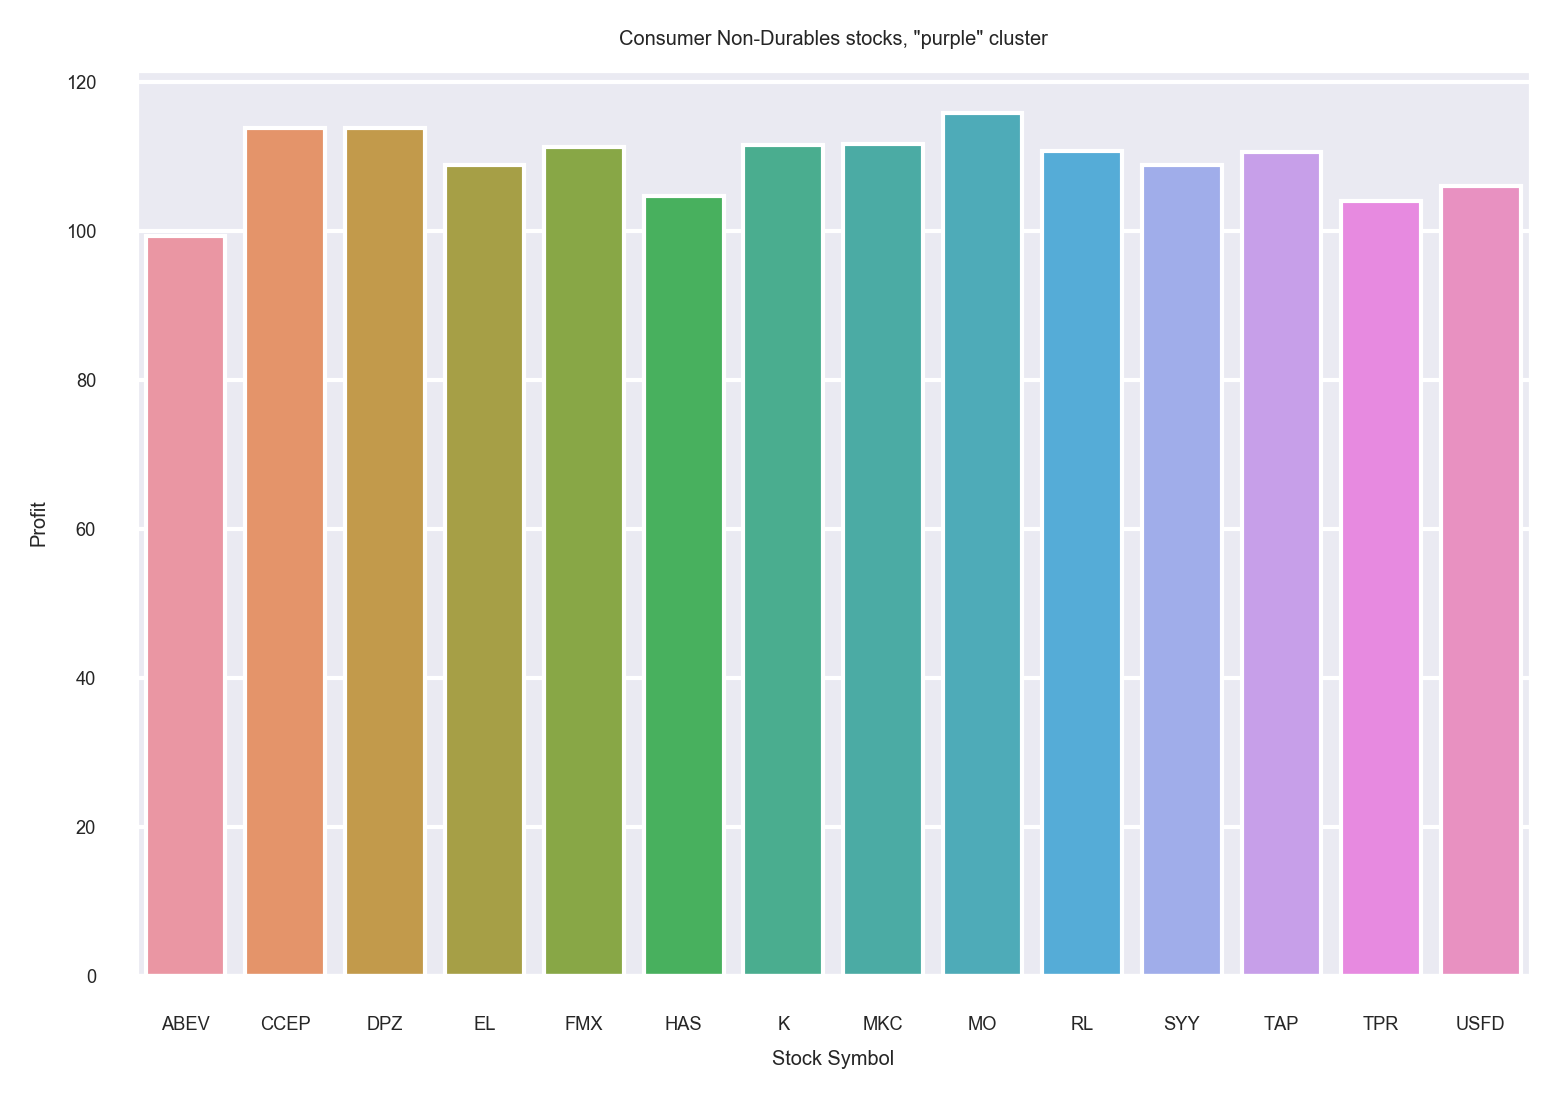

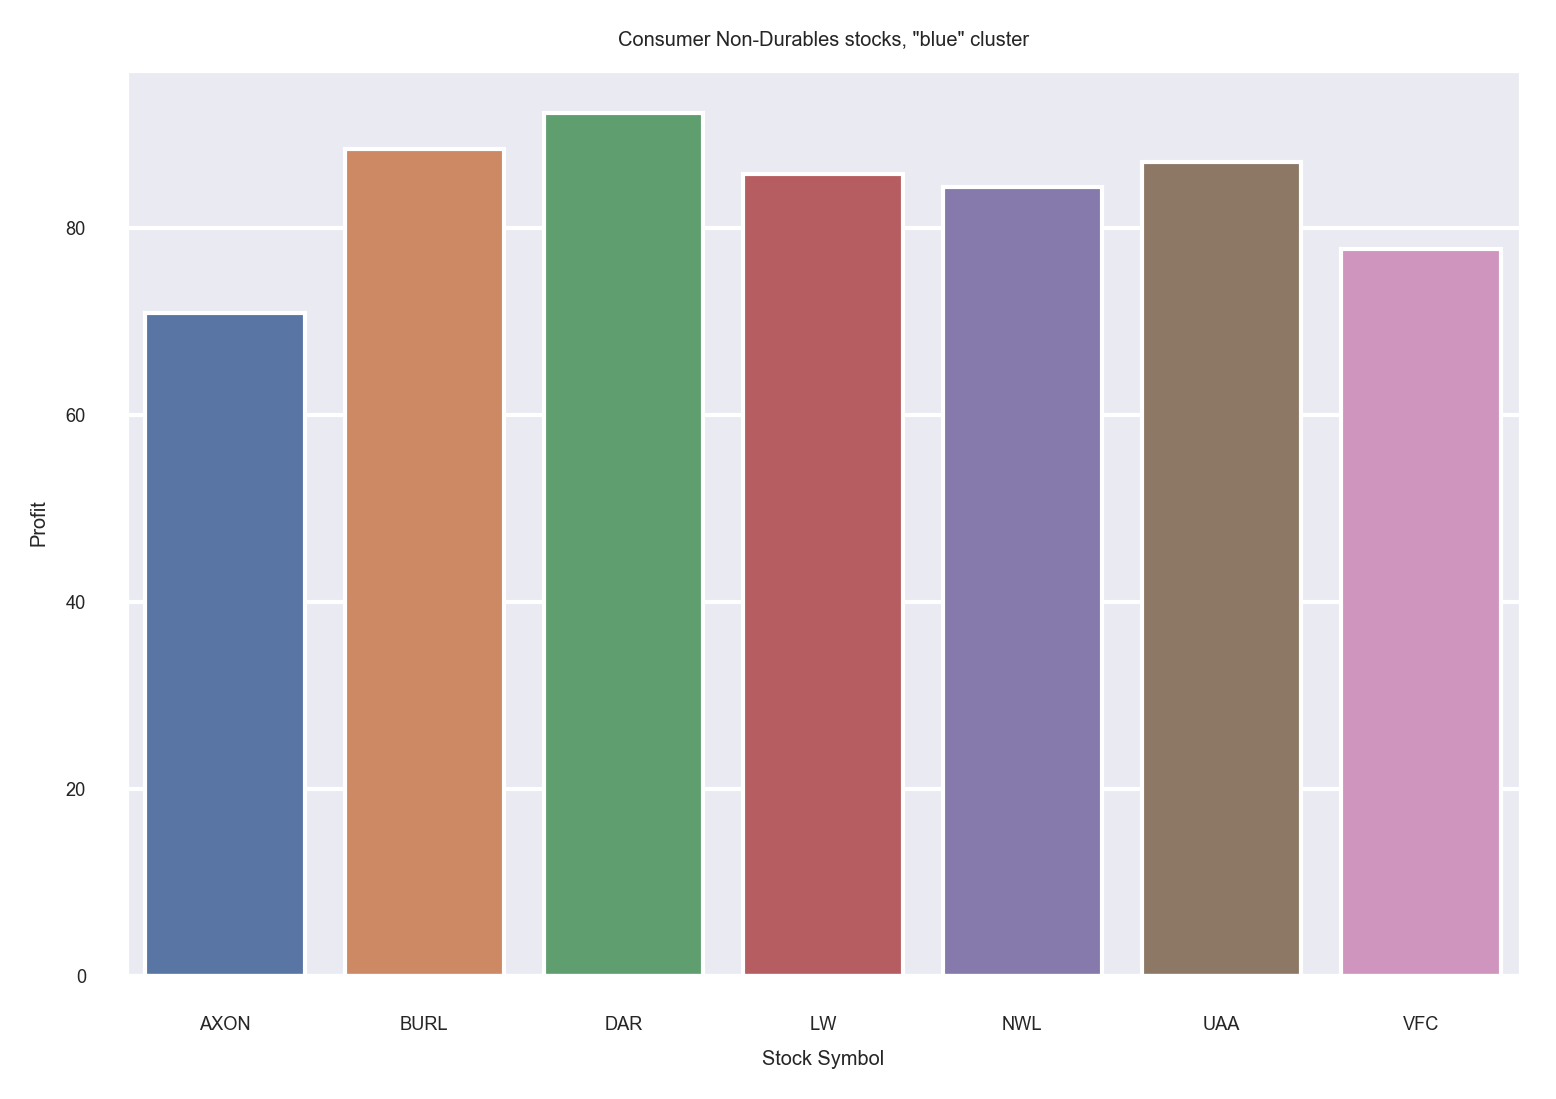

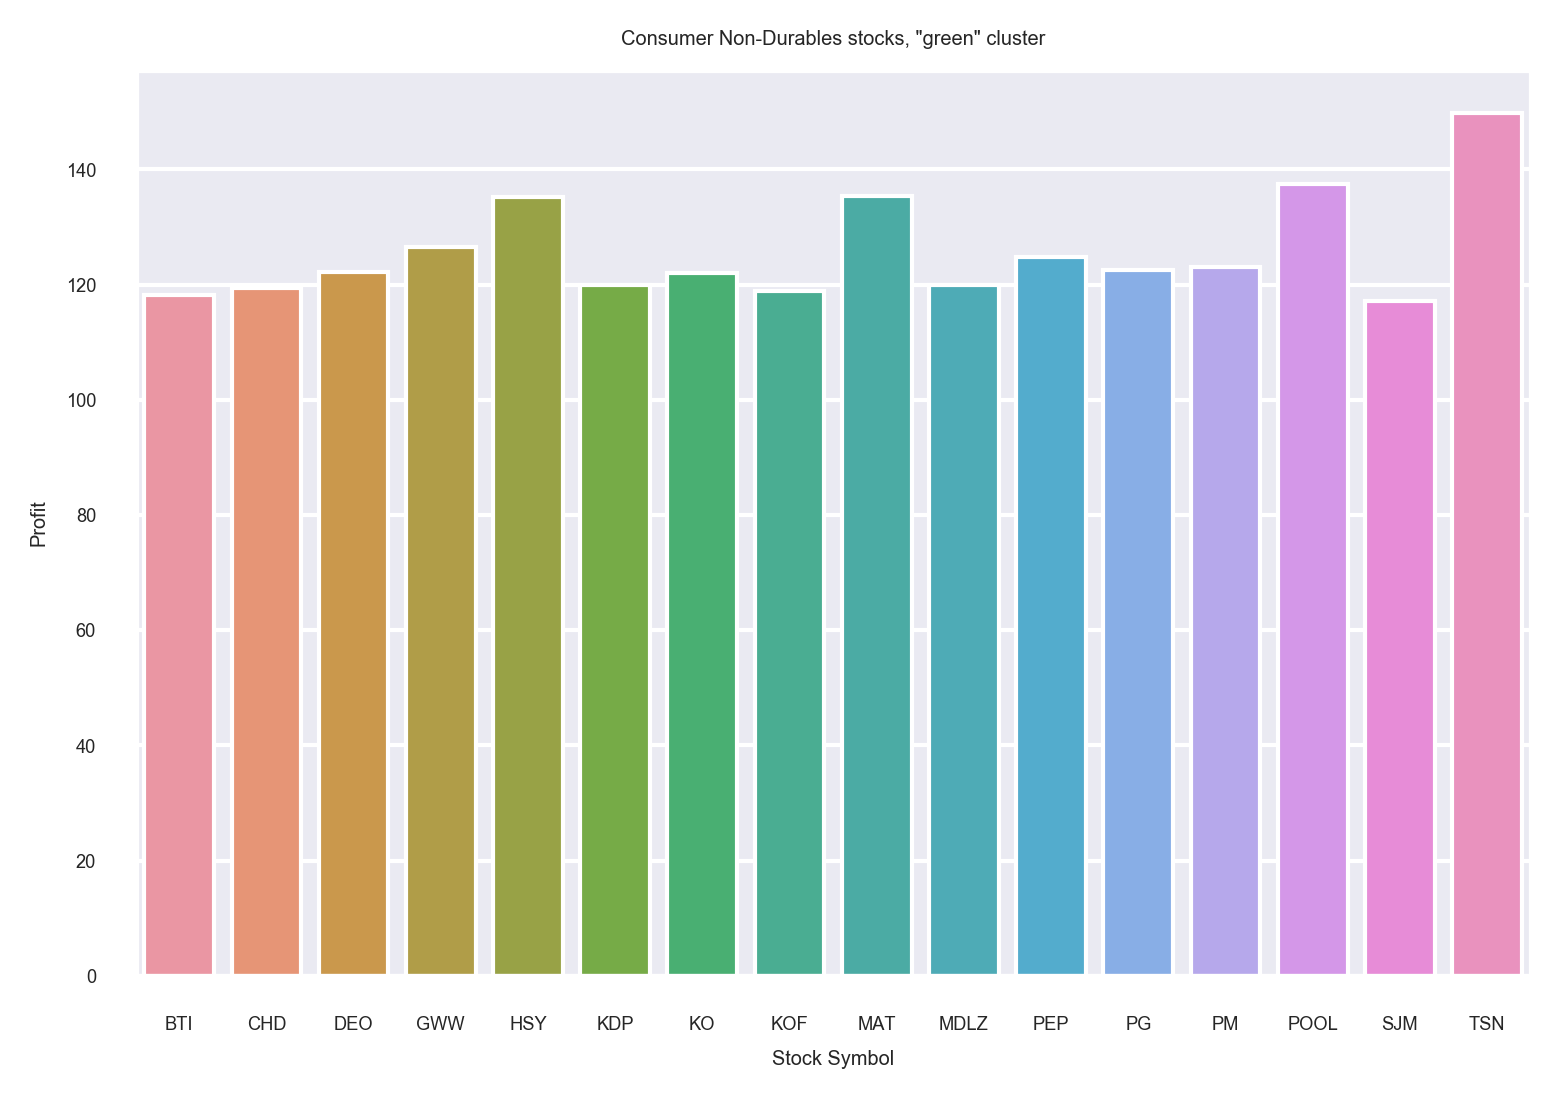

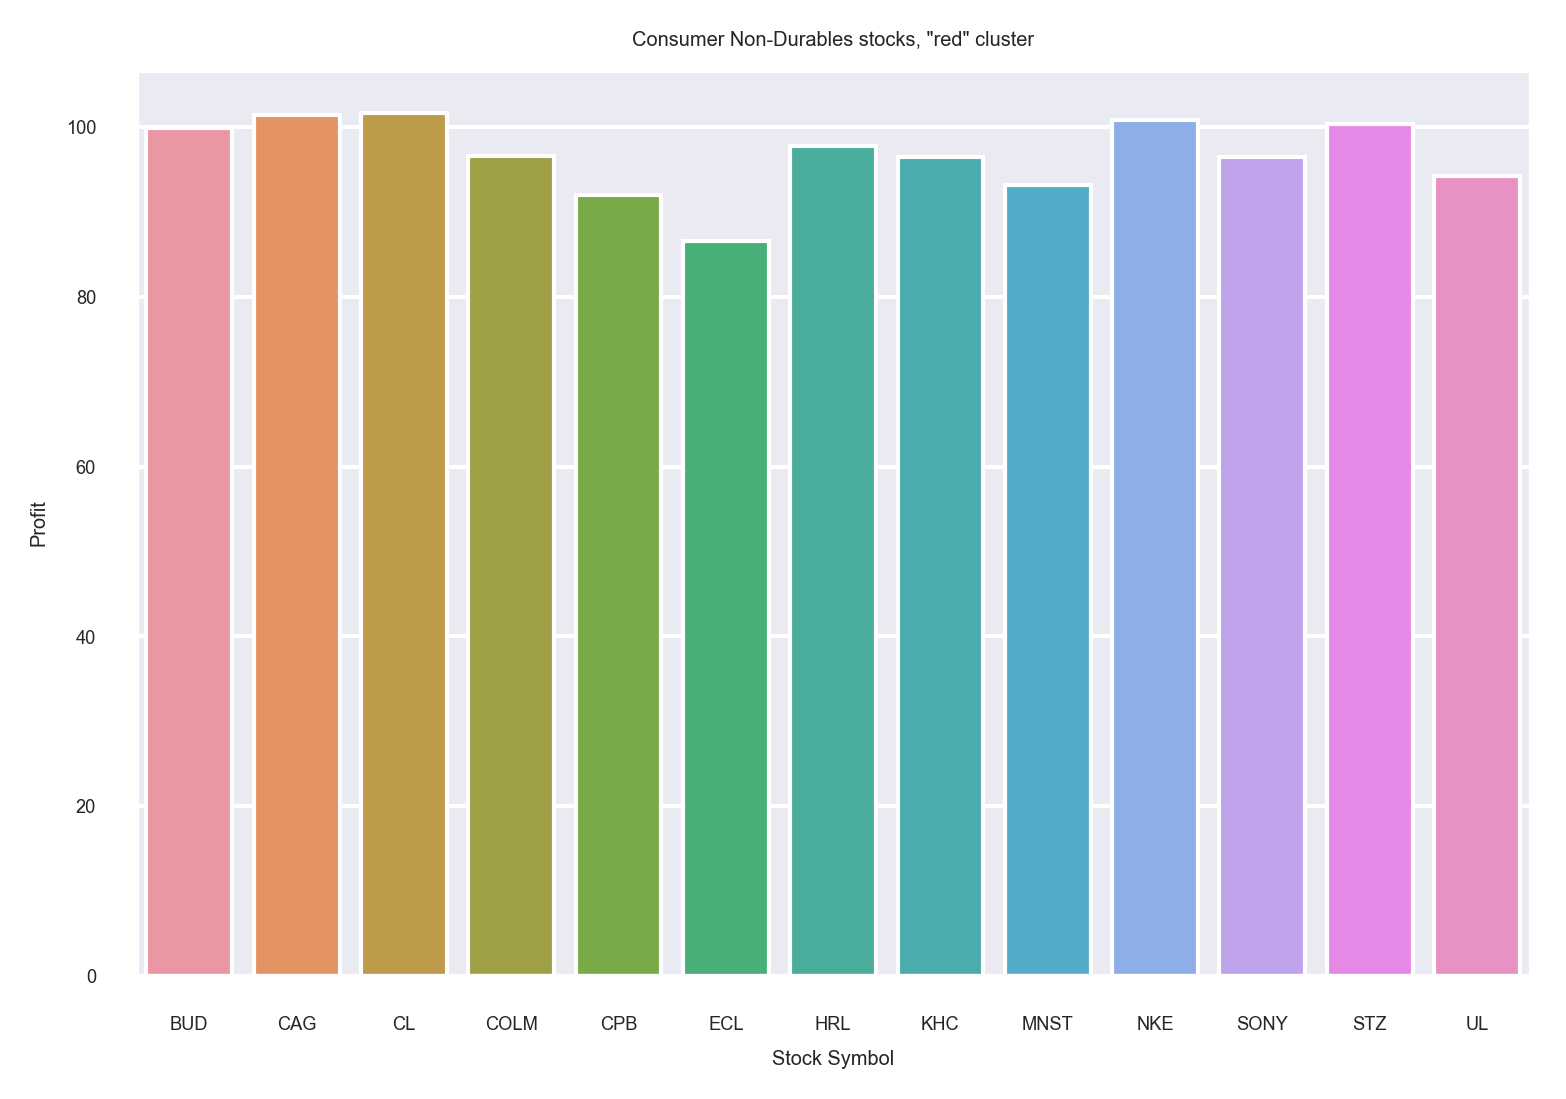

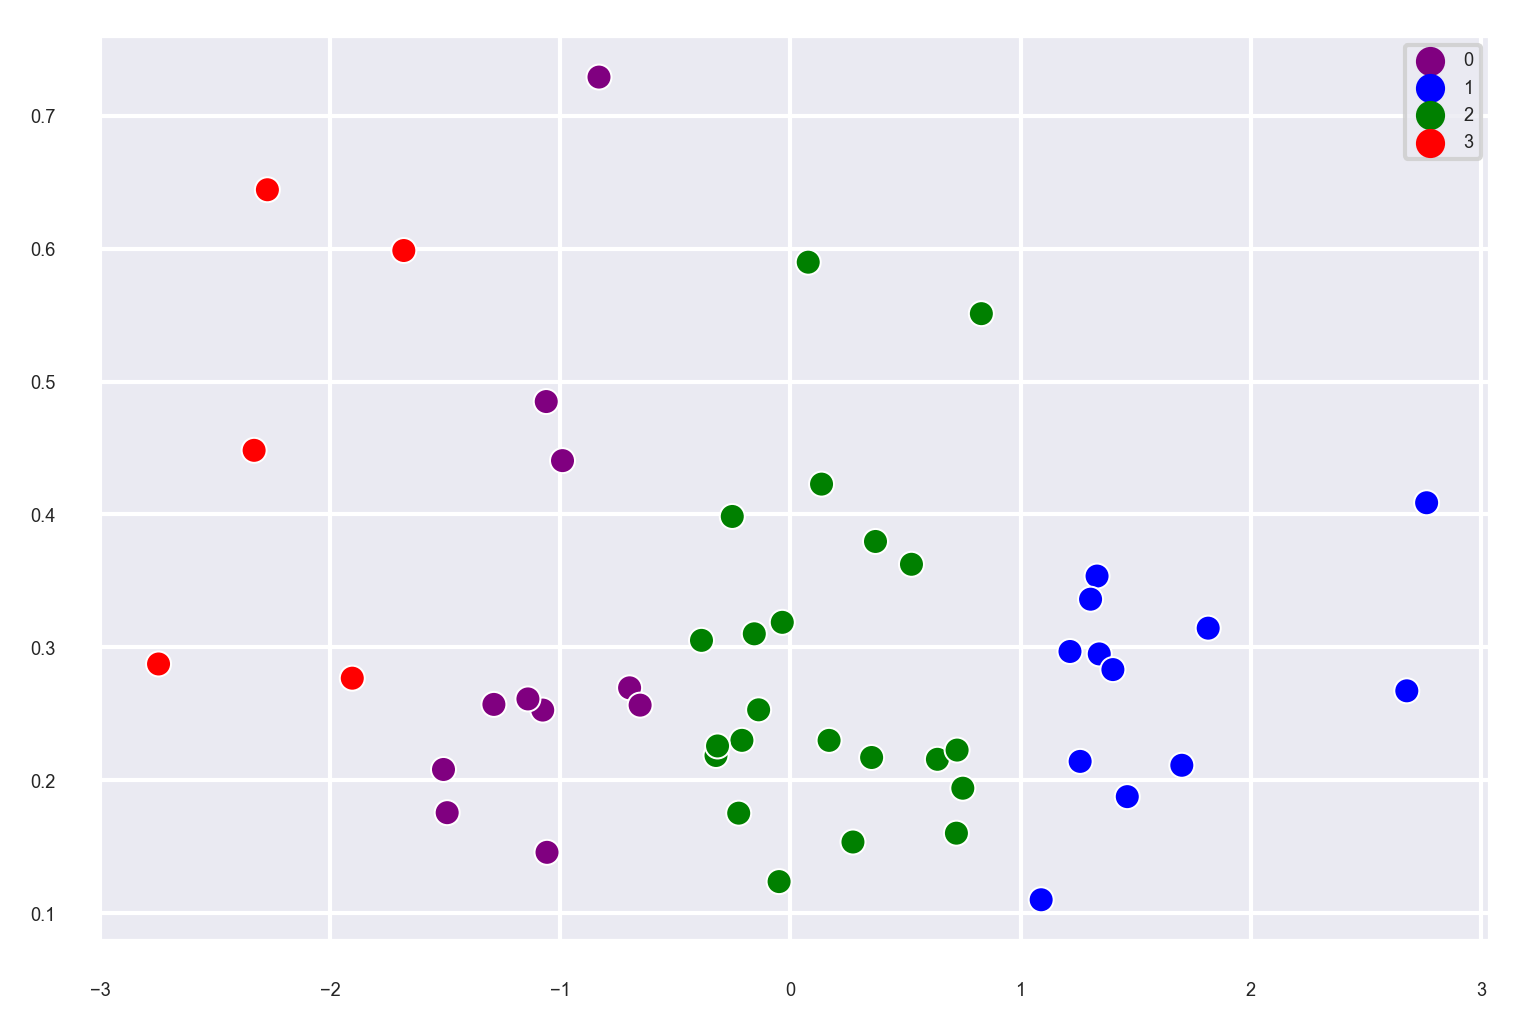

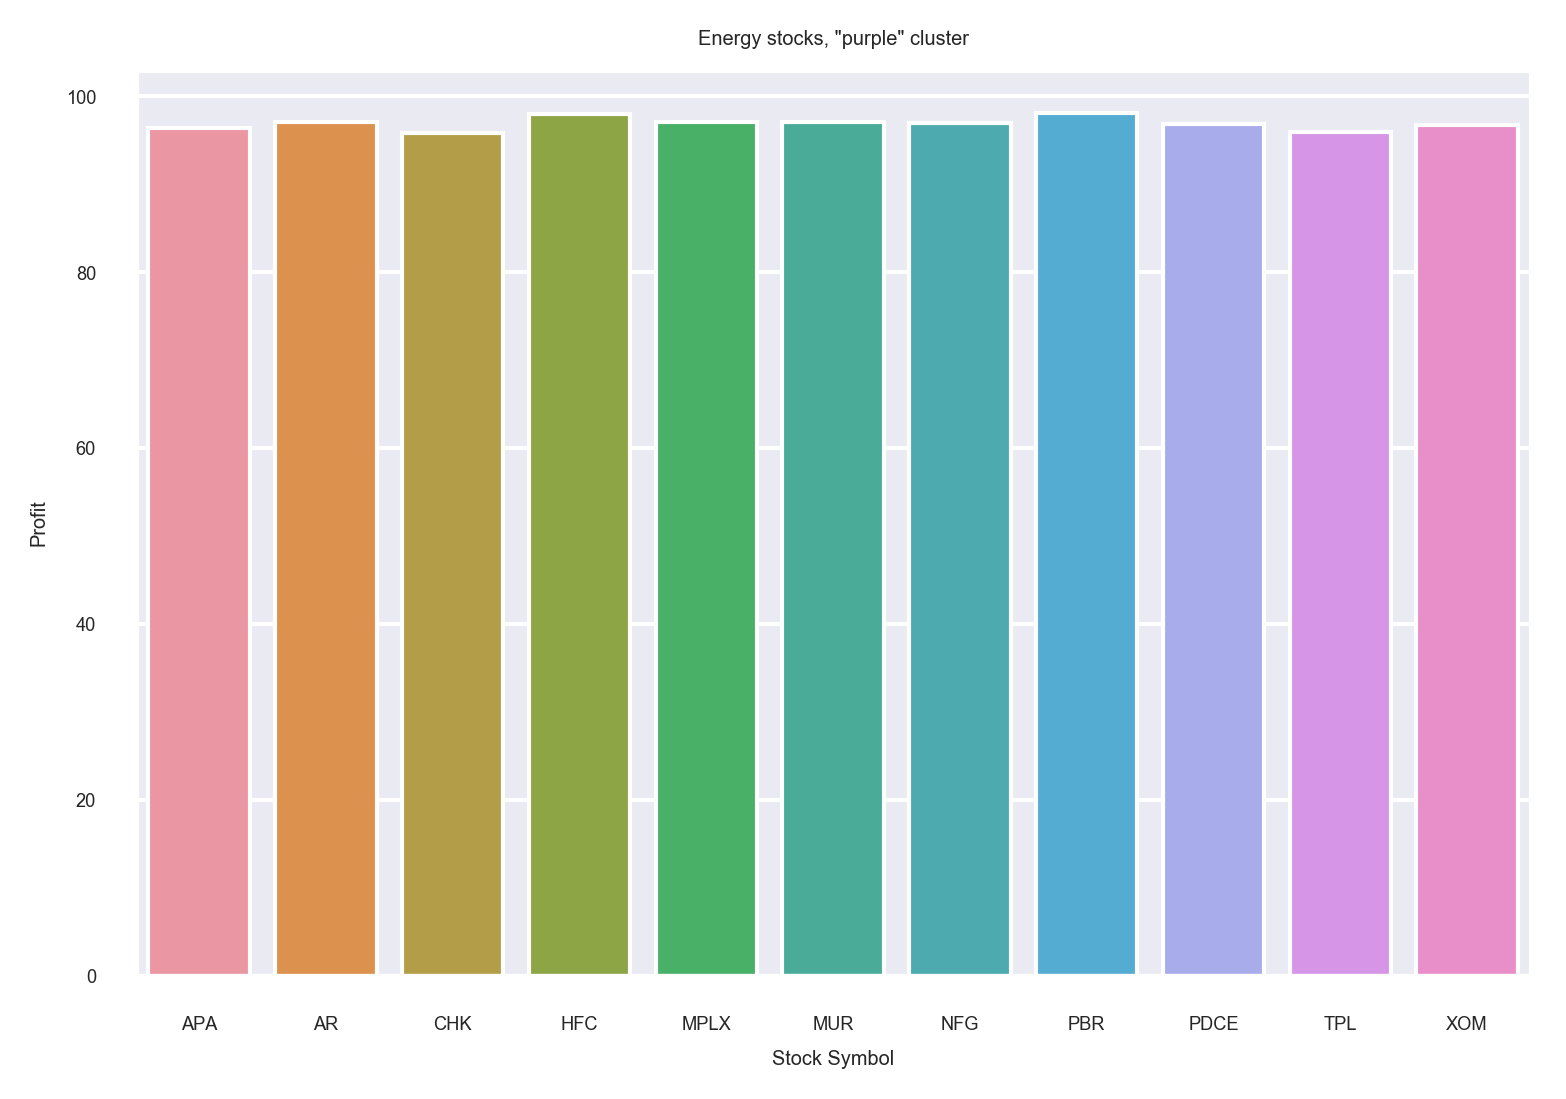

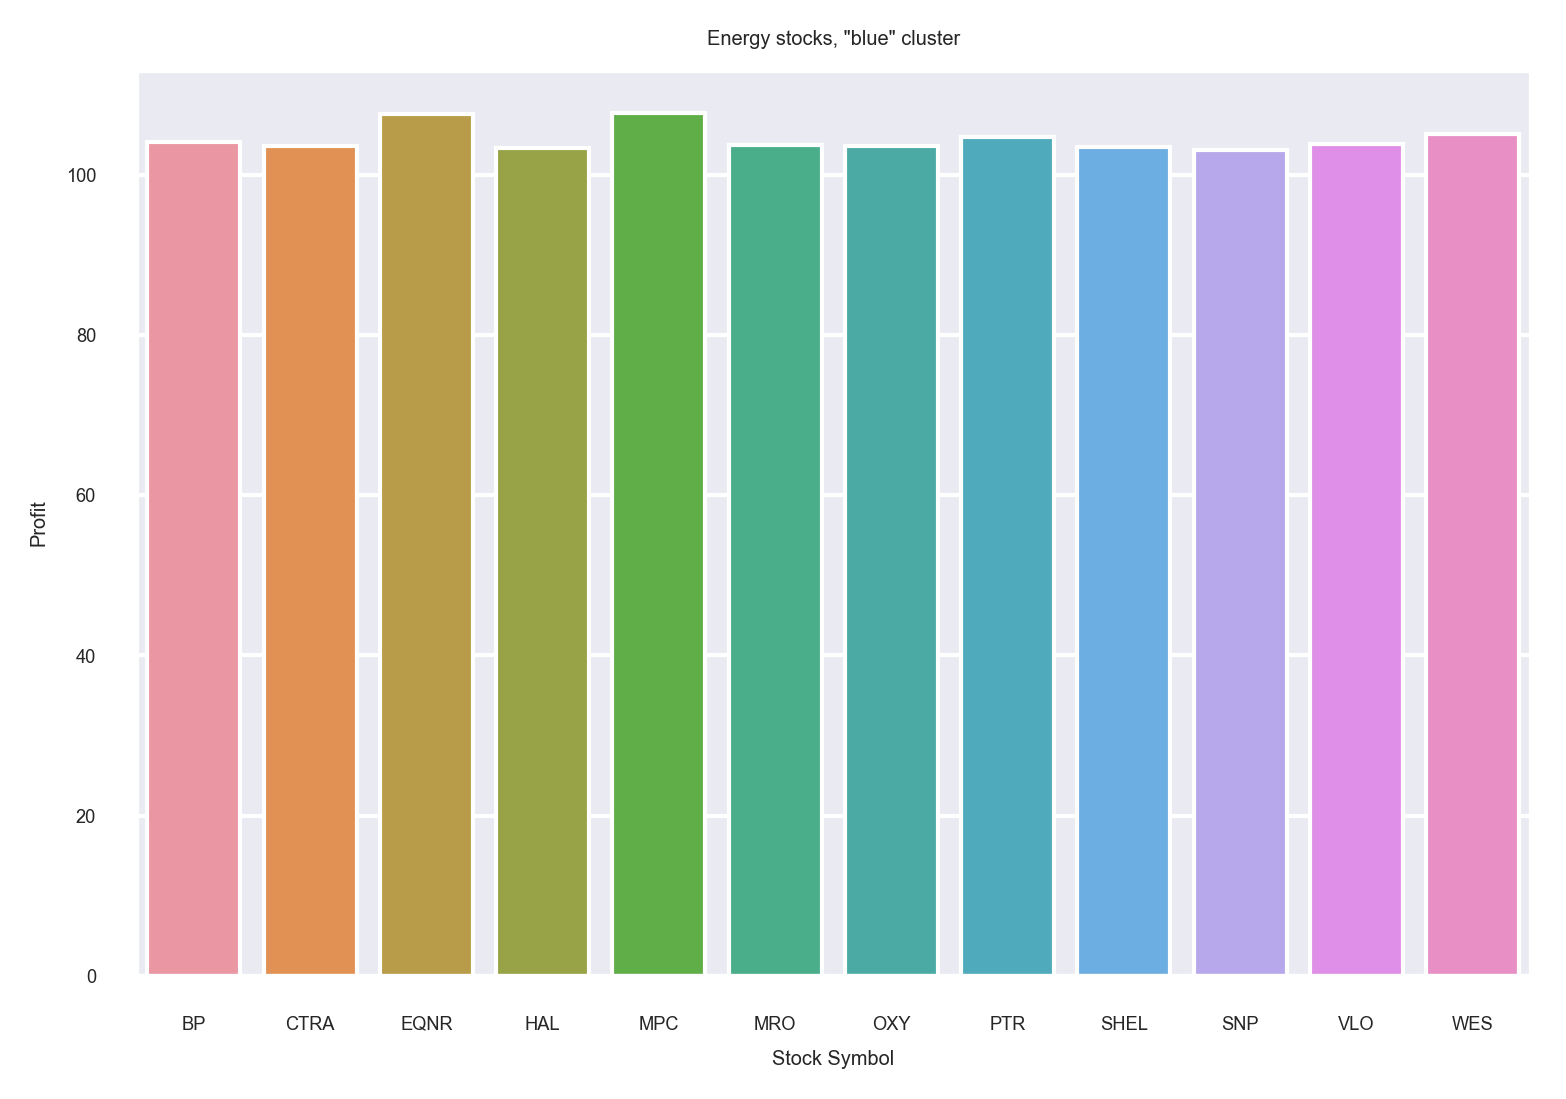

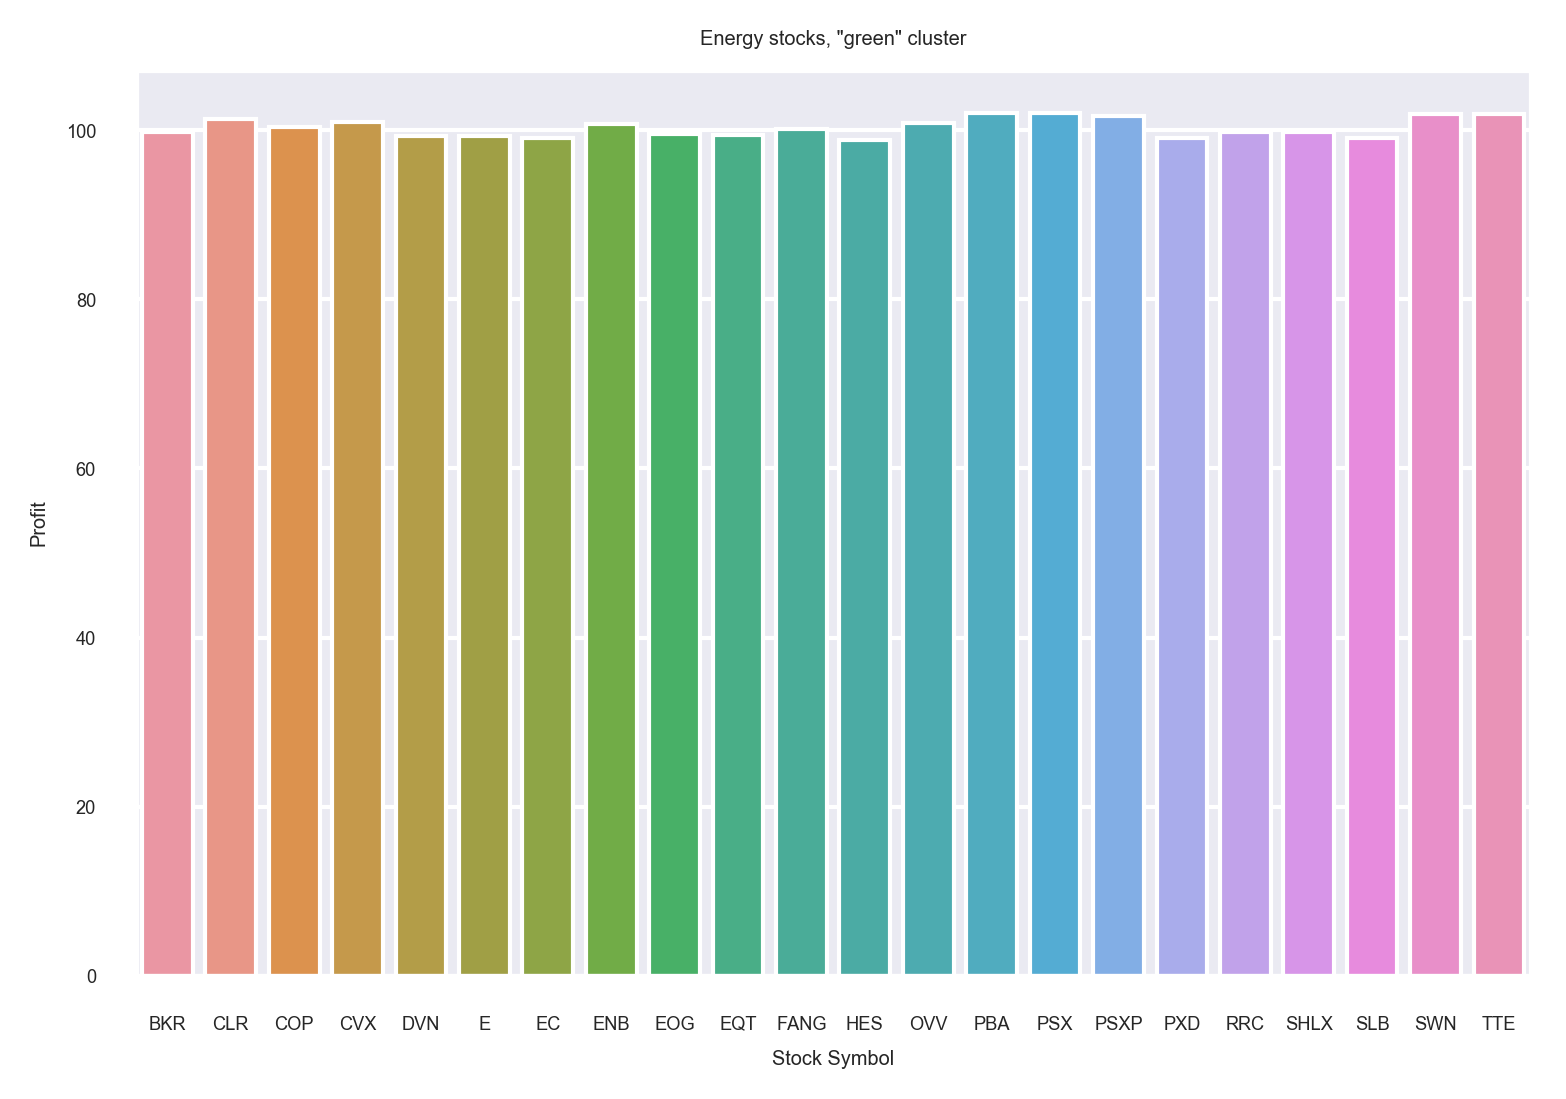

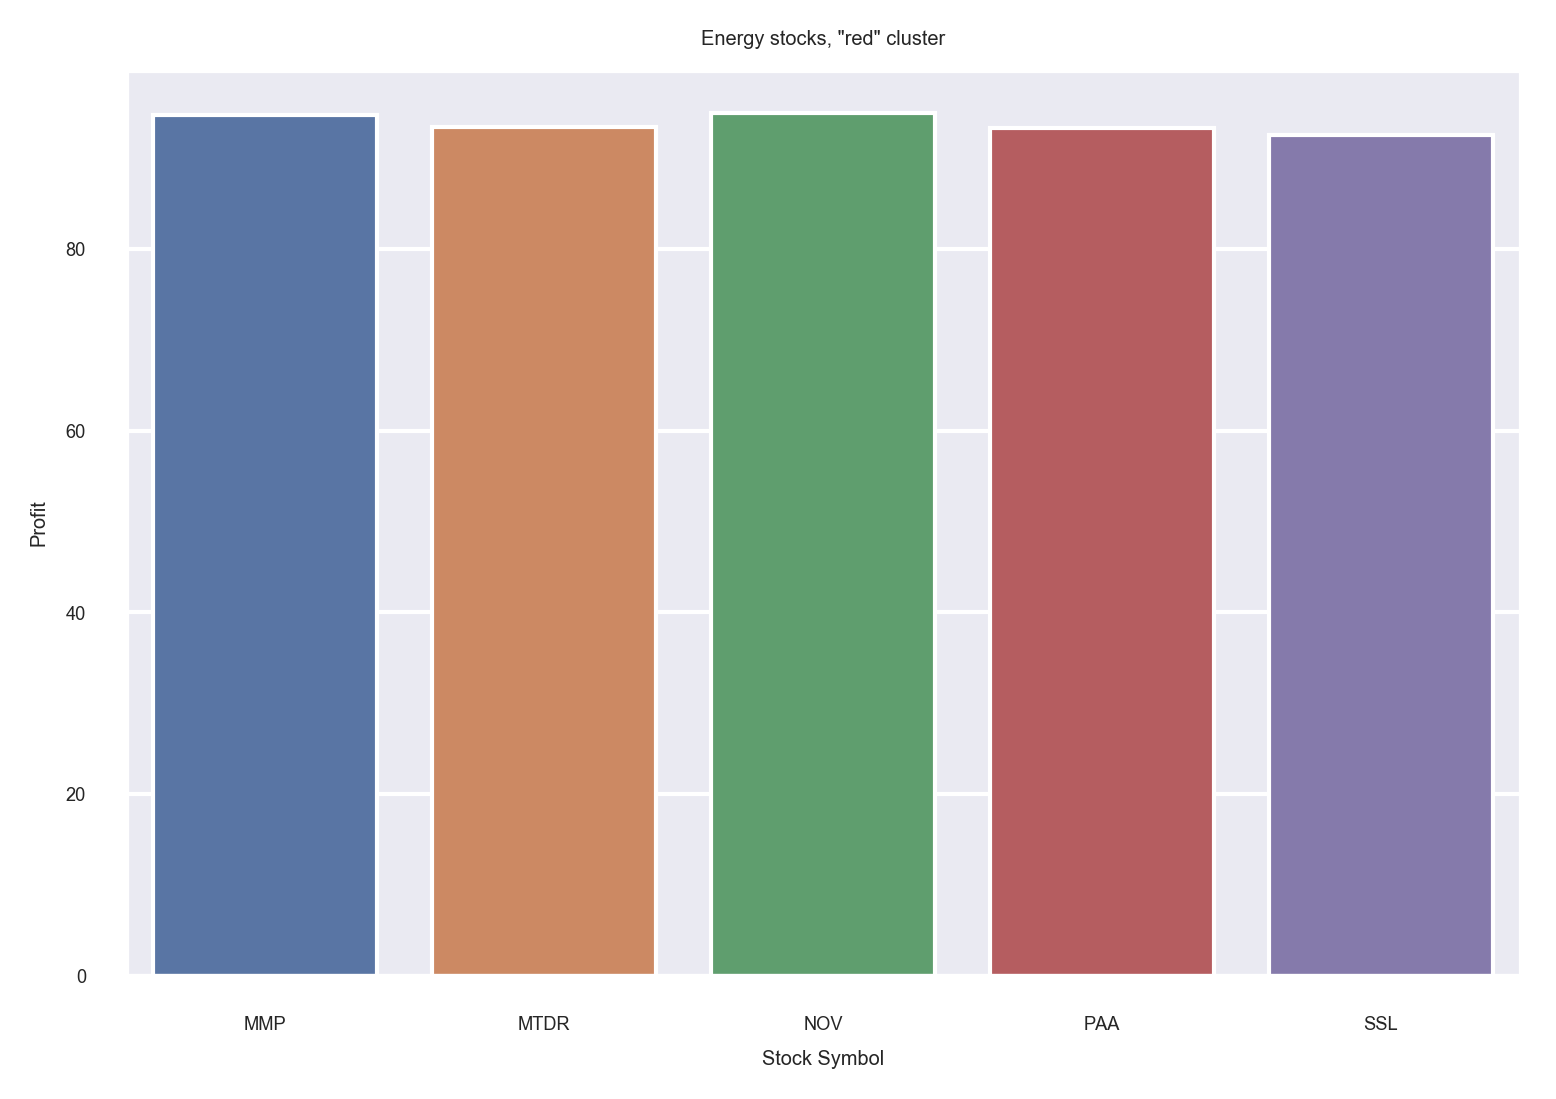

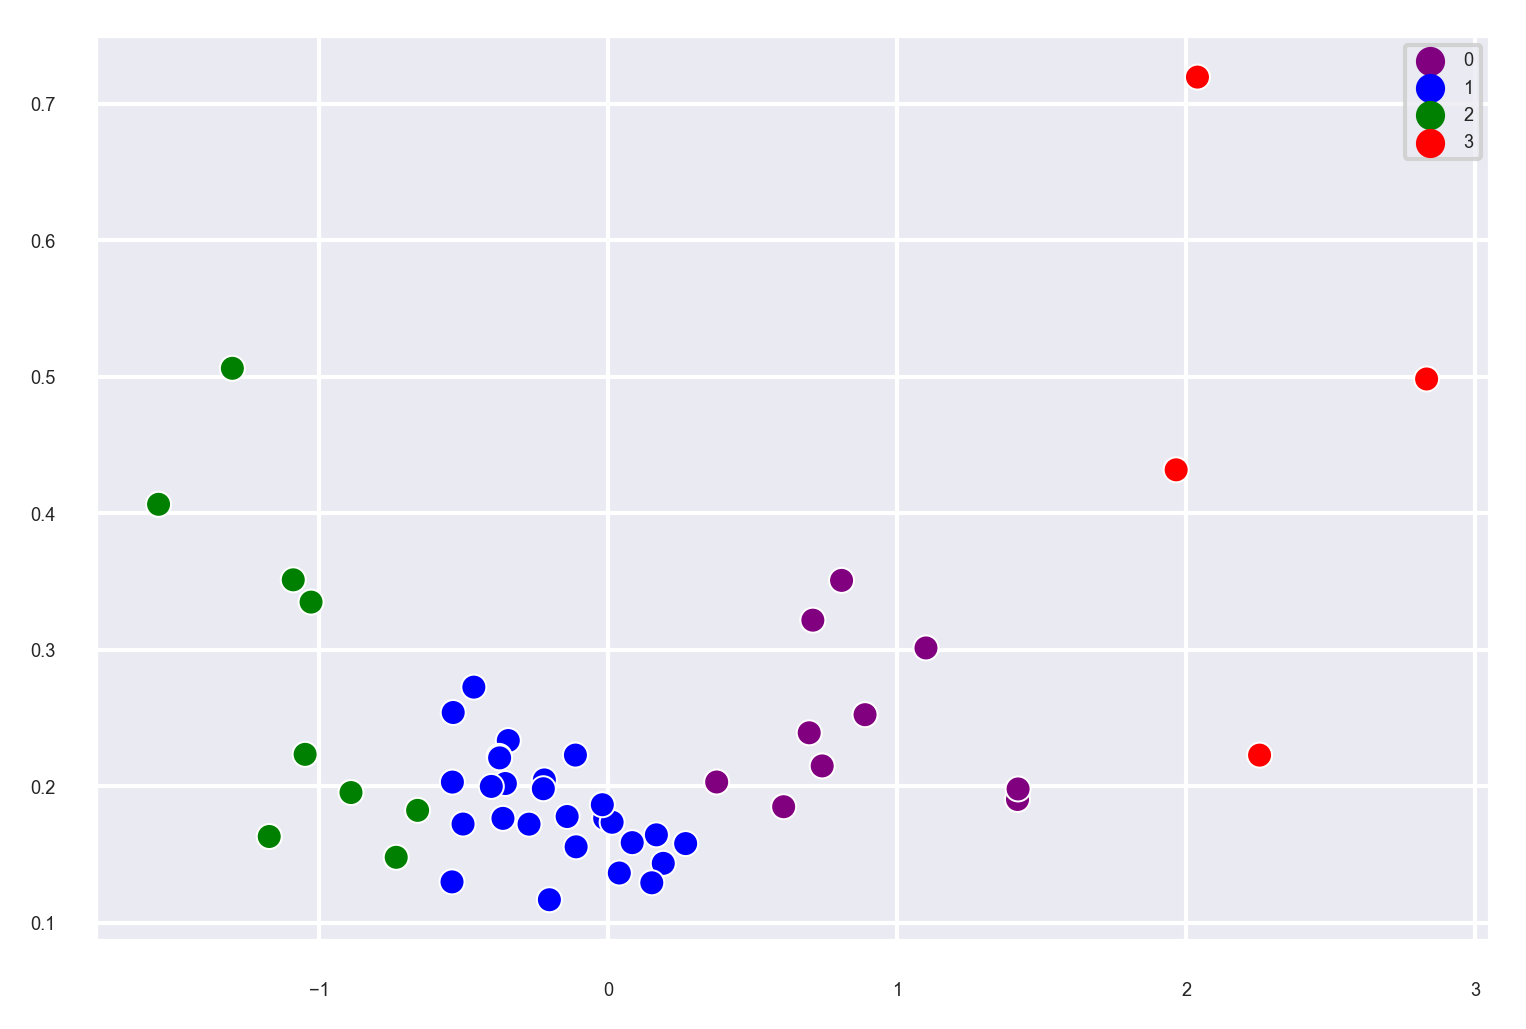

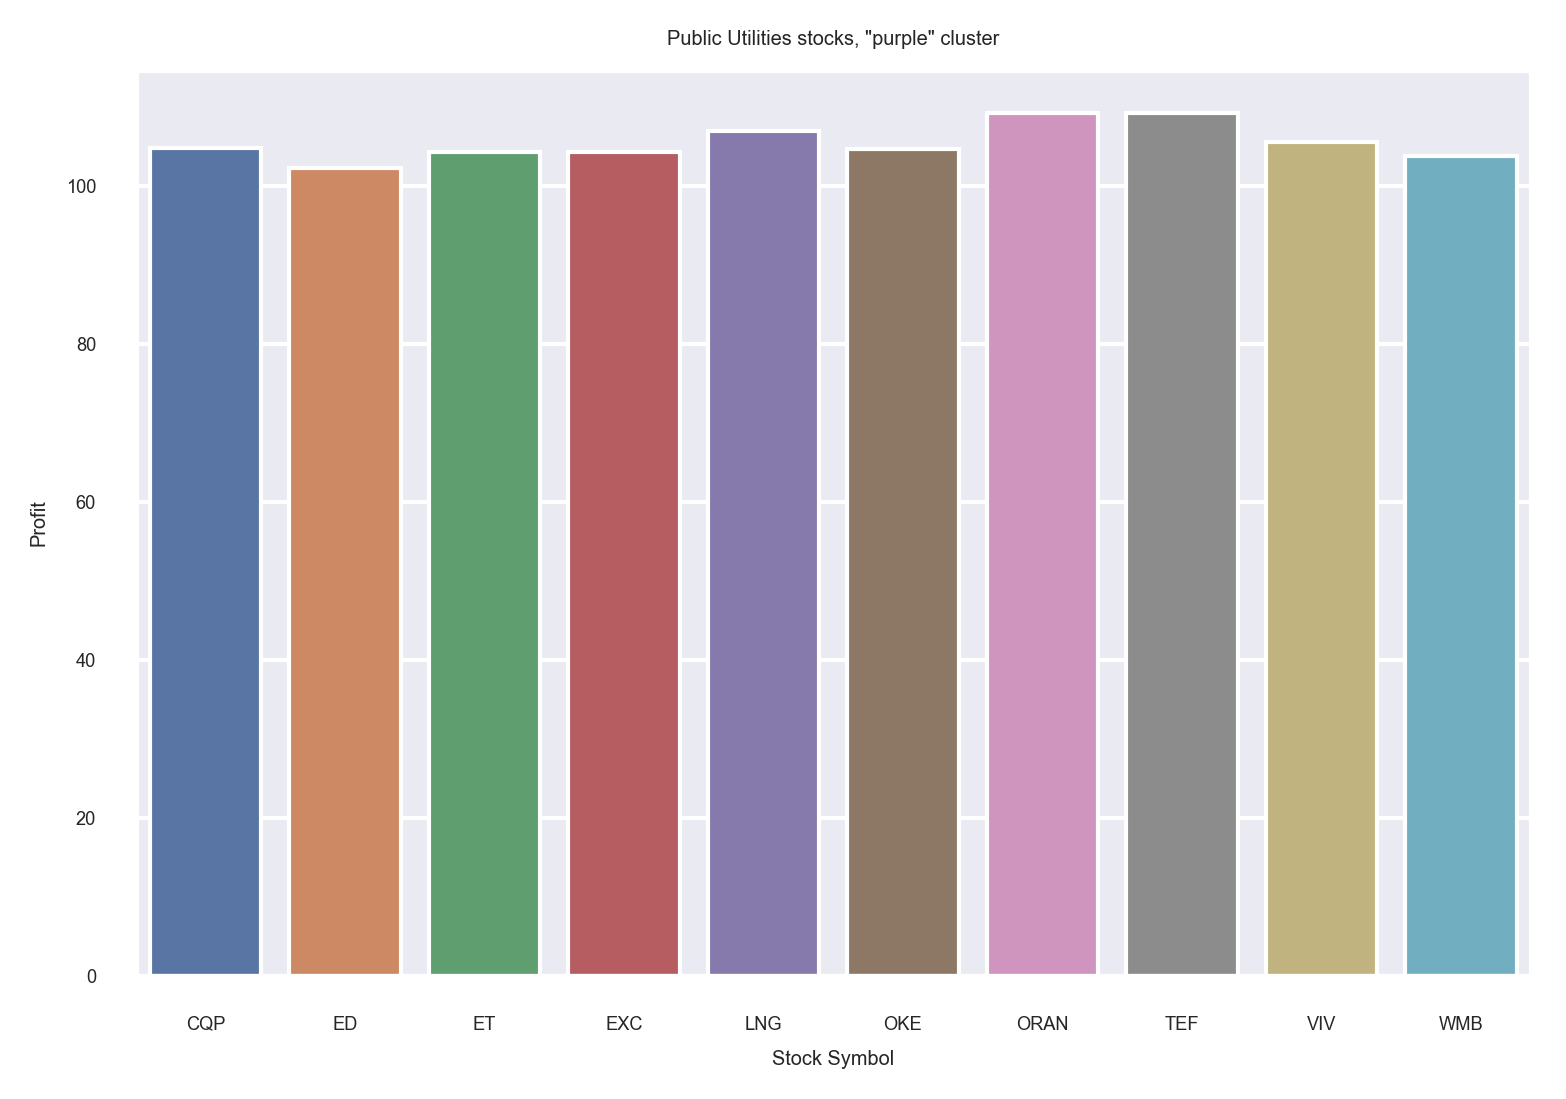

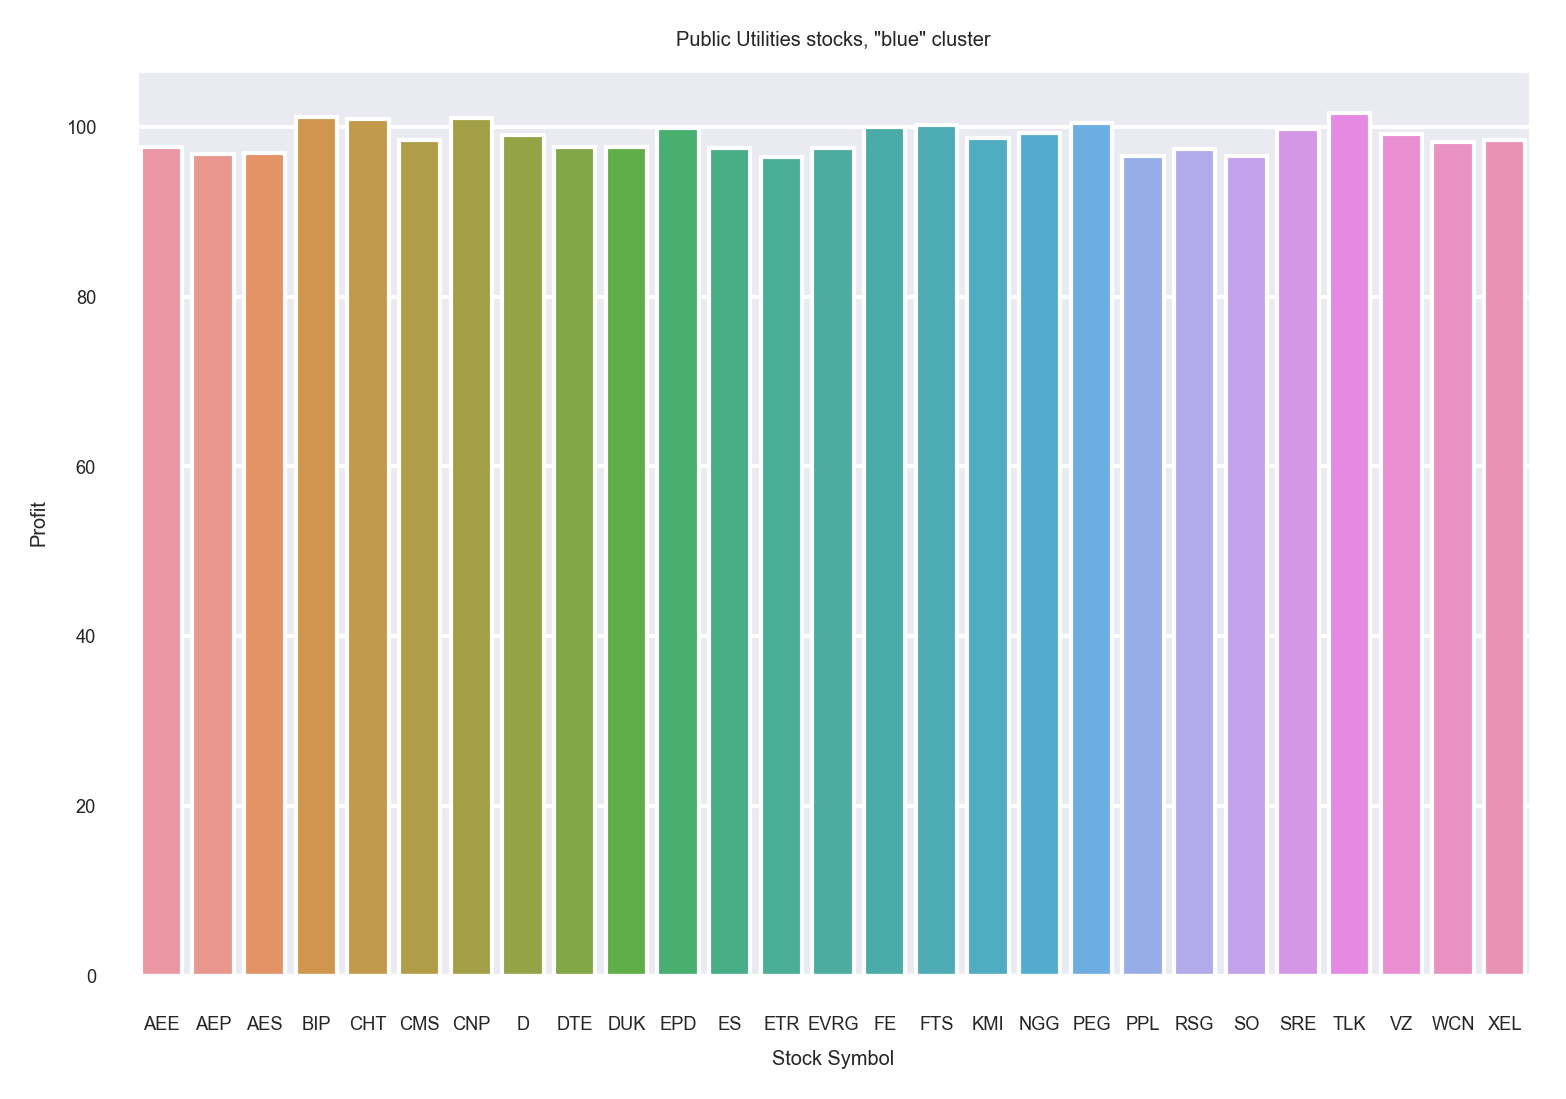

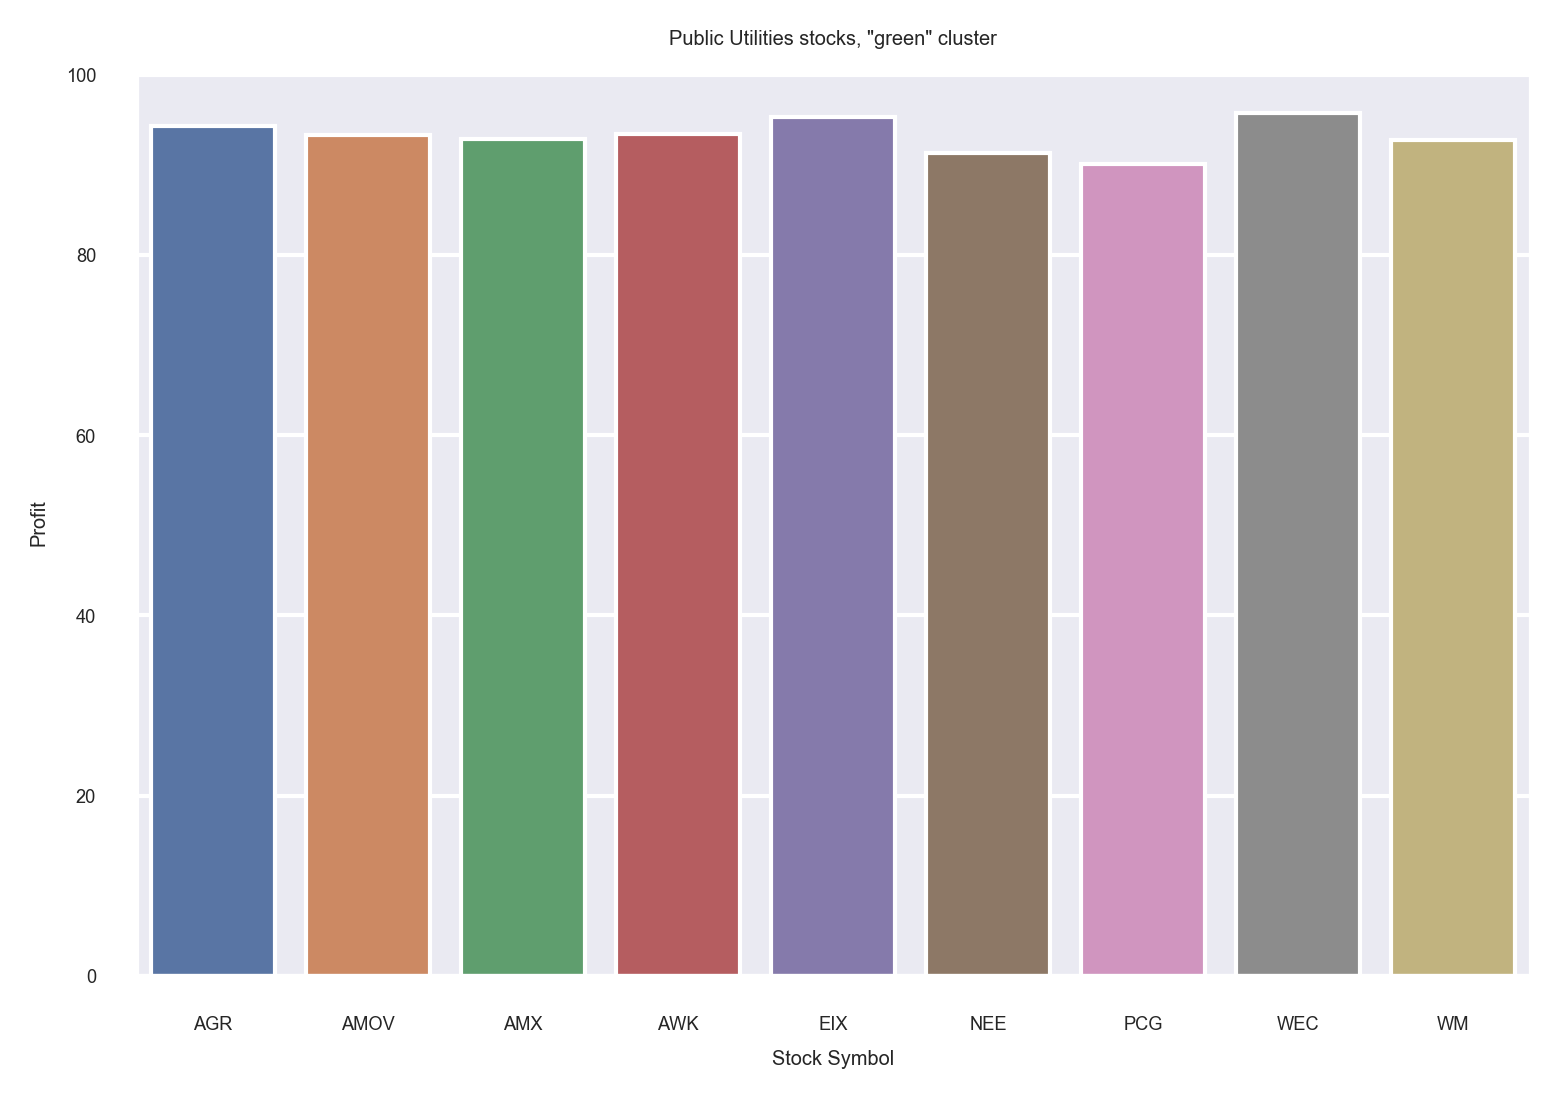

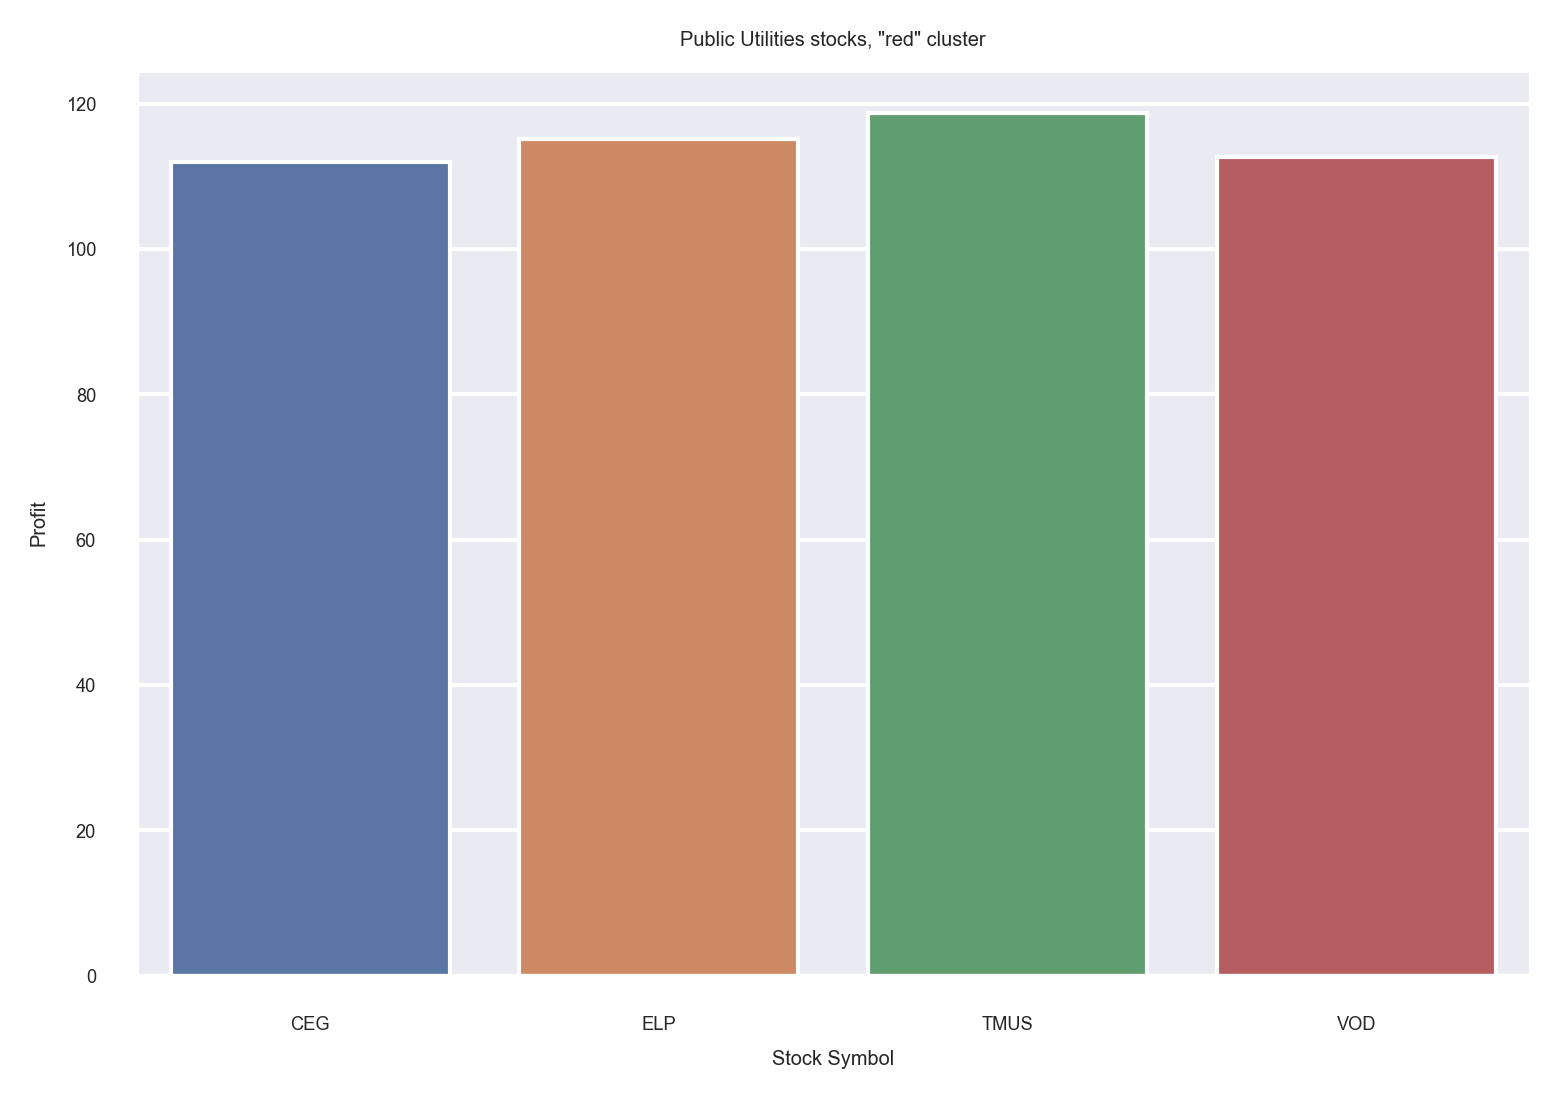

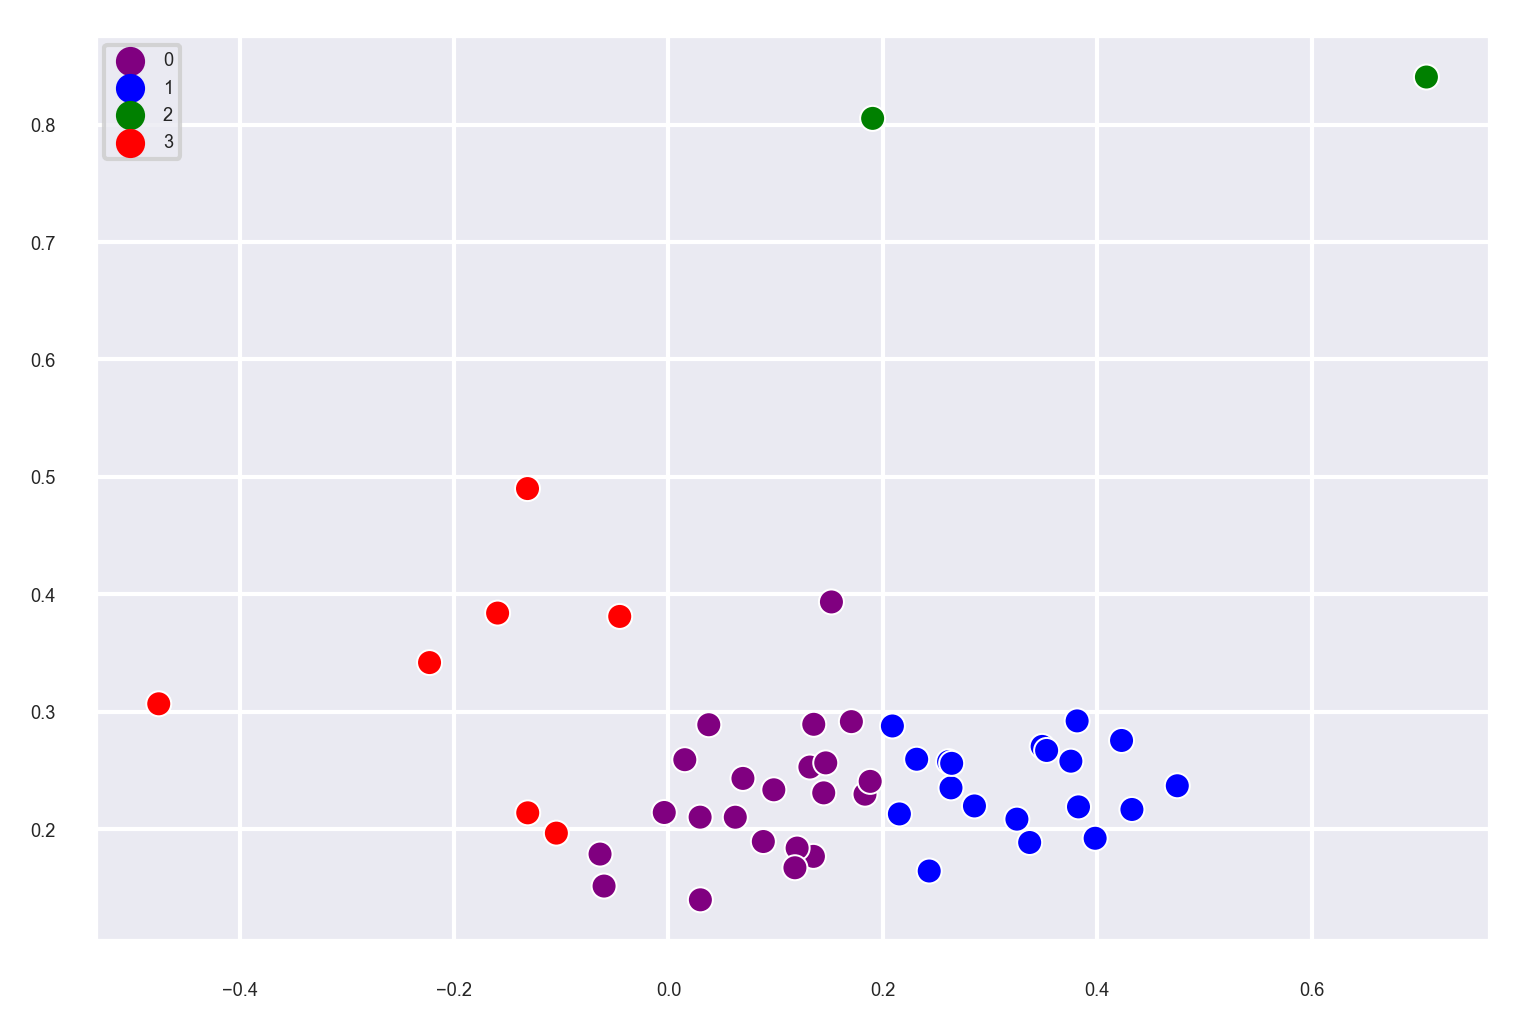

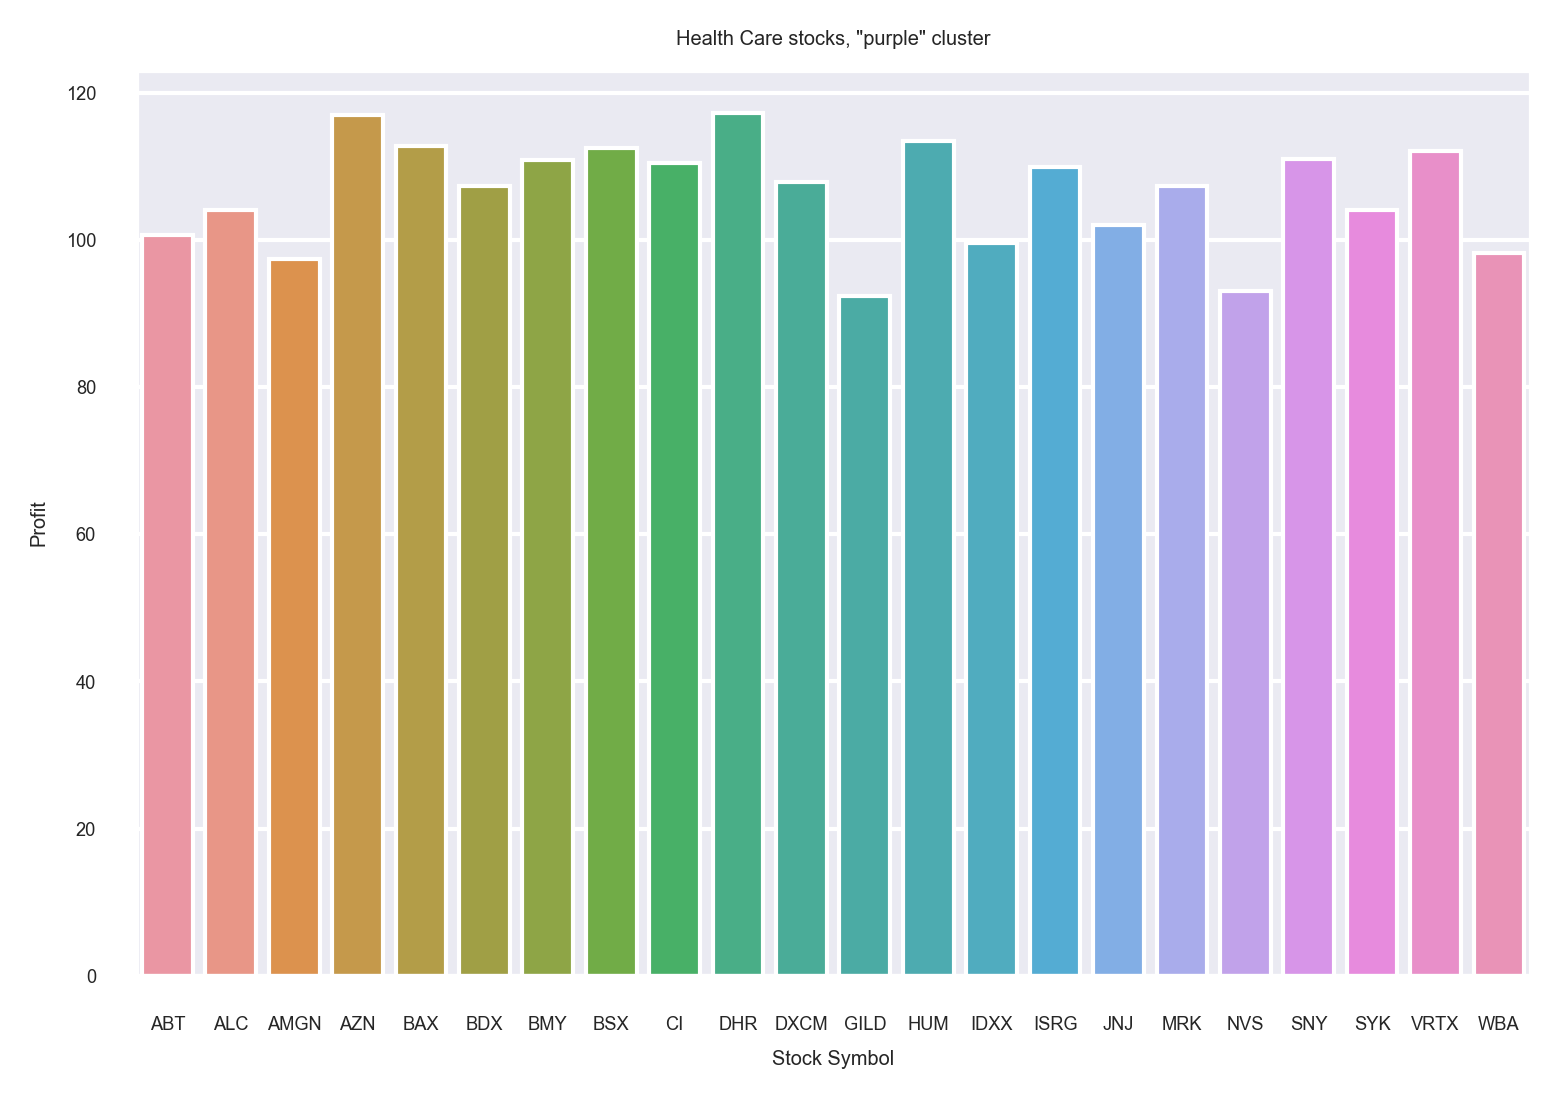

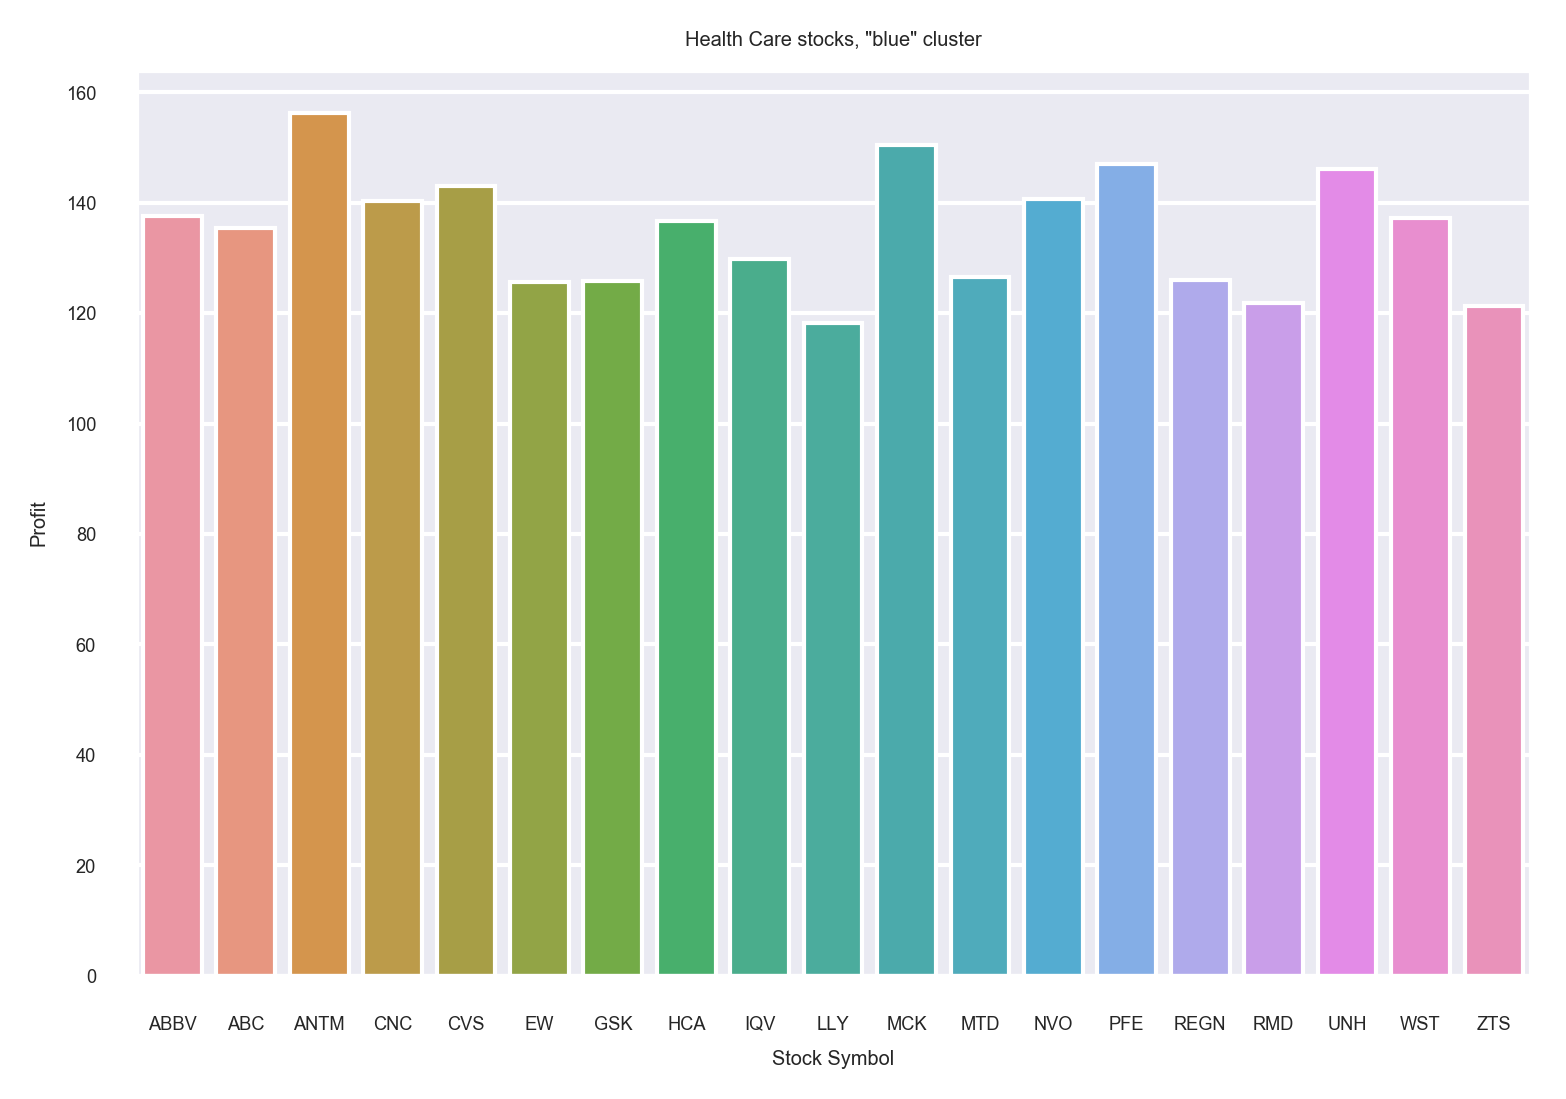

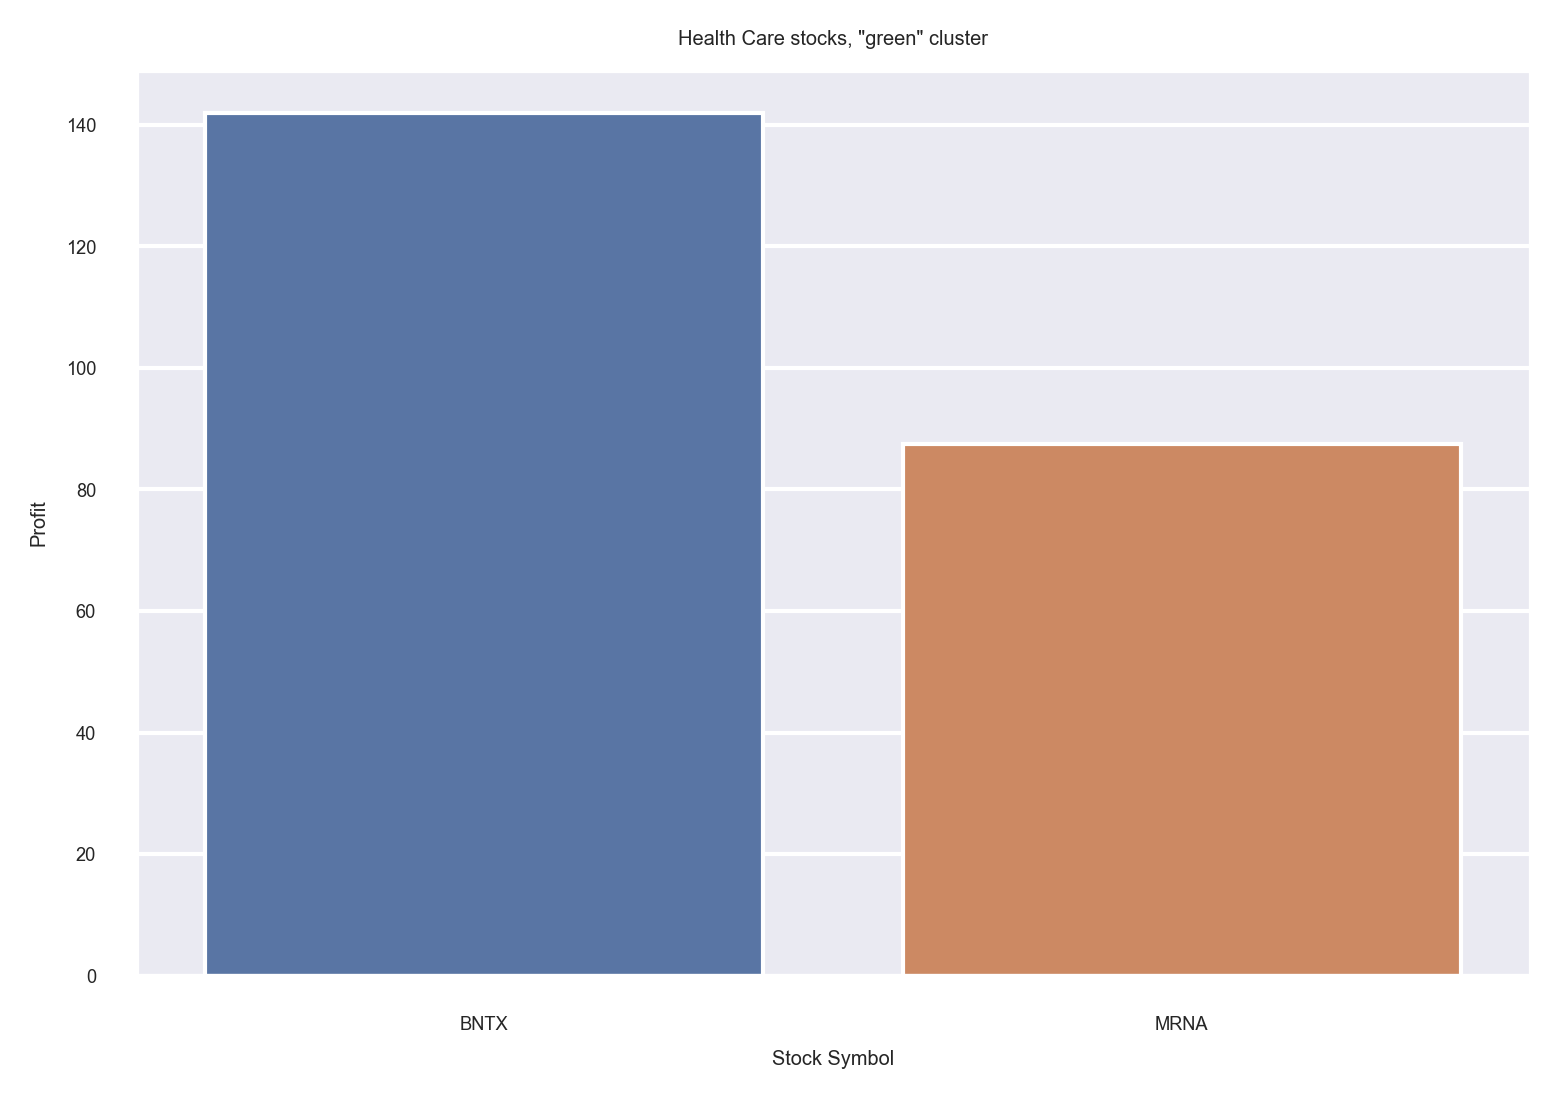

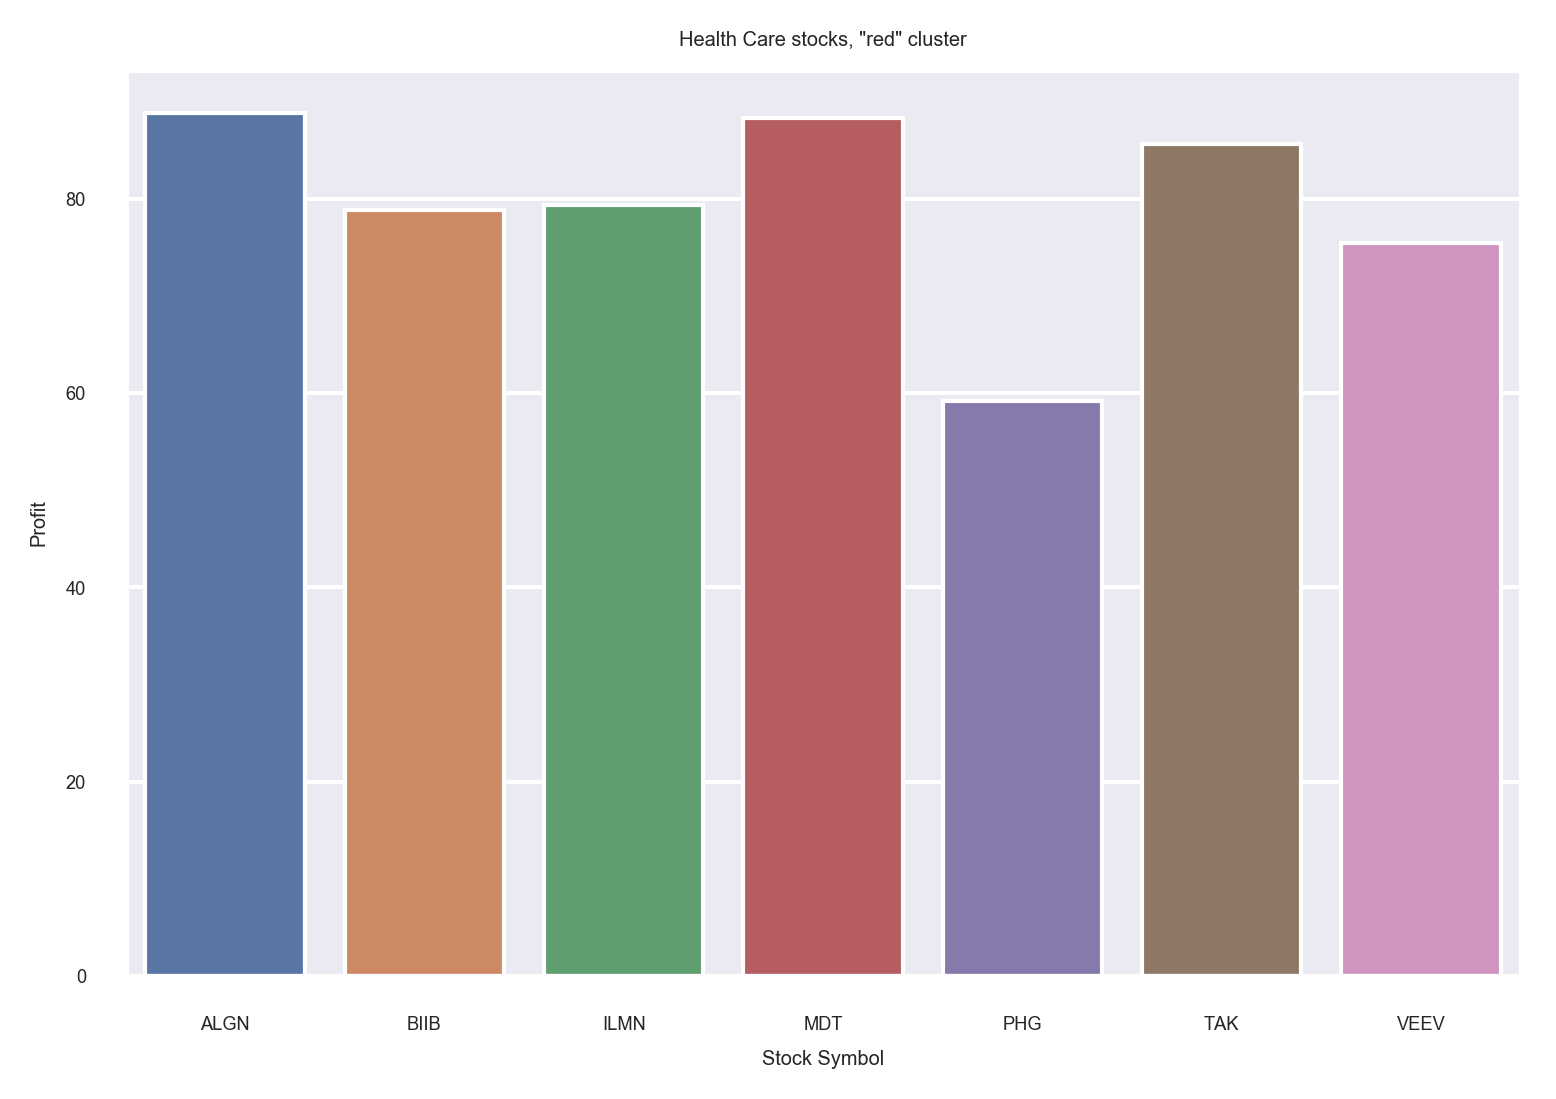

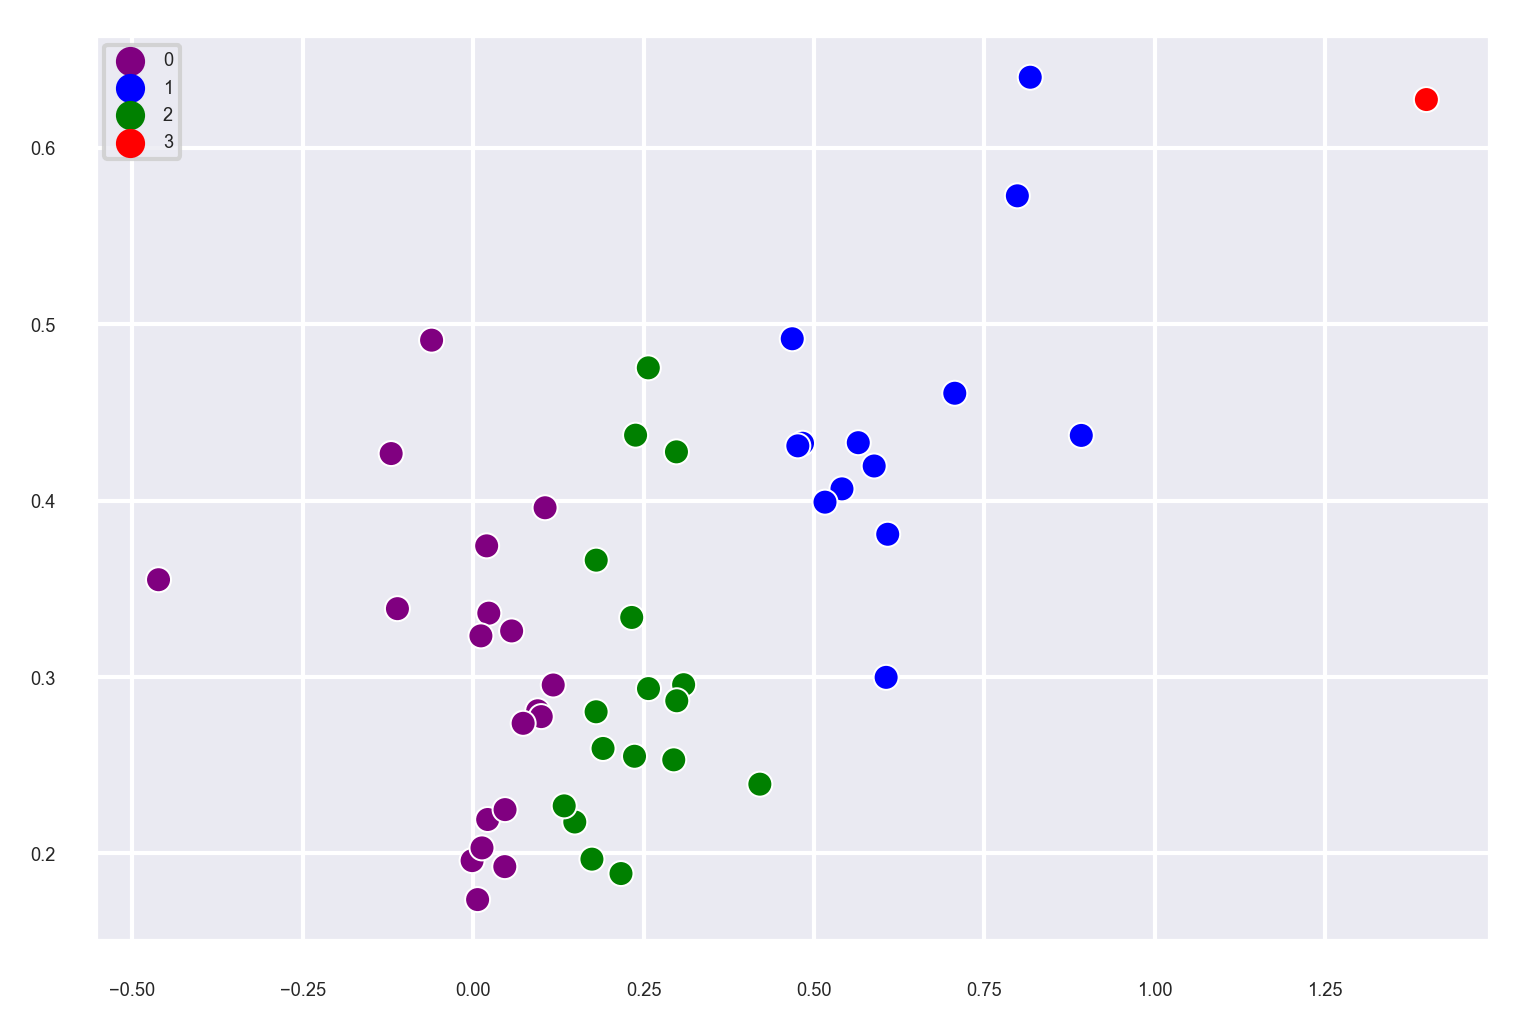

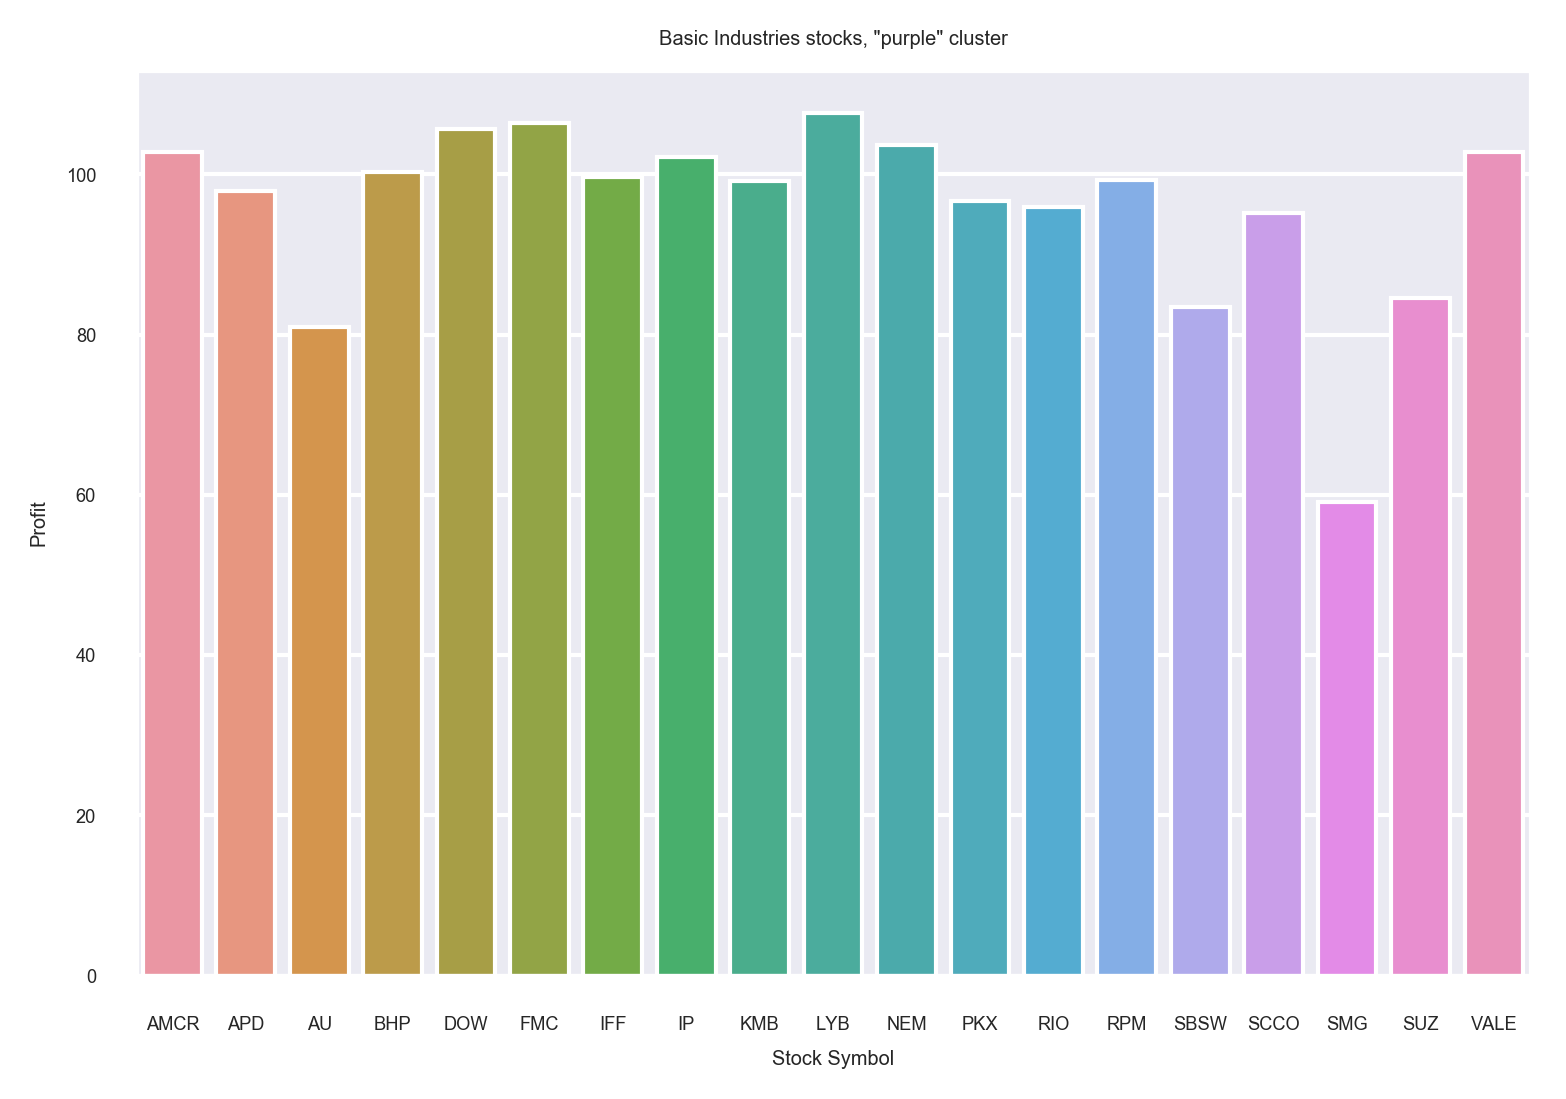

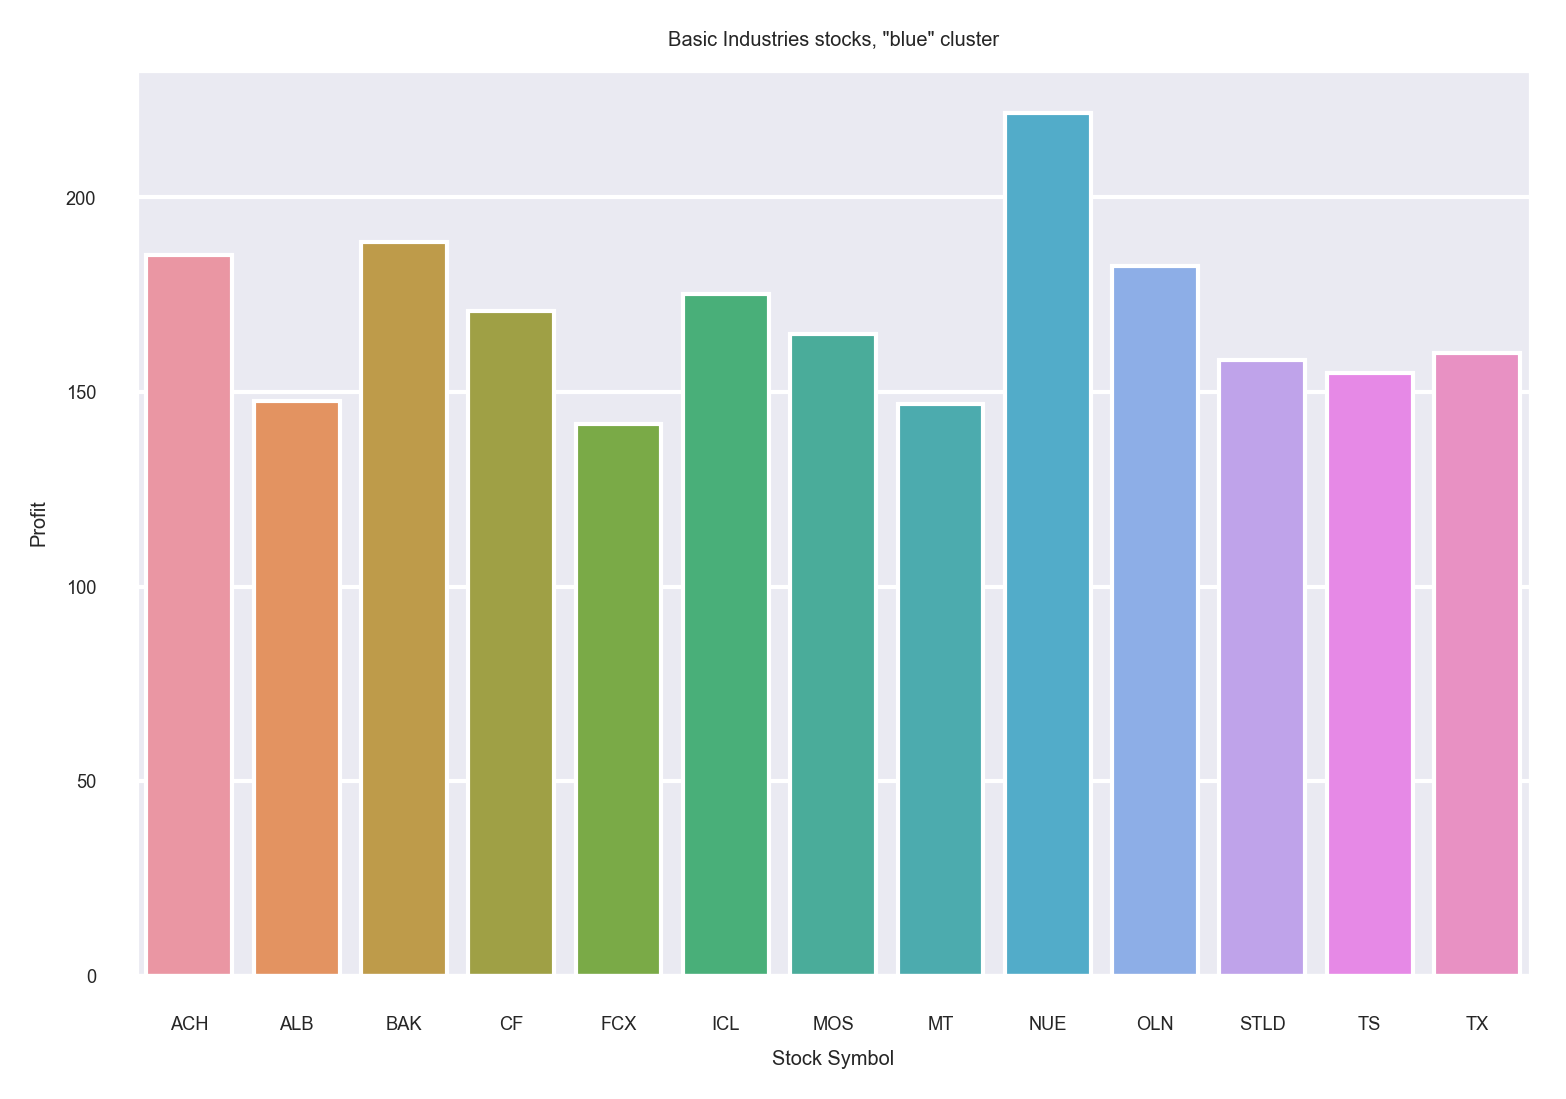

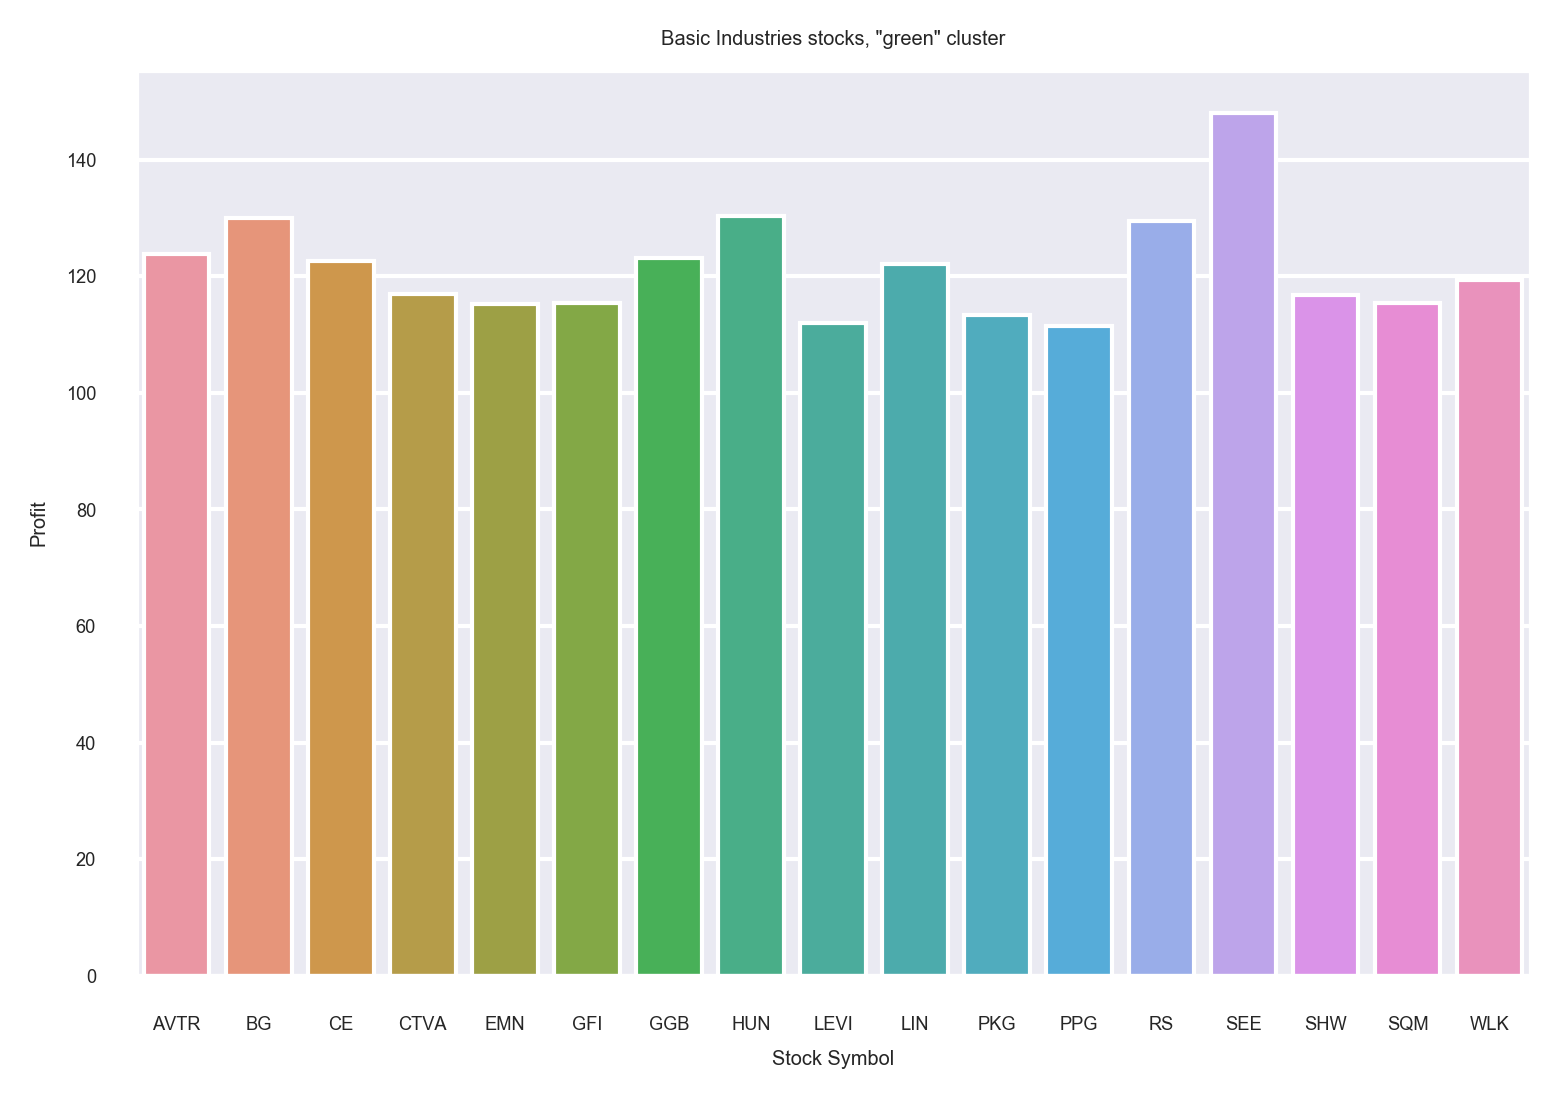

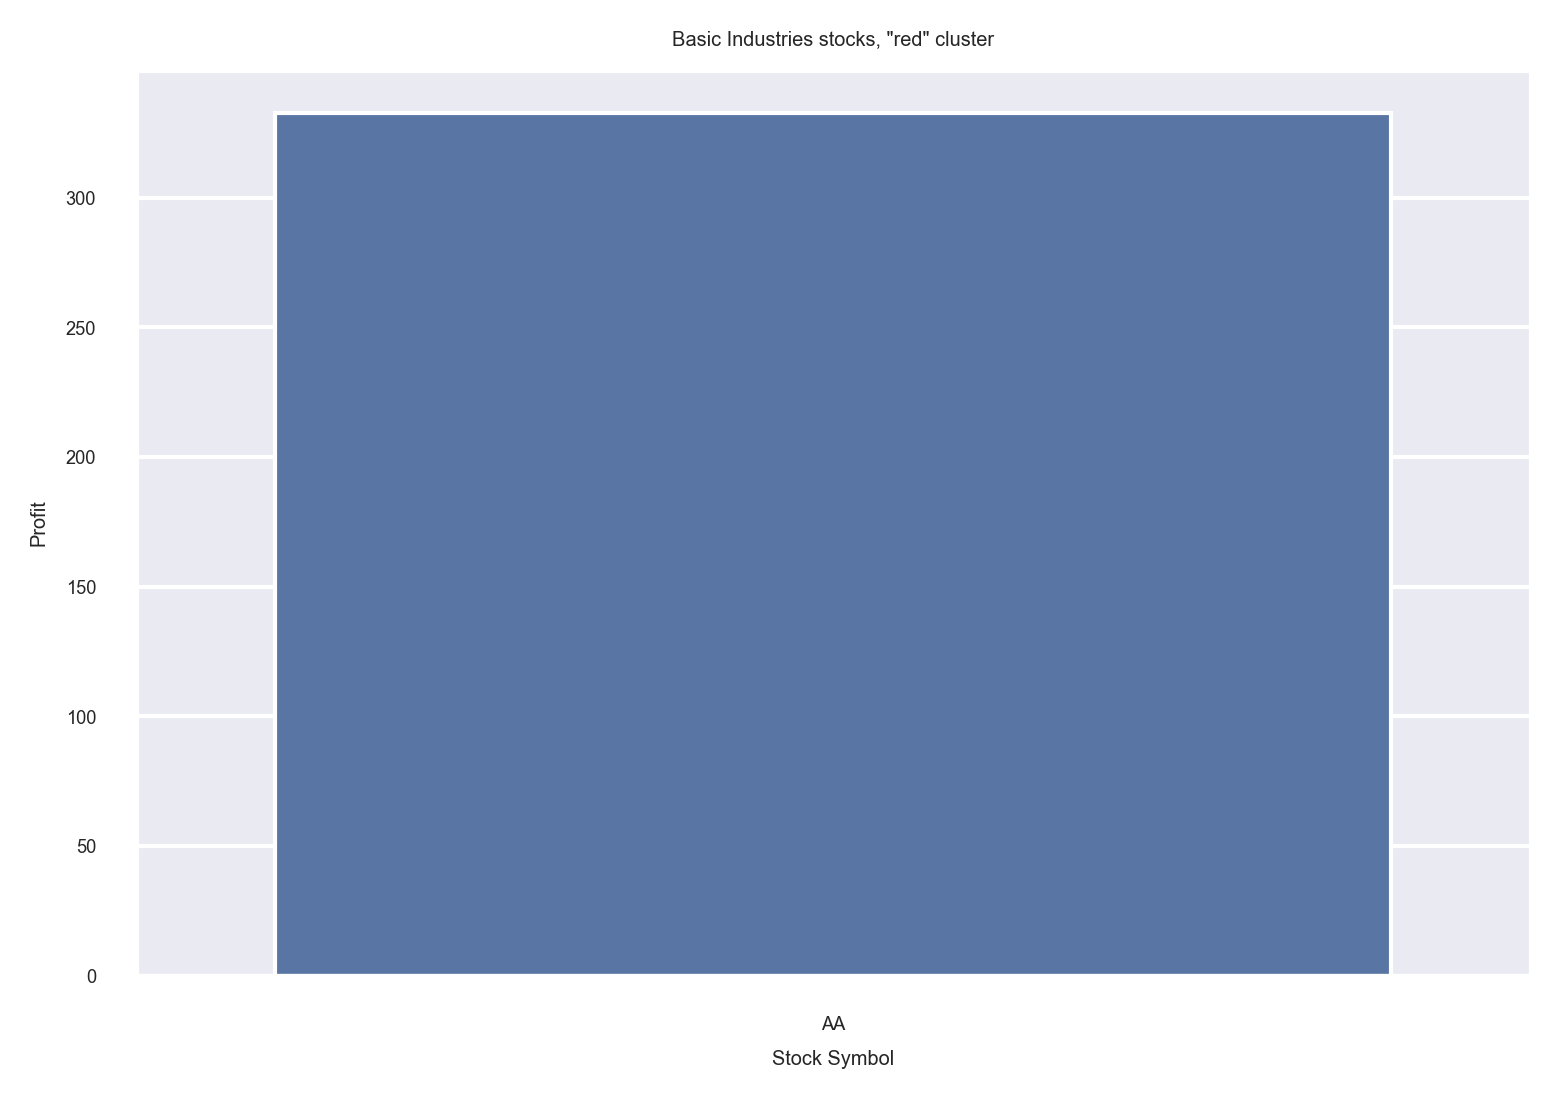

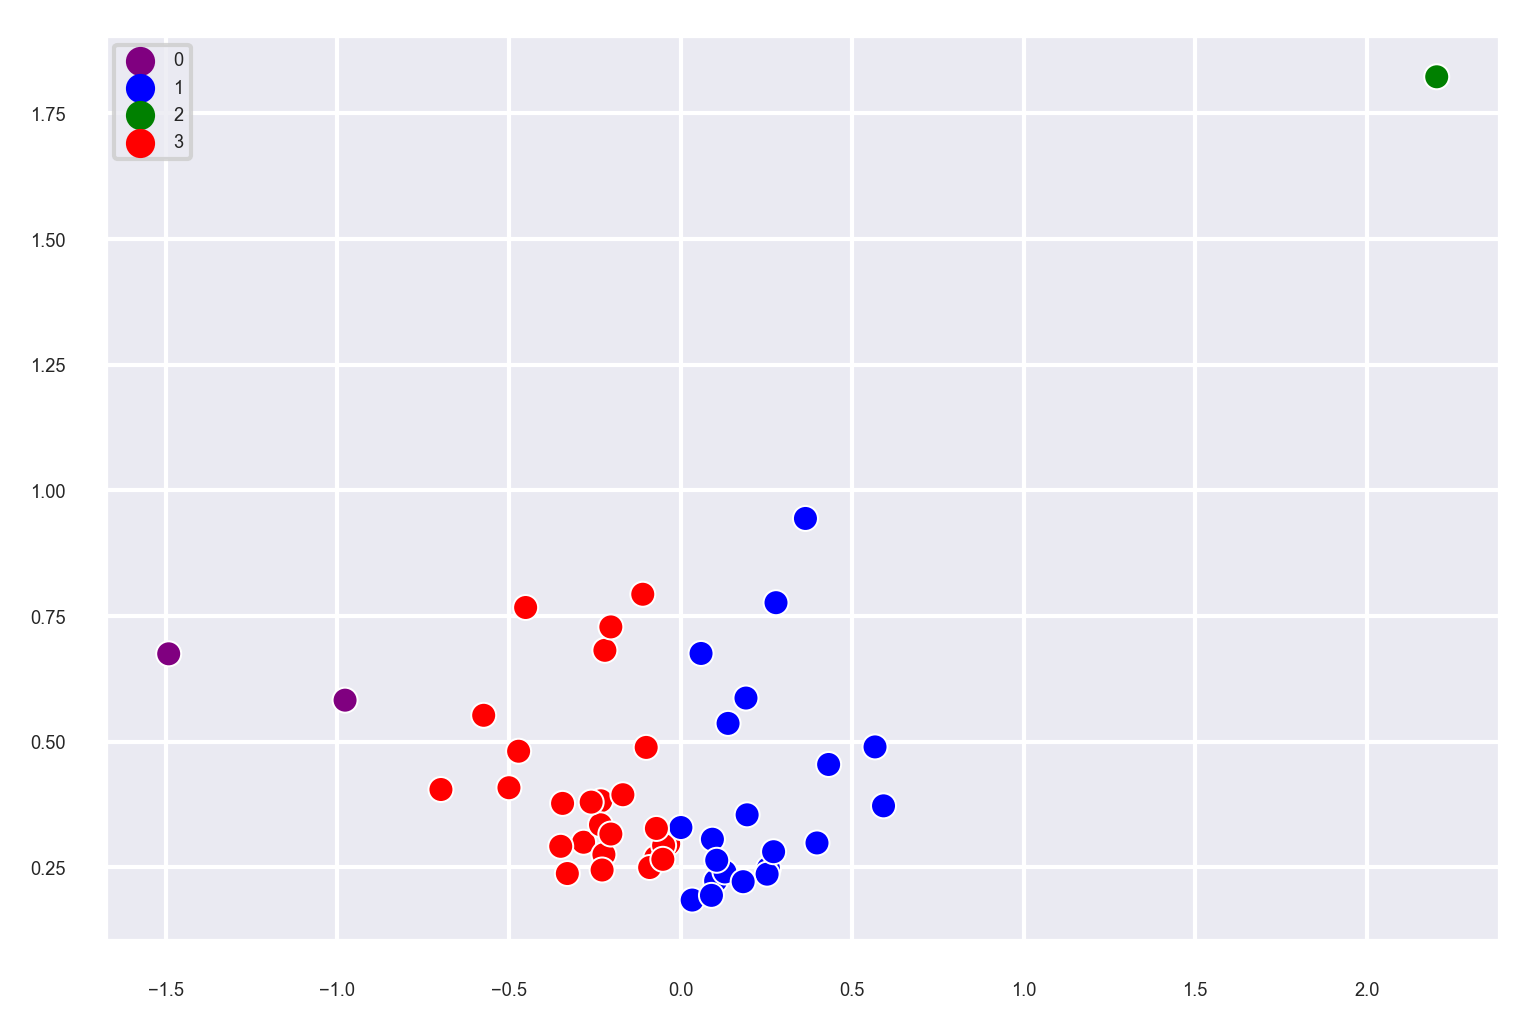

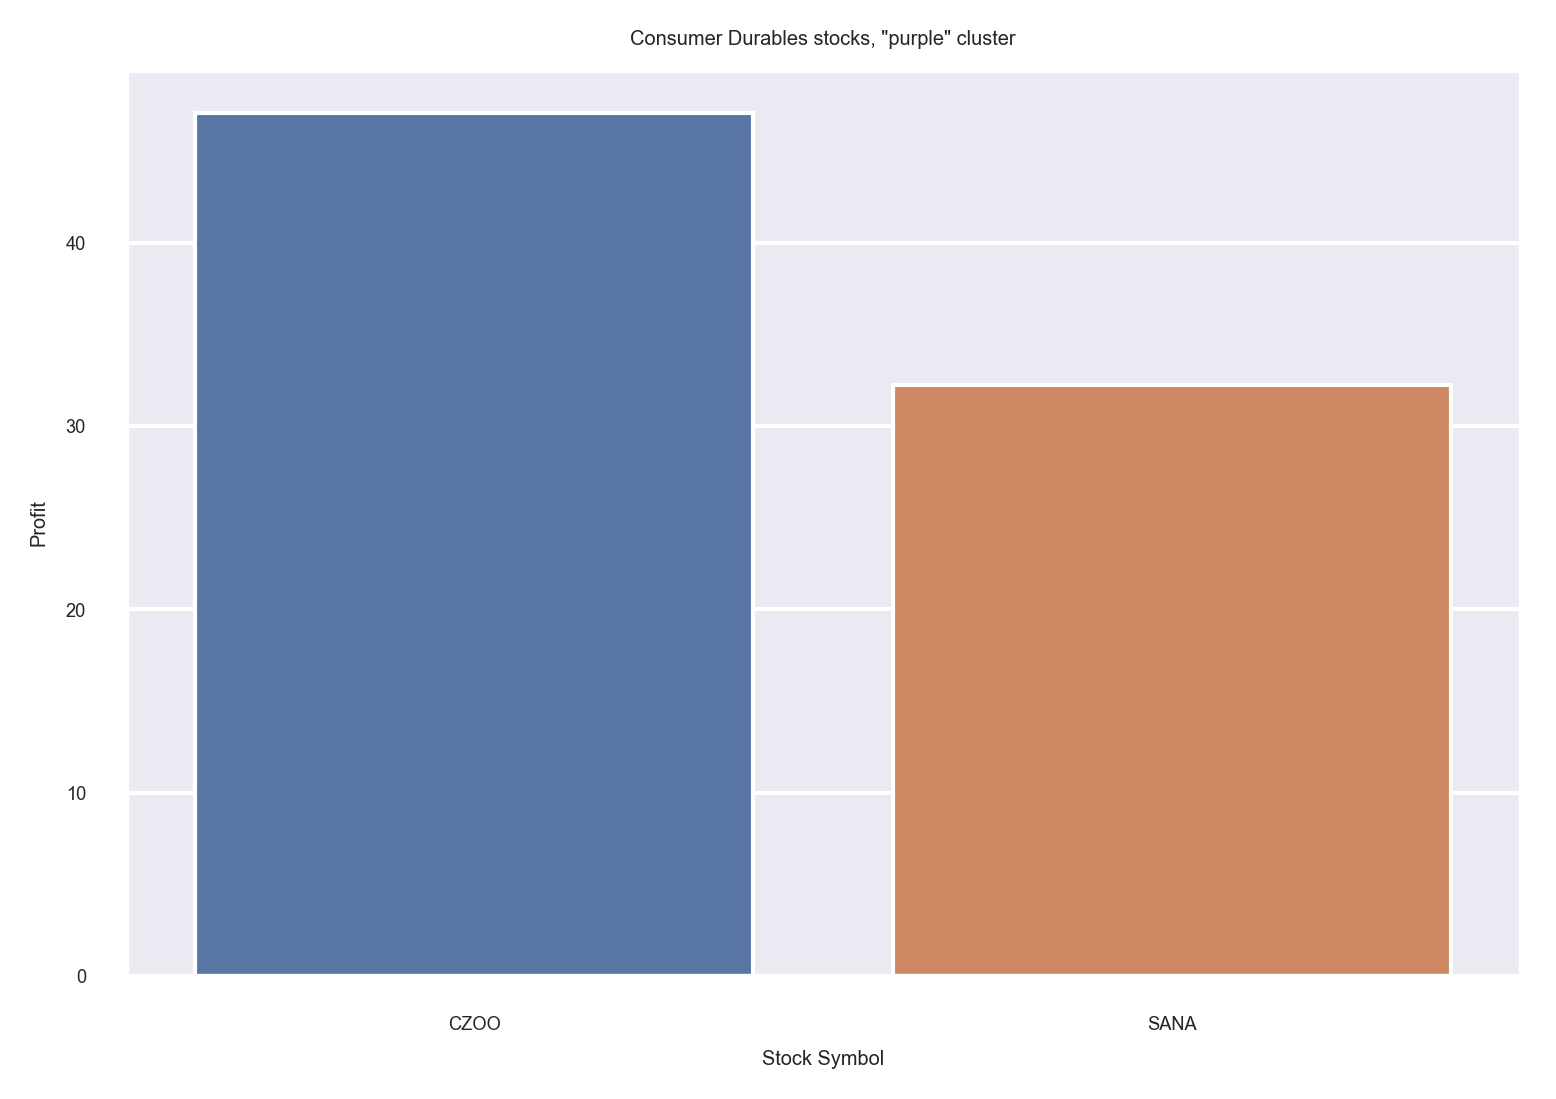

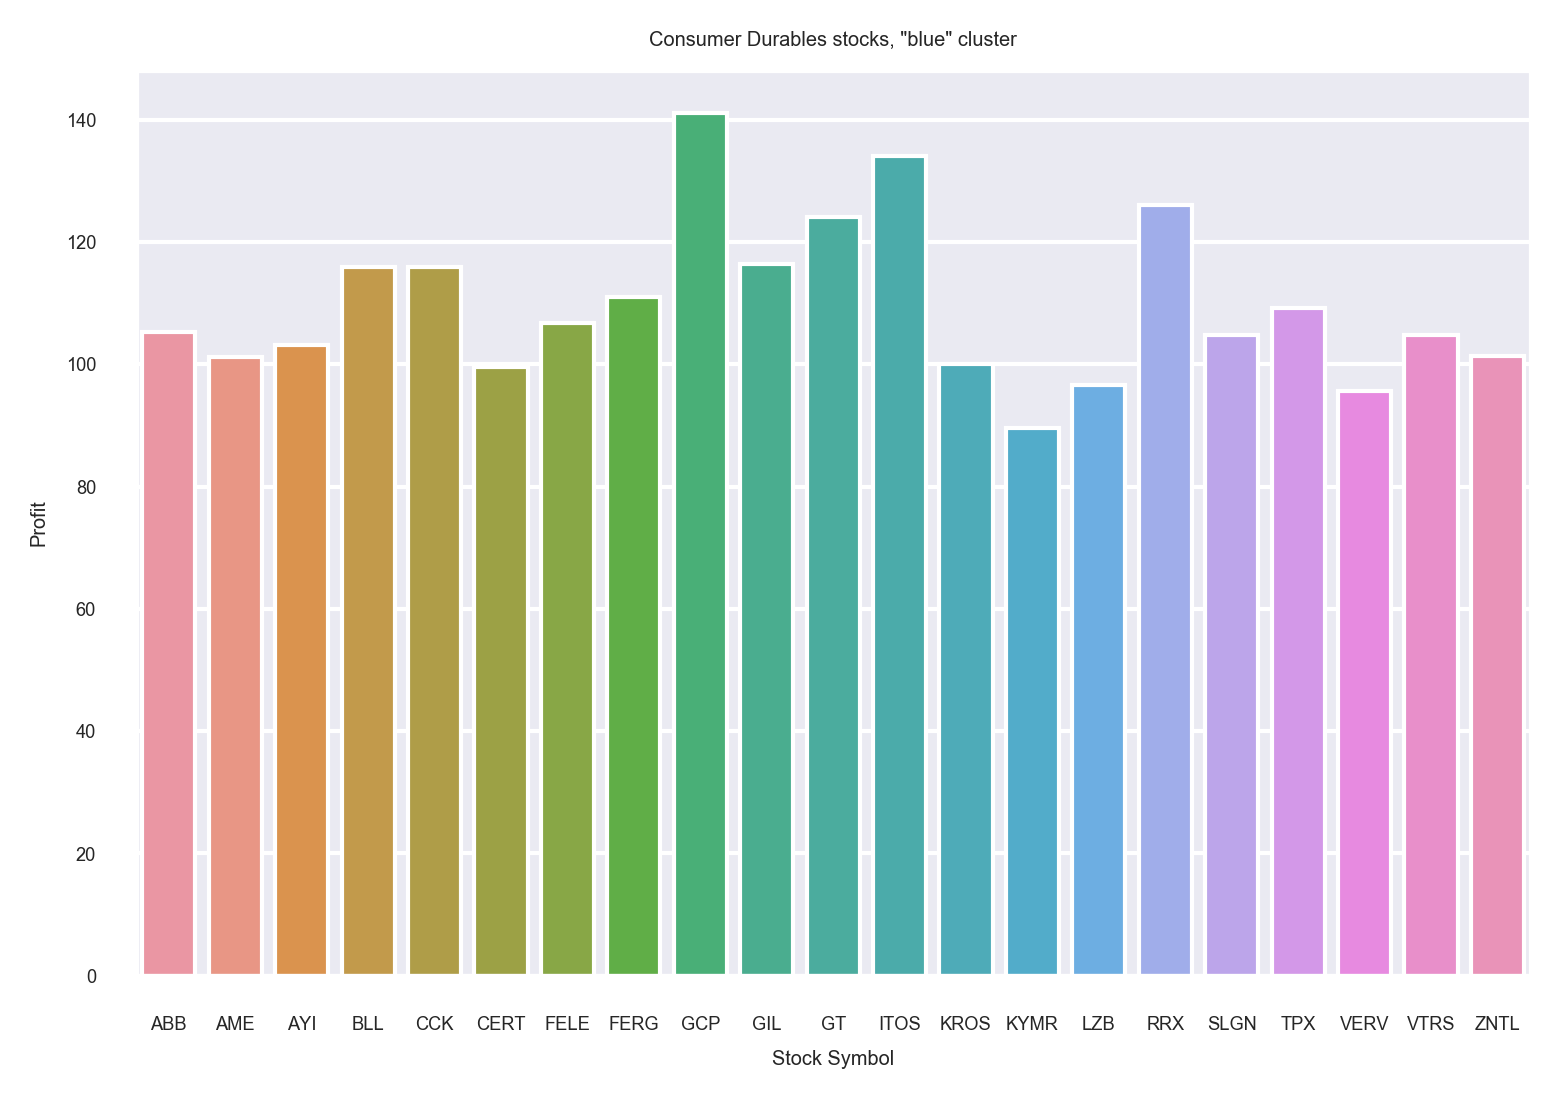

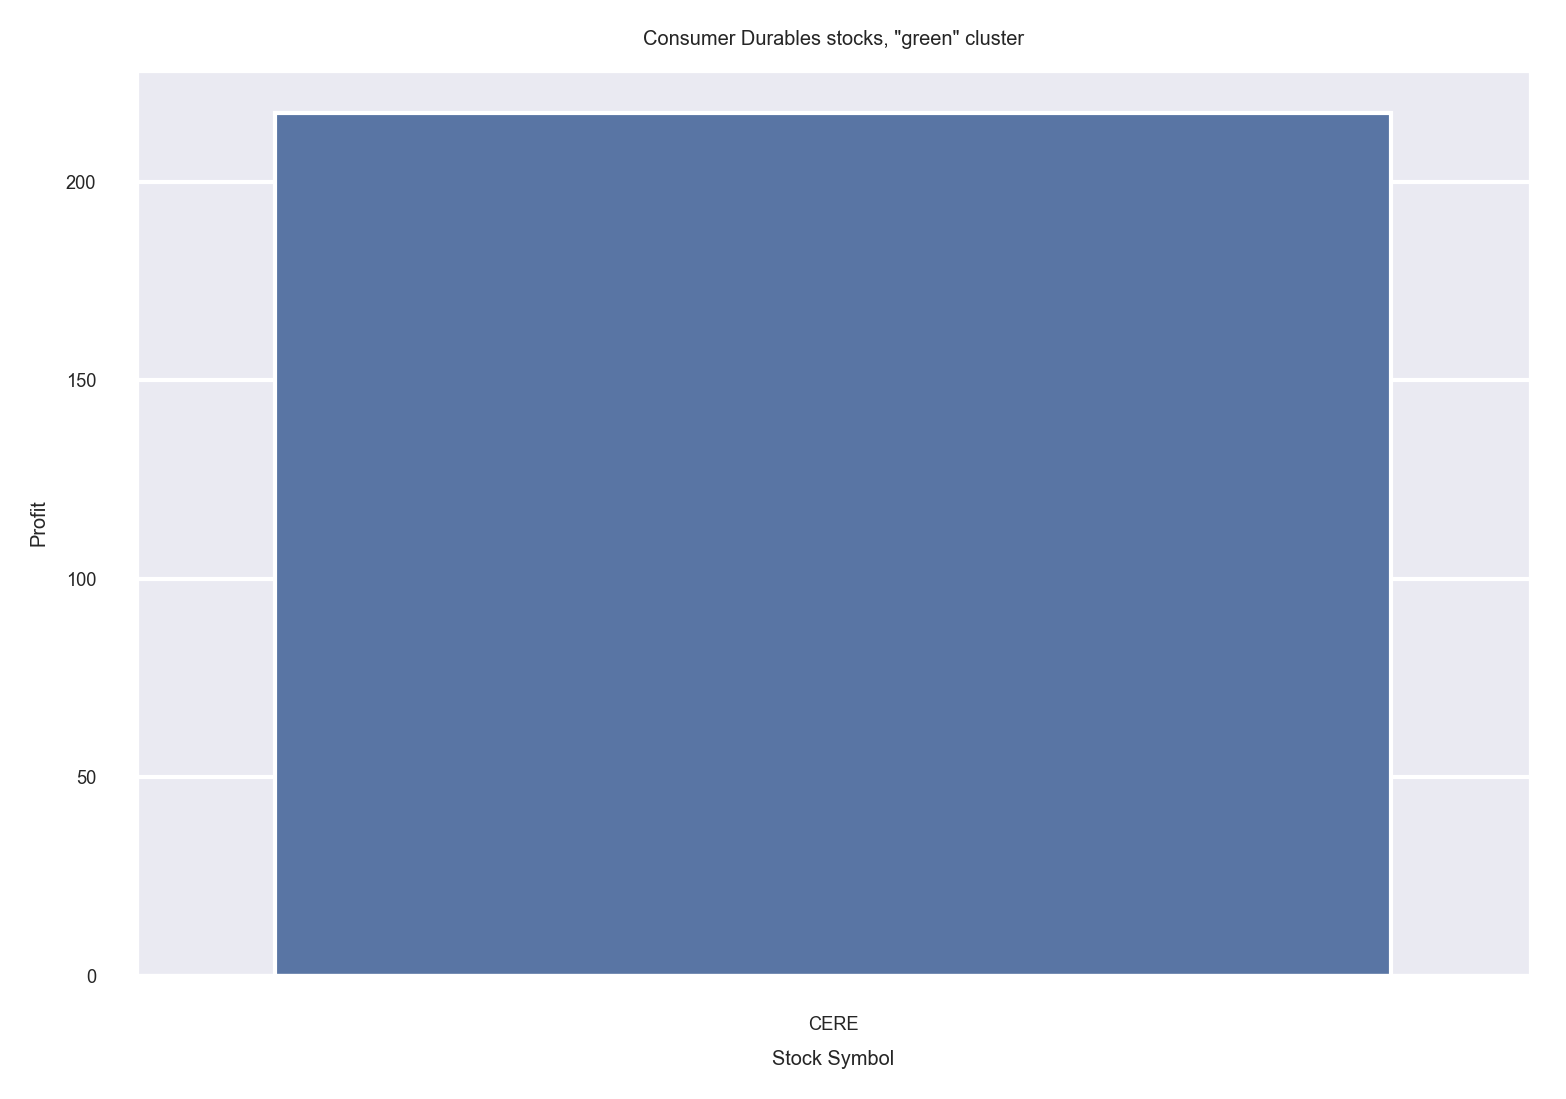

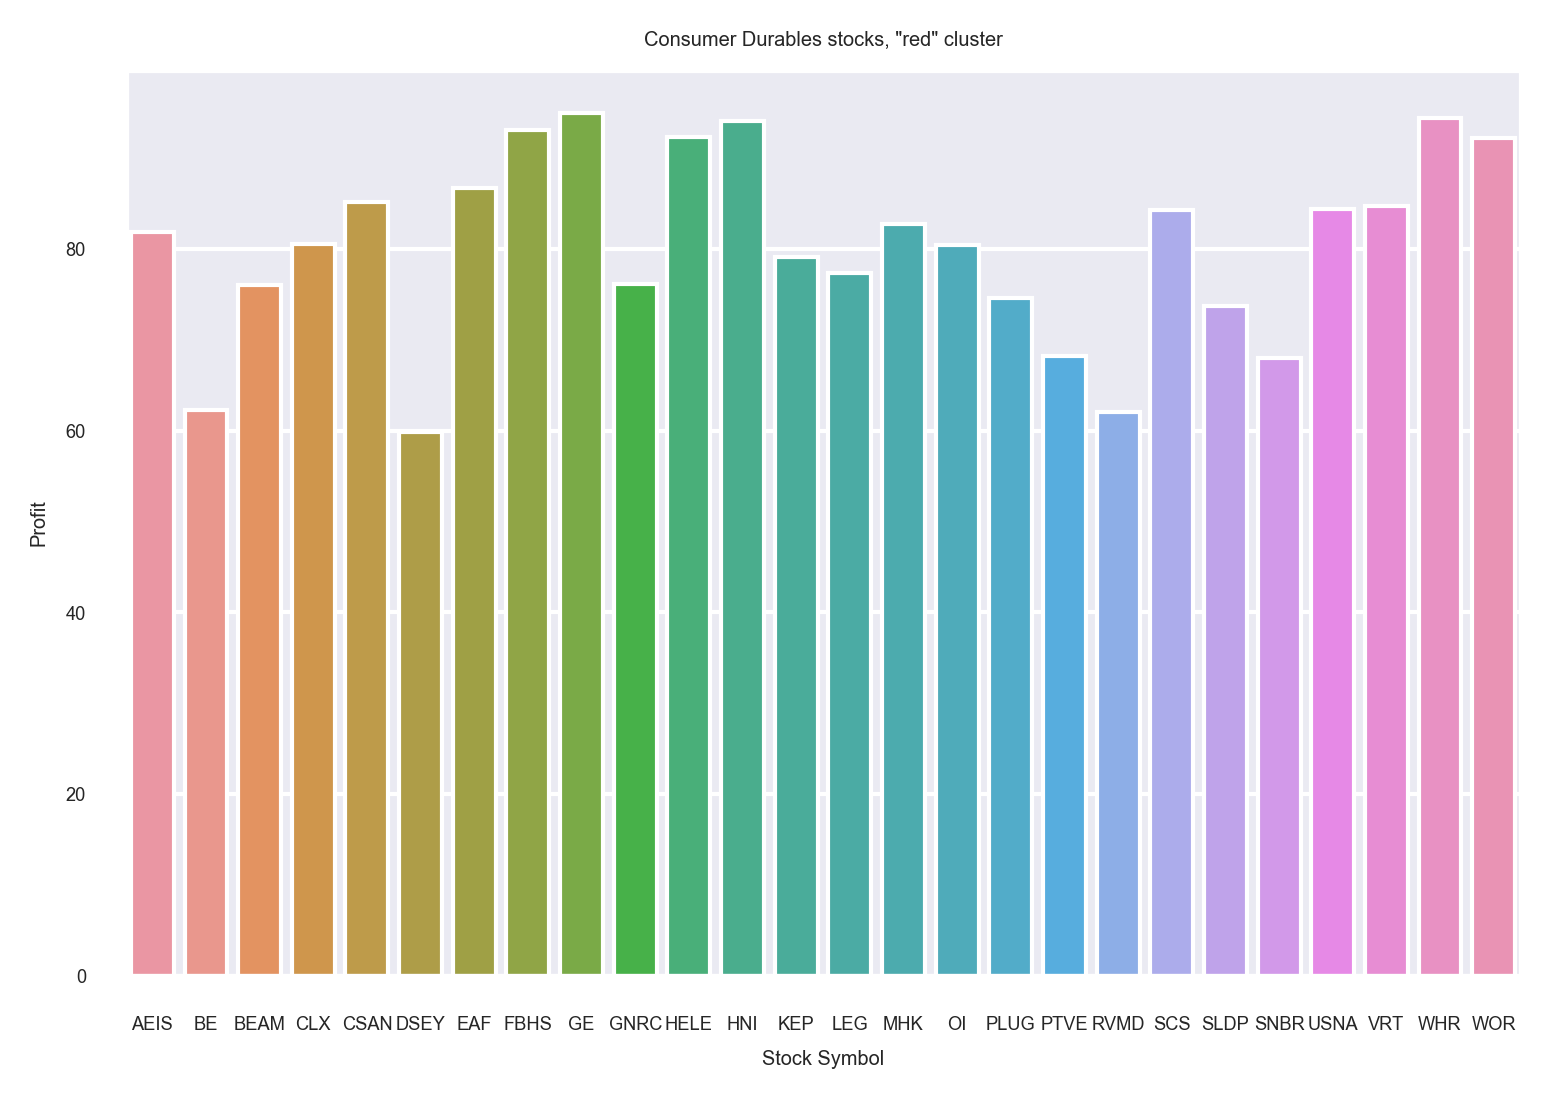

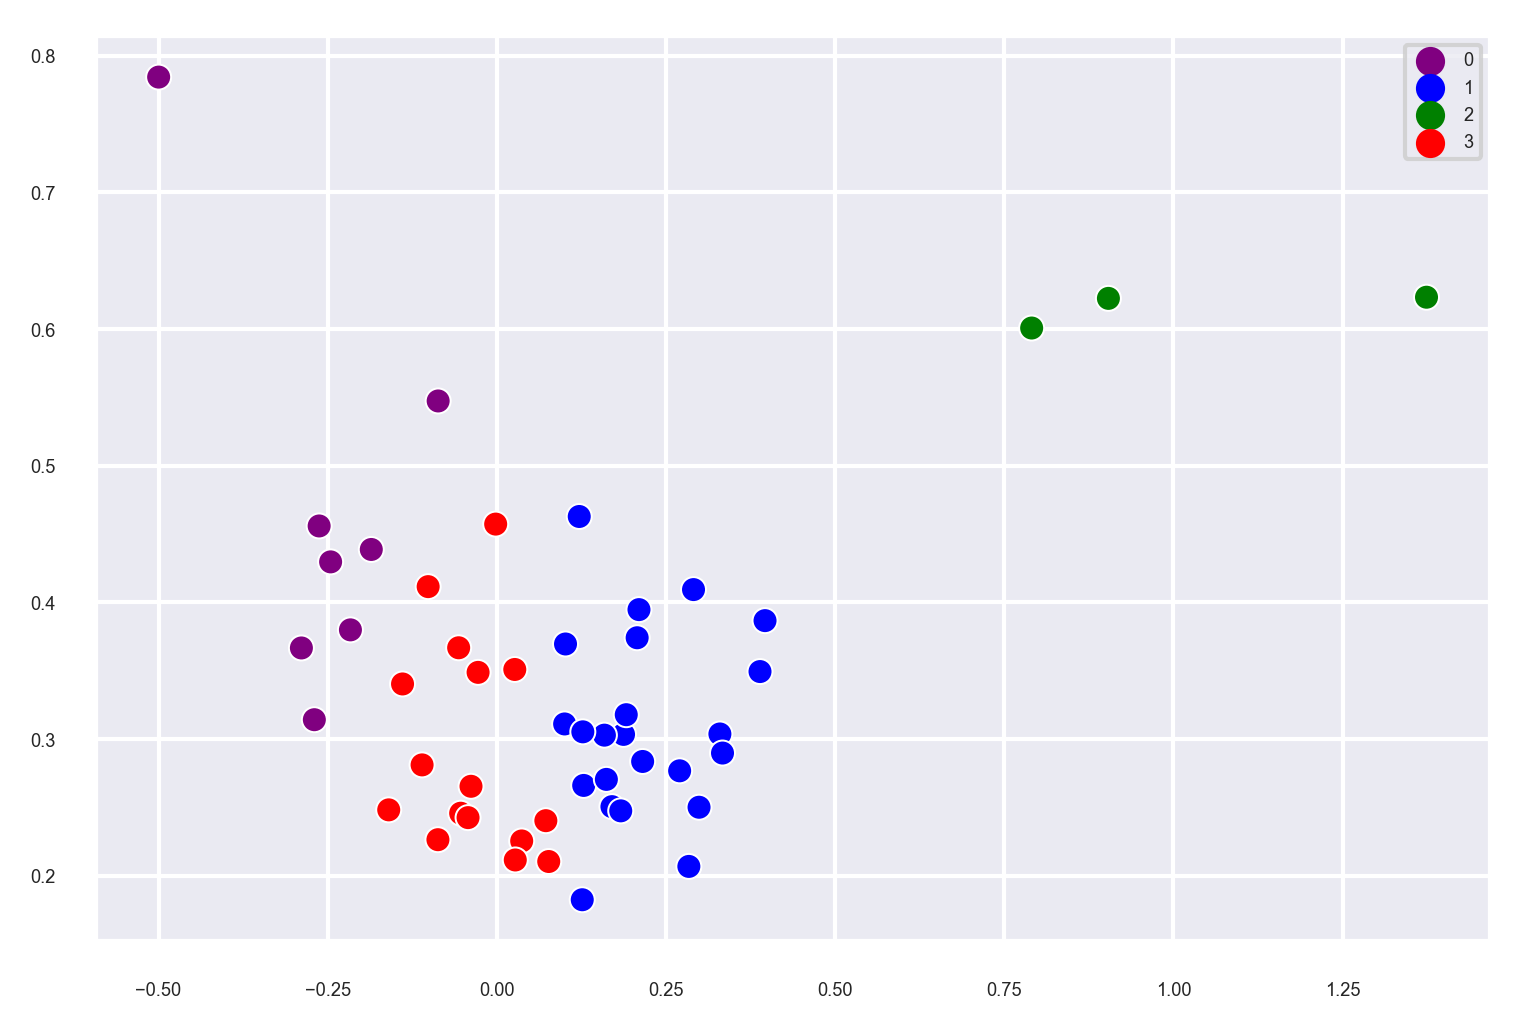

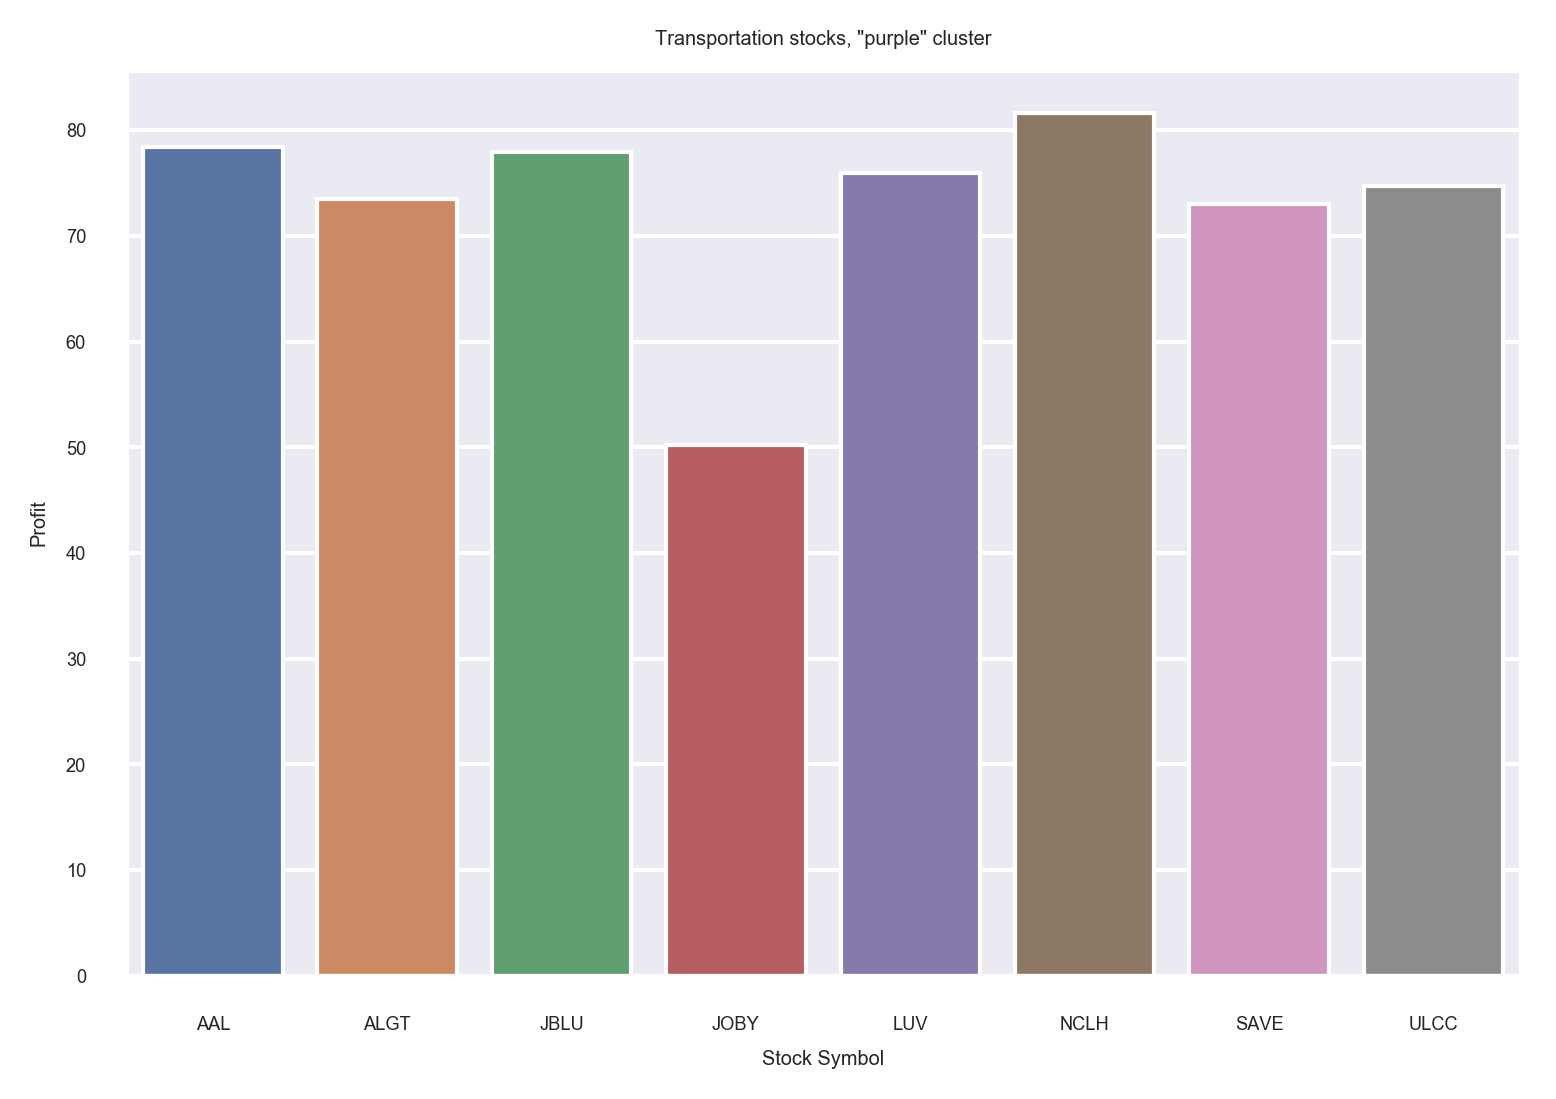

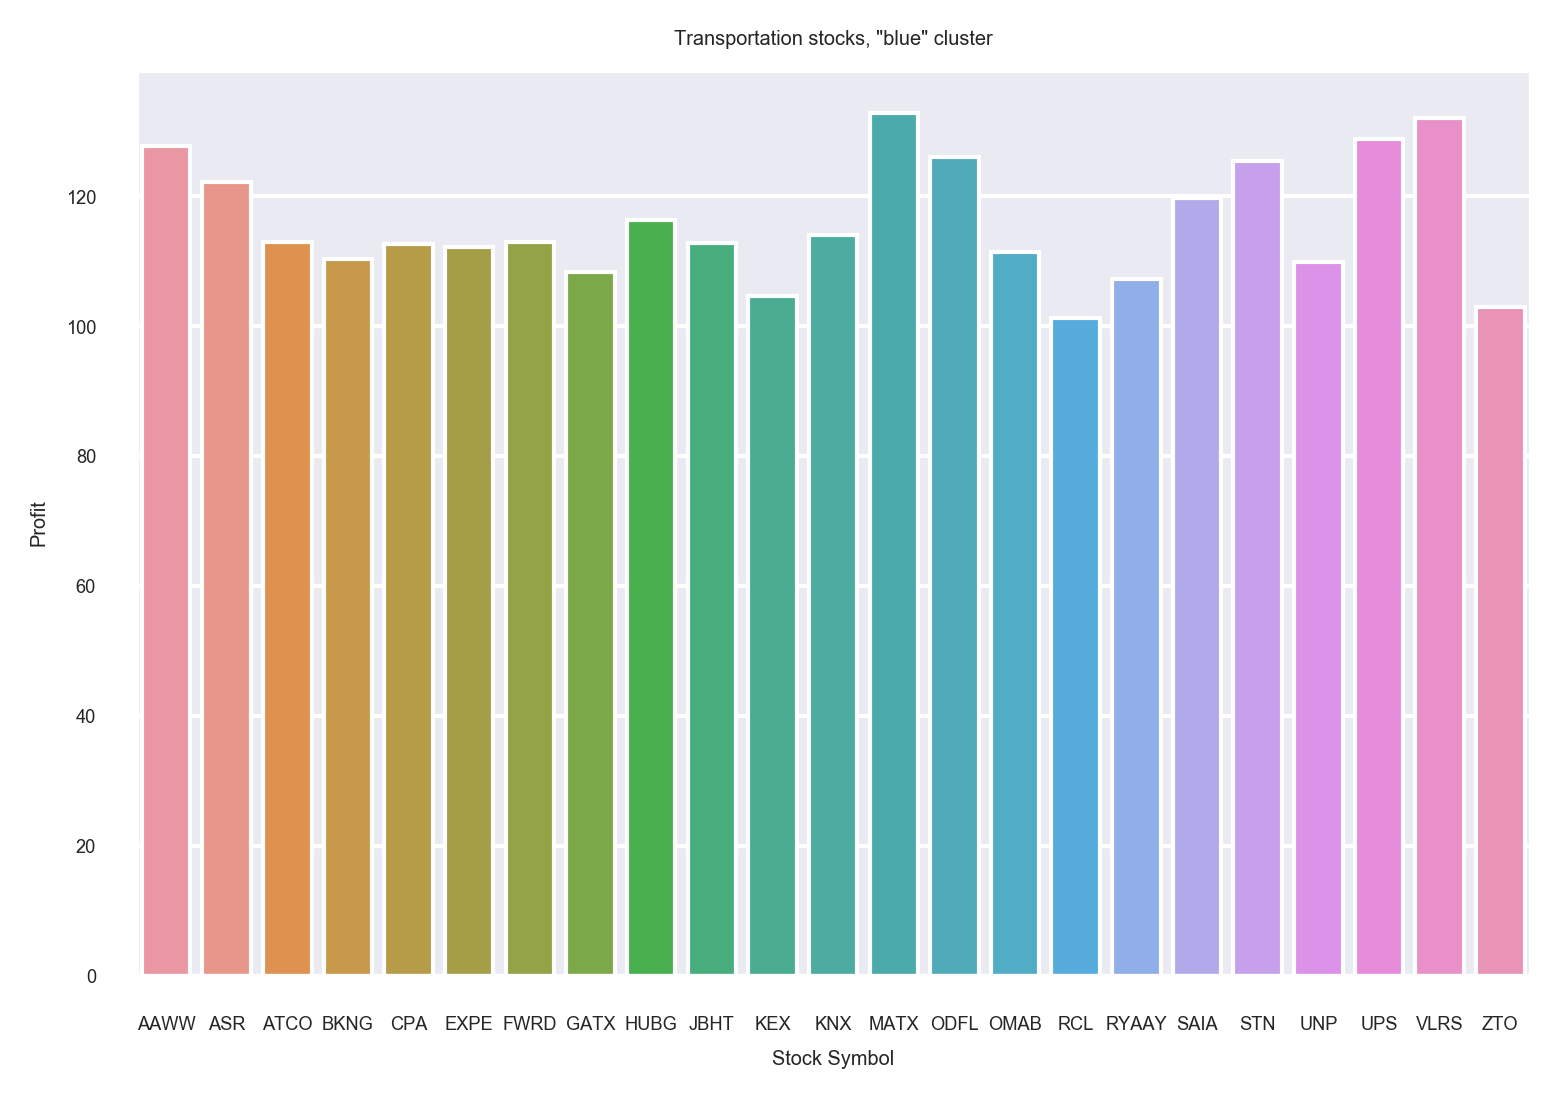

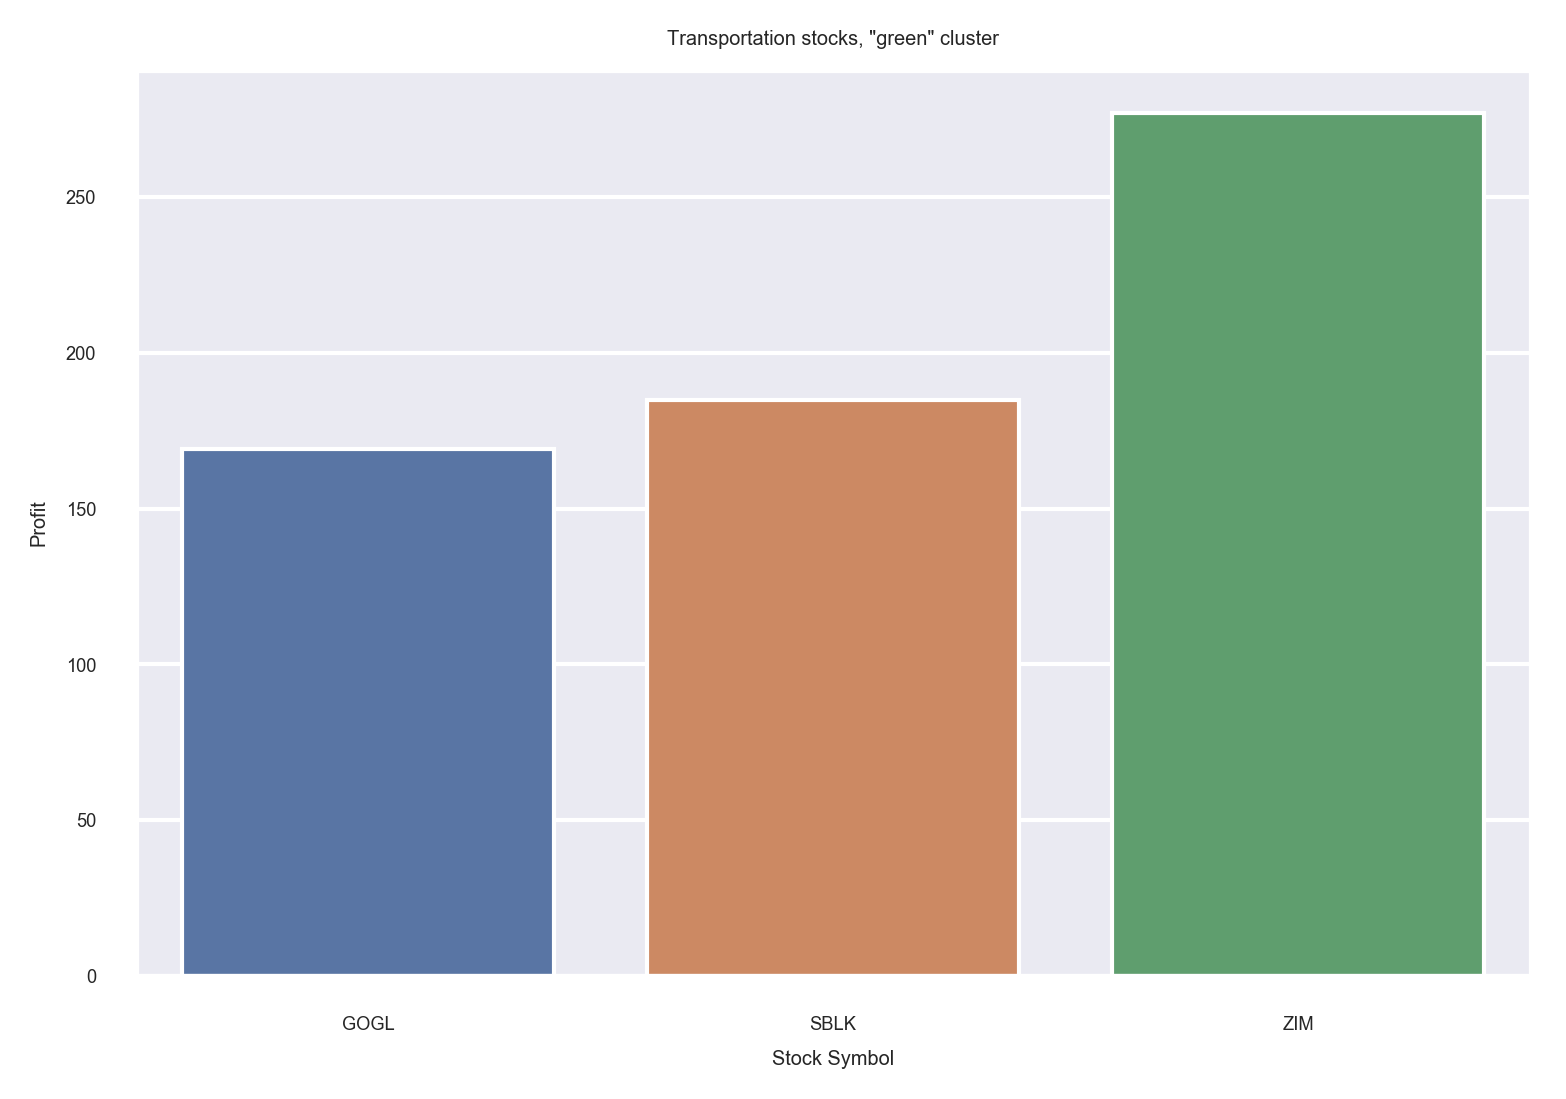

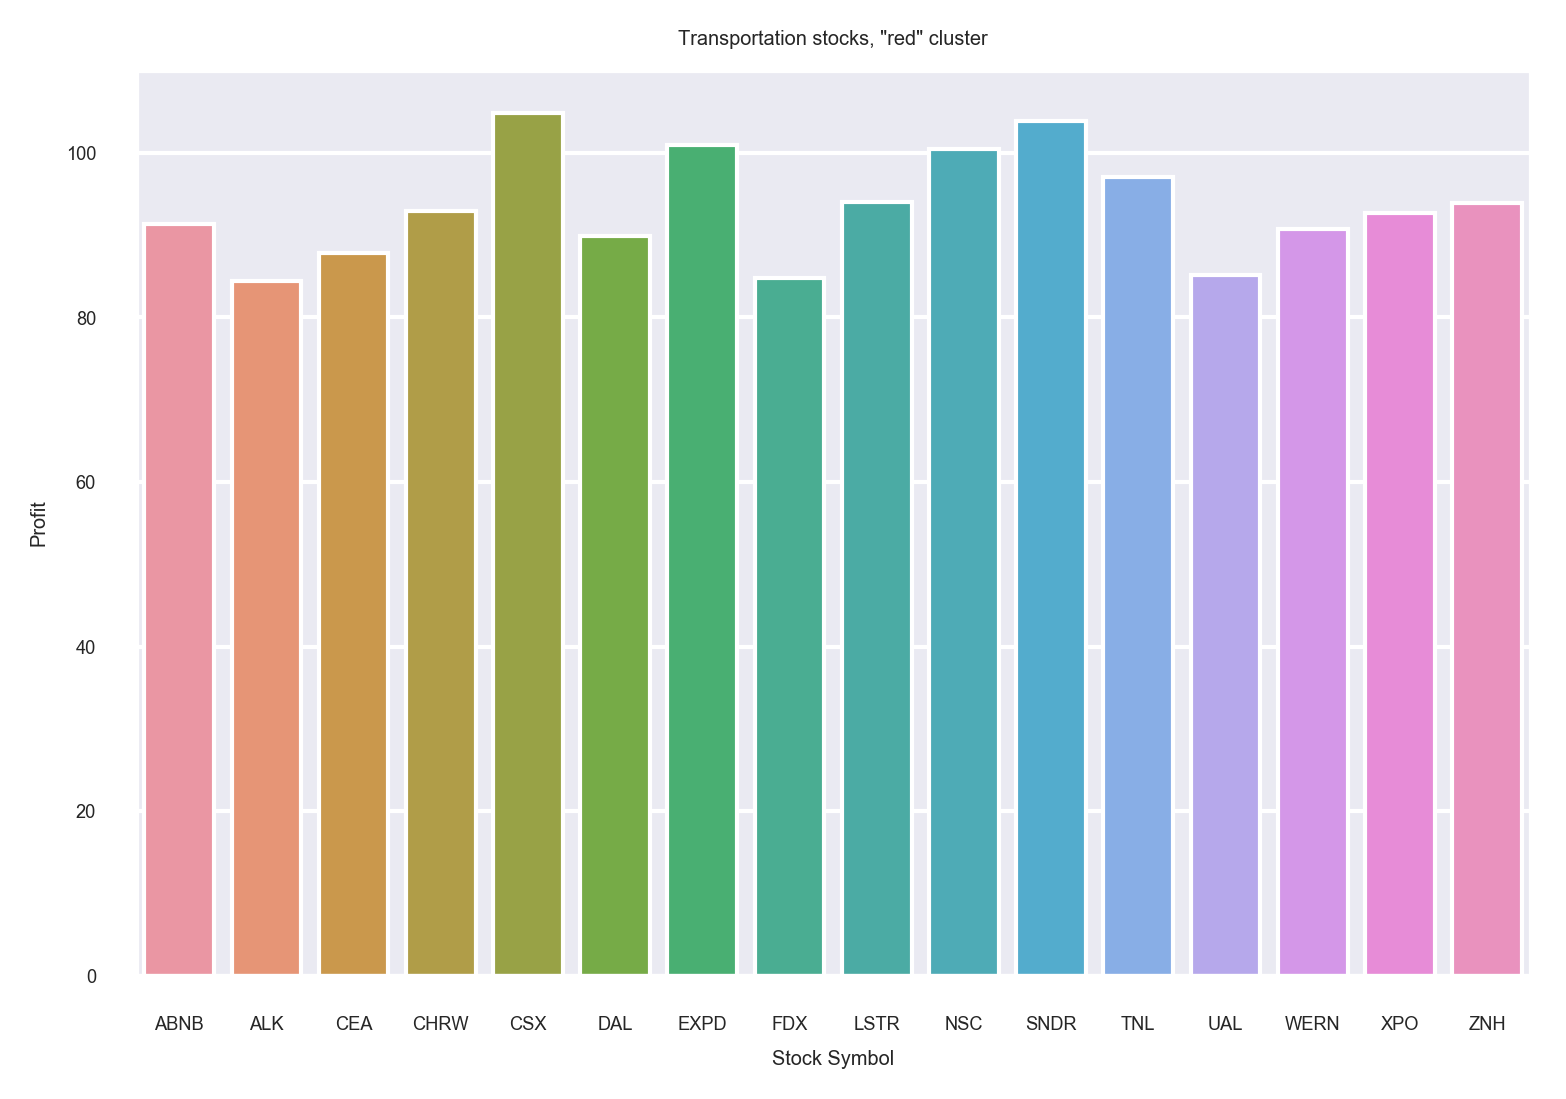

In [81]:
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
import  pylab as pl
import numpy as np

K = 4
colors = ['purple', 'blue', 'green', 'red']
for sector in sectors_set:
    print(f"####### {sector} #########")
    data = dataframes[sector]
    returns = data.pct_change().mean() * 252
    variance = data.pct_change().std() * np.sqrt(252)
    returns.columns = ["Returns"]
    variance.columns = ["Variance"]
    #Concatenating the returns and variances into a single data-frame
    ret_var = pd.concat([returns, variance], axis = 1).dropna()
    ret_var.columns = ["Returns","Variance"]
    X =  ret_var.values #Converting ret_var into nummpy array
    kmeans = KMeans(n_clusters = K).fit(X)
    centroids = kmeans.cluster_centers_
    sns.scatterplot(X[:, 0], X[:, 1], hue=kmeans.labels_, palette=colors)
    plt.title(f"{sector} stocks")
    pl.show()

    new_data = (data.iloc[-1] * 100) / data.iloc[0]
    tickers = data.columns
    values = new_data.values

    for i in range(K):
        indexes = kmeans.labels_ == i
        t = tickers[indexes]
        v = values[indexes]
        sns.barplot(x=t, y=v)
        plt.title(f"{sector} stocks, \"{colors[i]}\" cluster")
        plt.xlabel("Stock Symbol")
        plt.ylabel("Profit")
        plt.show()

